<a href="https://colab.research.google.com/github/bgittel/Fiktion-und-Genre/blob/main/MoL_read_annotation_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Analysis

## Install and import Libraries

In [27]:
%%capture --no-display
!pip install dkpro-cassis
!pip install spacy-sentiws
!python -m spacy download de_core_news_sm
!pip install fuzzywuzzy

In [29]:
#Libraries import.
from cassis import * #creation and manipulation of annotated documents: dkpro-cassis
from pathlib import * ##Not used
from collections import Counter
#Load annotation data into the notebook
from google.colab import drive
from google.colab import files
import os # Define the files to be deleted and modified in google Colab
import csv #Save to CSV after calcuations
import zipfile #For zip files
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from fuzzywuzzy import fuzz #for naming mistakes similarity scores.

/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


## Common funtions

In [ ]:
# Function to ensure that None values are converted to strings
def safe_str(obj):
    return str(obj) if obj is not None else 'NONE'

## Function for importing zip

In [ ]:
#Upload zip file intcontaining CAS XMI and XML
def upload_next_author_zip():

  #First delete files of previous author, if any.
  # Define the files to be deleted
  files_to_delete = ['TypeSystem.xml', 'CURATION_USER.xmi']

  # Path to the folder where the files are located
  content_folder_path = '/content/'

  # Delete the specified files if they exist
  for file_name in files_to_delete:
      file_path = os.path.join(content_folder_path, file_name)
      if os.path.isfile(file_path):
          os.remove(file_path)
          print(f"Deleted {file_path}")
      else:
          print(f"File {file_path} does not exist.")

  print(f"Deletion process completed for {files_to_delete} from path: {content_folder_path}.")
  print("\n")

  #Upload the ZIP file
  uploaded = files.upload()

  # Specify the extraction path
  content_folder_path = '/content/'

  # Extract the uploaded ZIP file to the specified folder
  for filename in uploaded.keys():
      # Ensure it's a zip file
      if filename.endswith('.zip'):
          with zipfile.ZipFile(filename, 'r') as zip_ref:
              zip_ref.extractall(content_folder_path)
              print(f'Extracted all files from {filename} to {content_folder_path}')
      else:
          print(f'{filename} is not a zip file')

  # Delete the ZIP file after extraction
  os.remove(filename)
  print(f'Deleted the ZIP file: {filename}')

## Function for resetting variables to default value and default variables.

In [ ]:
#Reset the values to default for variable: "annotation_overview_table"
def reset_annotation_overview_table(debug):
  global annotation_overview_table
  for key, value in annotation_overview_table.items():
      if isinstance(value, int):
          annotation_overview_table[key] = 0
      elif isinstance(value, str):
          annotation_overview_table[key] = '-'
  if debug:
    print(annotation_overview_table)
  return annotation_overview_table

In [ ]:
#All entries of the annotaion overview scheme to be calculated
annotation_overview_table = {
                             'Document_title' : '',
                             'Textlänge_token' : 0, #Text length (tokens)
                             'Textlänge_sent' : 0 , #Text length (sentences)
                             'Entität_gesamt' : 0, 	#Entity (total)
                             'Entität_Ding'  : 0, #Entity (thing)
                             'Entität_Figur' : 0, #Entity (character)
                             'Entität_Figurengruppe' : 0, 	#Entity (character group)
                             'Entität_Raum' : 0, 	#Entity (space)
                             'Entität_Bereich' : 0, #Entity (area)
                             'Entität_Grenze'	 : 0, #Entity (boundary)
                             'Entität_Zeitabschnitt' : 0, 	#Entity (time period)
                             'Entität_Sonstige' : 0, #Entity (other)

                              'Wertung_gesamt' : 0, #Evaluation (total)
                              'Erzählerwertung' : 0, #Narrator evaluation
                             'Figurenwertung' : 0, #Character evaluation
                             'Wertung_Kompositionsebene' : 0,  #Evaluation (composition level)
                             'positive_Wertung' : 0,  #Positive evaluation
                             'negative_Wertung' : 0,  #Negative evaluation
                             'Wertung_moralisch' : 0,  #Moral evaluation
                             'Wertung_eudäimonistisch' : 0,  #Eudaimonistic evaluation
                             'Wertung_sozialer_Status' : 0,  #Social status evaluation
                             'Wertung_ästhetisch' : 0,  #Aesthetic evaluation
                             'Wertung_sonstige' : 0,  #Other evaluation


                            'NP_Wertung' : '-',  #NP evaluation (##Not implemented)
                            'Teilsatzwertung' : '-',  #Clause evaluation (##Not implemented)

                             'Codierung_gesamt' : 0,  #Coding (overall)
                             'Codierung_tief_oberflächlich' : 0,  #Coding (deep vs. superficial)
                             'Codierung_natürlich_kulturell' : 0,  #Coding (natural vs. cultural)
                             'Codierung_traditionell_modern' : 0,  #Coding (traditional vs. modern)
                             'Codierung_harmonisch_disharmonisch' : 0,  #Coding (harmonious vs. disharmonious)
                             'Codierung_Gesund_krank' : 0,  #Coding (healthy vs. sick opposition)


                             'Opposition_gesamt' : 0,  #Opposition (overall)
                             'Wertopposition' : 0,  #Value opposition
                             'Wertopposition_Oppositionspaar': '', #Value opposition List
                             'Traditionell-modern-Opposition' : 0,  #Traditional vs. modern opposition
                             'Harmonisch-disharmonisch-Opposition' : 0,  #Harmonious vs. disharmonious opposition
                             'Natürlich-kulturell-Opposition' : 0,  #Natural vs. cultural opposition
                             'Gesund-krank-Opposition' : 0,  #Healthy vs. sick opposition
                             'Tiefgründig-oberflächlich-Opposition' : 0,  #Profound vs. superficial opposition
                             'Sonstige_Merkmalsopposition' : 0,  #Other feature opposition
                             'Merkmalsopposition_Oppositionspaar': '', #Other feature opposition List
                             'Zugehörigkeit_zu' : 0,  #Belonging to
                             'Element_von' : 0,  #Element of
                             'Kritikhaltige_Reflexion':0, #Kritikhaltige Reflexion

                             'Span_FIGUR' : 0,
                             'Span_LISTE_FIGUR' : '',

                             'Span_RAUM' : 0,
                             'Span_LISTE_RAUM' : '',

                             'Span_DING' : 0,
                             'Span_LISTE_DING' : '',

                             'Span_SONSTIGE' : 0,
                             'Span_LISTE_SONSTIGE' : '',

                             'Span_FIGURENGRUPPE' : 0,
                             'Span_LISTE_FIGURENGRUPPE' : '',

                             'Span_BEREICH' : 0,
                             'Span_LISTE_BEREICH' : '',

                             'Span_GRENZE' : 0,
                             'Span_LISTE_GRENZE' : '',

                             'Span_ABSTRAKTUM' : 0,
                             'Span_LISTE_ABSTRAKTUM' : '',

                             'Span_ZEITABSCHNITT' : 0,
                             'Span_LISTE_ZEITABSCHNITT' : '',

                             'Span_ORGANISATION' : 0,
                             'Span_LISTE_ORGANISATION' : '',

                             'Span_NONE' : 0, #In case there is no label (in case of author/Narrator)
                             'Span_LISTE_NONE' : '', #In case there is no label (in case of author/Narrator)
                             'total_list_naming_mistakes':0,
                             'list_naming_mistakes': ''
                            }

## Function to for saving to CSV file

In [ ]:
#Safe the results to CSV file.
def save_to_csv(annotation_overview_table,debug):
    # Define the CSV file name
    csv_file = 'output.csv'

    # Check if the CSV file already exists
    file_exists = os.path.isfile(csv_file)

    # Open the CSV file in append mode
    with open(csv_file, mode='a', newline='', encoding='ISO-8859-1') as file:
        writer = csv.writer(file)

        # Write the header only if the file does not exist
        #if not file_exists:
            # Write the header row
        if debug:
          writer.writerow(annotation_overview_table.keys())

        # Write the dictionary values as a new row
        writer.writerow(annotation_overview_table.values())

    print(f"Data appended to {csv_file}")

## Funtions to count Tokens and Sentences

In [ ]:
#Count Analysis of Tokens
def token_info(doc, debug):
  #Textlänge_token
  #Text length (tokens)
  token_count = sum(1 for count in doc.select('de.tudarmstadt.ukp.dkpro.core.api.segmentation.type.Token'))
  if debug:
    print("#################### Textlänge_token (Number of (tokens)) #####################################")
    print(f'Token_Count: {token_count}')
    print("\n")

  #Calculated values from this cell.
  annotation_overview_table['Textlänge_token'] = token_count #Text length (tokens)


#Count Analysis of Sentences
def sen_info(doc,debug):
  #Textlänge_sent
  #Text length (sentences)
  sentence_count = sum(1 for count in doc.select('de.tudarmstadt.ukp.dkpro.core.api.segmentation.type.Sentence'))
  if debug:
    print("#################### Textlänge_sent (Number of (sentences)) #####################################")
    print(f'Sentence_Count: {sentence_count}')
    print("\n")

  #Calculated values from this cell.
  annotation_overview_table['Textlänge_sent'] = sentence_count #Text length (sentences)

## Funtion to count Entities(Entität)

In [ ]:
#Count Analysis of Entities
def entities_info(doc, debug):
  #Entität_gesamt	Entität_Ding	Entität_Figur	Entität_Figurengruppe	Entität_Raum	Entität_Bereich	Entität_Grenze	Entität_Zeitabschnitt	Entität_Sonstige
  #Entity (overall)	Entity (thing)	Entity (character)	Entity (character group)	Entity (space)	Entity (area)	Entity (boundary)	Entity (time period)	Entity (other)

  # Initialize counts
  Entities_counts = {'DING' : 0,
                    'FIGUR': 0,
                    'FIGURENGRUPPE': 0,
                    'RAUM': 0,
                    'BEREICH' : 0,
                    'GRENZE': 0,
                    'ZEITABSCHNITT': 0,
                    'SONSTIGE': 0
  }
  #Get the entity label and count if in the list of entity type.
  for token in doc.select('custom.Span'):
    if token.label in Entities_counts:
      Entities_counts[token.label] += 1

  if debug:
    print("#################### Entität (Entity Counts) #####################################")
    print(f'Gesamt: {sum(Entities_counts.values())}::',Entities_counts)
    print("\n")


  #Calculated values from this cell.
  annotation_overview_table['Entität_gesamt'] = sum(Entities_counts.values()) #Entity (total)
  # Create a mapping of Entities_counts keys to annotation_overview_table keys
  mapping = {'DING' : 'Entität_Ding',
                    'FIGUR': 'Entität_Figur',
                    'FIGURENGRUPPE': 'Entität_Figurengruppe',
                    'RAUM': 'Entität_Raum',
                    'BEREICH' : 'Entität_Bereich',
                    'GRENZE': 'Entität_Grenze',
                    'ZEITABSCHNITT': 'Entität_Zeitabschnitt',
                    'SONSTIGE': 'Entität_Sonstige'
  }

  # Update annotation_overview_table_key with the values from Entities_counts based on the mapping
  for Entities_counts_key, annotation_overview_table_key in mapping.items():
    if Entities_counts_key in Entities_counts:
        annotation_overview_table[annotation_overview_table_key] = Entities_counts[Entities_counts_key]

## Funtion to count Ratings/Evaluations(Wertung)

In [ ]:
#Count Analysis of Ratings/Evaluation
def evaluation_info(doc,debug): #Exlcluding Positive and negative count as they are calulcated in Evaluation_count_positive_negative():

  #Wertung_gesamt	Erzählerwertung	Figurenwertung	Wertung_Kompositionsebene	 	Wertung_moralisch	Wertung_eudäimonistisch	Wertung_sozialer_Status	Wertung_ästhetisch	Wertung_sonstige
  #Evaluation (total)	Narrator evaluation	Character evaluation	Evaluation (composition level) Moral evaluation	Eudaimonistic evaluation	Social status evaluation	Aesthetic evaluation	Other evaluation



  # Initialize counts
  evaluations_counts = {'Erzählerwertung' : 0 , 'Figurenwertung' : 0 ,	'Kompositionsebene' : 0 ,
                    #'positive_Wertung' : 0 ,	'negative_Wertung' : 0 , #calculated in evaluation_count_positive_negative():
                    'moralisch' : 0 ,	'eudämonistisch' : 0 ,
                    'sozialer Status' : 0 ,	'ästhetisch' : 0 ,	'sonstige' : 0
  }

  #Get the label and count if in the list of Evaluation types.
  for token in doc.select('webanno.custom.Wertung'):
    if token.Wertungshinsicht in evaluations_counts:
      evaluations_counts[token.Wertungshinsicht] += 1
    elif token.Wertungshinsicht =='nicht spezifiziert': #Added count of nicht spezifiziert to sonstige
      evaluations_counts['sonstige'] += 1
    if token.Wertung_auf_Kompositionsebene == 'Kompositionsebene':
      evaluations_counts['Kompositionsebene'] += 1

  #finding Erzählerwertung and Figurenwertung

  #xmiID of Figures from custom.Span
  Span_FIGUR_list = []
  for token in doc.select('custom.Span'):
    if token.label == "FIGUR":
      Span_FIGUR_list.append(token.xmiID)

  Wertender_list_target=[]
  gewertete_Entität_target=[]
  other_Entität_target=[]

  for segment in doc.select('webanno.custom.Wertung'):
      #print(segment.TEST)
      #print(str(segment.TEST.elements))
      if segment.TEST:
        for e in segment.TEST.elements:
          if e.role == "Wertender":
            #print( e.target.get_covered_text(), "Role: ", e.role,e.xmiID)
            #Wertender_list.append(e.xmiID)
            Wertender_list_target.append(e.target.xmiID)
          elif e.role == "gewertete Entität":
            #print( e.target.get_covered_text(), "Role: ", e.role,e.xmiID)
            #gewertete_Entität.append(e.xmiID)
            gewertete_Entität_target.append(e.target.xmiID)
          else:
            #print( e.target.get_covered_text(), "Role: ", e.role,e.xmiID)
            other_Entität_target.append(e.xmiID)




  Wertender_list_target_SpanEntiy=[]
  gewertete_Entität_target_SpanEntiy=[]

  #If only in gewertete_Entität then its the Erzählerwertung (Narrator evaluation: Default assumption)
  for item1 in Wertender_list_target:
    if item1 in Span_FIGUR_list:
      Wertender_list_target_SpanEntiy.append(item1)

  for item2 in gewertete_Entität_target:
    if item2 in Span_FIGUR_list:
      gewertete_Entität_target_SpanEntiy.append(item2)




  Figurenwertung=0
  Erzählerwertung=0


  for item in gewertete_Entität_target_SpanEntiy:
      if item not in Wertender_list_target_SpanEntiy:
        Erzählerwertung+=1# only in gewertete_Entität then its the Erzählerwertung (Narrator evaluation: Default assumption)
      else:
        Figurenwertung+=1 #Character evaluation (link_feature)


  evaluations_counts['Erzählerwertung'] = Erzählerwertung
  evaluations_counts['Figurenwertung'] = Figurenwertung

  Wertung_gesamt=evaluations_counts['Erzählerwertung']+evaluations_counts['Figurenwertung']+evaluations_counts['Kompositionsebene']



  if debug:
    print("####################  Wertung (Analysis of Ratings ) : Excluding positive_Wertung	negative_Wertung #####################################")
    print('\n')
    print(Wertender_list_target)
    print(gewertete_Entität_target)
    print(other_Entität_target)
    print(Wertender_list_target_SpanEntiy)
    print(gewertete_Entität_target_SpanEntiy)
    print(f'Wertung_gesamt: {Wertung_gesamt}::',evaluations_counts)
    print("\n")


  annotation_overview_table['Wertung_gesamt'] = Wertung_gesamt #Ratings/Evaluation (total)

  # Create a mapping of evaluations_counts keys to annotation_overview_table keys
  mapping = {'Erzählerwertung' : 'Erzählerwertung' ,
                    'Figurenwertung' : 'Figurenwertung' ,	'Kompositionsebene' : 'Wertung_Kompositionsebene' ,
                    #'positive_Wertung' : 'positive_Wertung' ,	'negative_Wertung' : 'negative_Wertung' ,
                    'moralisch' : 'Wertung_moralisch' ,	'eudämonistisch' : 'Wertung_eudäimonistisch',
                    'sozialer Status' : 'Wertung_sozialer_Status' ,	'ästhetisch' : 'Wertung_ästhetisch' ,	'sonstige' : 'Wertung_sonstige'
  }

  # Update annotation_overview_table_key with the values from coding_counts based on the mapping
  for coding_counts_key, annotation_overview_table_key in mapping.items():
    if coding_counts_key in evaluations_counts:
        annotation_overview_table[annotation_overview_table_key] = evaluations_counts[coding_counts_key]


## Funtion to count Positive, nagative Ratings/Evaluations(Wertung)

In [ ]:
# Wertungen ausgeben / Issue ratings
#Erzählerwertung	Figurenwertung	Wertung_Kompositionsebene	positive_Wertung	negative_Wertung
#Narrator evaluation(default)	Character evaluation	Evaluation (composition level)author	Positive evaluation	Negative evaluation
#Count Analysis of Ratings
def evaluations_count_positive_negative(doc,debug):


  # Initialize the dictionary
  dict_positive_entities = {}
  dict_negative_entities = {}
  dict_positive_entities_nameless  = {}
  dict_negative_entities_nameless  = {}

  for segment in doc.select('webanno.custom.Wertung'): ##webanno.custom.rating
      #print("hier: ", segment.TEST)
      #print(str(segment.TEST.elements)) # seems like i don't miss any information by not printing this?
      #print(segment.Label, ": ", segment.get_covered_text(), "; Hinsicht: ", segment.Wertungshinsicht, "; Polarität: ", segment.Polaritt)

      Erzählerwertung = True  ##Narrator Rating = TRUE
      try:
          for e in segment.TEST.elements: # and why does this seem to work here but not above?
              #print(e)
              pass
      except:
          print("Segment ohne gew. Objekt: Segment without selected object") ##Segment without selected object
          continue

      for e in segment.TEST.elements:
          #print(e.role, ": ", e.target.get_covered_text(), ", Typ: ", e.target.label, ", Name: ", e.target.Name, ", Polarität: ", segment.Polaritt)

          # create lists of positive entities
          if Erzählerwertung == True and segment.Polaritt == "sehr positiv" or segment.Polaritt == "positiv" and e.role == "gewertete Entität":
              if e.target.Name == None:
                if e.target.get_covered_text() not in dict_positive_entities_nameless:
                  dict_positive_entities_nameless[e.target.get_covered_text()] = 1
                else:
                  dict_positive_entities_nameless[e.target.get_covered_text()] += 1

              elif e.target.Name not in dict_positive_entities:
                  dict_positive_entities[e.target.Name] = 1
              else:
                  dict_positive_entities[e.target.Name] += 1


          # create lists of negative entities
          if Erzählerwertung == True and segment.Polaritt == "sehr negativ" or segment.Polaritt == "negativ" and e.role == "gewertete Entität":
              if e.target.Name == None:
                if e.target.get_covered_text() not in dict_negative_entities_nameless:
                  dict_negative_entities_nameless[e.target.get_covered_text()] = 1
                else:
                  dict_negative_entities_nameless[e.target.get_covered_text()] += 1
              elif e.target.Name not in dict_negative_entities:
                  dict_negative_entities[e.target.Name] = 1
              else:
                  dict_negative_entities[e.target.Name] += 1


  if debug:

    print("####################  Wertung (Analysis of Ratings ) : positive_Wertung	negative_Wertung #####################################")

    print("\n")

    print("Total: dict_positive_entities= ",sum(dict_positive_entities.values()), dict_positive_entities)
    print("Total: dict_positive_entities_nameless= ",sum(dict_positive_entities_nameless.values()), dict_positive_entities_nameless)

    print("\n")

    print("Total: dict_negative_entities= ",sum(dict_negative_entities.values()), dict_negative_entities)
    print("Total: dict_negative_entities_nameless= ",sum(dict_negative_entities_nameless.values()), dict_negative_entities_nameless)

    print("\n")

    #Calculated values from this cell.
  annotation_overview_table['positive_Wertung'] = sum(dict_positive_entities.values()) + sum(dict_positive_entities_nameless.values()) #Positive evaluation
  annotation_overview_table['negative_Wertung'] = sum(dict_negative_entities.values()) + sum(dict_negative_entities_nameless.values()) #Negative evaluation

##TODO: Not sure about following
#Narrator evaluation
#Character evaluation
#Evaluation (composition level)

## Funtion to count codings(Codierung)

In [ ]:
#Count Analysis of Coding
def coding_info(doc,debug):

  #Codierung_gesamt	Codierung_tief_oberflächlich	Codierung_natürlich_kulturell	Codierung_traditionell_modern	Codierung_harmonisch_disharmonisch	Codierung_Gesund_krank_Opposition
  #Coding (Total)	Coding (deep vs. superficial)	Coding (natural vs. cultural)	Coding (traditional vs. modern)	Coding (harmonious vs. disharmonious)	Coding (healthy vs. sick opposition)


  # Initialize counts
  coding_counts = {'TIEF-OBERFLÄCHLICH' : 0,
                  'NATÜRLICH-KULTURELL' : 0,
                  'TRADITIONELL-MODERN' : 0,
                  'HARMONISCH-DISHARMONISCH' : 0,
                  'GESUND-KRANK' : 0
  }
  #Get the label and count if in the list of coding type.
  for token in doc.select('webanno.custom.AltNeuCodierung'):
    if token.Art.upper() in coding_counts:
      coding_counts[token.Art.upper()] += 1

  if debug:
    print("####################  Codierung (Analysis of Coding ) #####################################")
    print(f'Codierung_gesamt: {sum(coding_counts.values())}::',coding_counts)
    print("\n")




  #Calculated values from this cell.
  annotation_overview_table['Codierung_gesamt'] = sum(coding_counts.values()) #Coding (total)
  # Create a mapping of coding_counts keys to annotation_overview_table keys
  mapping = {'TIEF-OBERFLÄCHLICH' : 'Codierung_tief_oberflächlich',
                    'NATÜRLICH-KULTURELL': 'Codierung_natürlich_kulturell',
                    'TRADITIONELL-MODERN': 'Codierung_traditionell_modern',
                    'HARMONISCH-DISHARMONISCH': 'Codierung_harmonisch_disharmonisch',
                    'GESUND-KRANK' : 'Codierung_Gesund_krank'
  }

  # Update annotation_overview_table_key with the values from coding_counts based on the mapping
  for coding_counts_key, annotation_overview_table_key in mapping.items():
    if coding_counts_key in coding_counts:
        annotation_overview_table[annotation_overview_table_key] = coding_counts[coding_counts_key]

## Funtion to count Opposition

In [ ]:
#Count Analysis of Opposition
def opposition_info(doc,debug):

  #Opposition_gesamt	Wertopposition	Traditionell-modern-Opposition	Harmonisch-disharmonisch-Opposition	Natürlich-kulturell-Opposition	Gesund-krank-Opposition	Tiefgründig-oberflächlich-Opposition	Sonstige_Merkmalsopposition
  #Opposition (total)	Value opposition	Traditional vs. modern opposition	Harmonious vs. disharmonious opposition	Natural vs. cultural opposition	Healthy vs. sick opposition	Profound vs. superficial opposition	Other feature opposition

  # for list of Wertopposition_Oppositionspaar and Merkmalsopposition_Oppositionspaar
  opposition_list = {
      'Wertopposition_Oppositionspaar': [], 'Merkmalsopposition_Oppositionspaar': []
  }


  # Initialize counts
  opposition_counts = {'WERTOPPOSITION' : 0,	'TRADITIONELL-MODERN-OPPOSITION' : 0,	'HARMONISCH-DISHARMONISCH-OPPOSITION'	 : 0,
                    'NATÜRLICH-KULTURELL-OPPOSITION' : 0, 'GESUND-KRANK-OPPOSITION' : 0,	'TIEF-OBERFLÄCHLICH-OPPOSITION' : 0, 'SONSTIGE MERKMALSOPPOSITION'  : 0
  }



  #Get the label and count if in the list of Opposition type.
  for token in doc.select('custom.Relation'):

    if token.label.upper()=='WERTOPPOSITION':
      opposition_list['Wertopposition_Oppositionspaar'].append(safe_str(token.Merkmalsopposition))

    elif token.label.upper()=='SONSTIGE MERKMALSOPPOSITION':
      opposition_list['Merkmalsopposition_Oppositionspaar'].append(safe_str(token.Merkmalsopposition))

    if token.label.upper() in opposition_counts:
      opposition_counts[token.label.upper()] += 1


  print(opposition_list)
  # Update annotation overview table
  for label, names in opposition_list.items():
      if len(names) > 0:
        annotation_overview_table[label] = ";".join(names) + ";"  # Concatenate names





  if debug:
    print("####################  Opposition (Analysis of Opposition ) #####################################")
    print(f'Opposition_gesamt: {sum(opposition_counts.values())}::',opposition_counts)
    print("\n")



  #Calculated values from this cell.
  annotation_overview_table['Opposition_gesamt'] = sum(opposition_counts.values()) #Opposition (total)
  # Create a mapping of coding_counts keys to annotation_overview_table keys
  mapping = {'WERTOPPOSITION' : 'Wertopposition',	'TRADITIONELL-MODERN-OPPOSITION' : 'Traditionell-modern-Opposition',	'HARMONISCH-DISHARMONISCH-OPPOSITION'	 : 'Harmonisch-disharmonisch-Opposition',
                    'NATÜRLICH-KULTURELL-OPPOSITION' : 'Natürlich-kulturell-Opposition',
             'GESUND-KRANK-OPPOSITION' : 'Gesund-krank-Opposition',	'TIEF-OBERFLÄCHLICH-OPPOSITION' : 'Tiefgründig-oberflächlich-Opposition', 'SONSTIGE MERKMALSOPPOSITION'  : 'Sonstige_Merkmalsopposition'
  }

  # Update annotation_overview_table_key with the values from coding_counts based on the mapping
  for opposition_counts_key, annotation_overview_table_key in mapping.items():
    if opposition_counts_key in opposition_counts:
        annotation_overview_table[annotation_overview_table_key] = opposition_counts[opposition_counts_key]


## Funtion to count Zugehörigkeit_zu and Element_von

In [ ]:
#Count Analysis of group of characters/family
def character_family_info(doc,debug):

  #Zugehörigkeit_zu, Element_von

  # Initialize counts
  character_family_counts = {'ZUGEHÖRIGKEIT' : 0,	'ELEMENT VON' : 0  }

  #Get the label and count if in the list.
  for token in doc.select('custom.Relation'):
    if token.label.upper() in character_family_counts:
      character_family_counts[token.label.upper()] += 1

  if debug:
    print("####################  Zugehörigkeit_zu, Element_von (Analysis of group of characters/family ) #####################################")

    print(character_family_counts)
    print("\n")



  # Create a mapping of coding_counts keys to annotation_overview_table keys
  mapping = {'ZUGEHÖRIGKEIT' : 'Zugehörigkeit_zu',	'ELEMENT VON' : 'Element_von'  }

  # Update annotation_overview_table_key with the values from coding_counts based on the mapping
  for character_family_counts_key, annotation_overview_table_key in mapping.items():
    if character_family_counts_key in character_family_counts:
        annotation_overview_table[annotation_overview_table_key] = character_family_counts[character_family_counts_key]


## Funtion to get metadata from the xmi file

In [ ]:
#Gets Title from Metadata.
#Requires: CAS_XMI file
#Retuns: document_title from metadata
def document_metadata_info(doc_CAS_xmi, debug):
  # Get the DocumentMetaData type from the type system
  DocumentMetaData = typesystem.get_type('de.tudarmstadt.ukp.dkpro.core.api.metadata.type.DocumentMetaData')
  # Retrieve the DocumentMetaData from the CAS Doc
  document_metadata_list = doc_CAS_xmi.select(DocumentMetaData)

  # Metadata list
  if document_metadata_list:
      document_metadata = document_metadata_list[0] # Access the first (and only) item in the list
      document_title = document_metadata.documentTitle  #Document Title

 #Calculated values from this cell.
  annotation_overview_table['Document_title'] = document_title
  if debug:
    print("#################### DocumentMetaData #####################################")
    print(document_metadata_list)
    print(annotation_overview_table)

  return document_title

## Function to count Kritikhaltige_Reflexion

In [ ]:
#To count Kritikhaltige Reflexion implementation.
def Kritikhaltige_Reflexion_defined(doc):
  Kritikhaltige_Reflexion_counts=0
  #Check for Kritikhaltige Reflexion
  for annotation in doc.select('webanno.custom.Sonstiges'):
    #if(annotation.uiName) == 'Kritikhaltige Reflexion':
    Kritikhaltige_Reflexion_counts+=1
    print("Kritikhaltige_Reflexion_counts",Kritikhaltige_Reflexion_counts,annotation.get_covered_text(), annotation.value)
  annotation_overview_table['Kritikhaltige_Reflexion']=Kritikhaltige_Reflexion_counts

## Extra Funtion to view implemented properties in xml

In [ ]:
#To view implemented properties in xml. (Not essential part of code, for debugging purposes)
def view_xml_properties(typesystem_xml,debug):
  if debug:
    print("####################  properties in xml file#####################################")
    for prop in typesystem_xml.get_types():
      print(prop)

## Funtion to get unique span list labels names and their counts

In [ ]:
# Unique items in name only excluding NONE.
def names_in_span(doc, debug=False):
  # Initialize counts
  span_list_and_counts = {
      'FIGUR': [], 'RAUM': [], 'DING': [], 'SONSTIGE': [],
      'FIGURENGRUPPE': [], 'BEREICH': [], 'GRENZE': [],
      'ABSTRAKTUM': [], 'ZEITABSCHNITT': [], 'ORGANISATION': [], 'NONE': []
  }

  # Process tokens
  for token in doc.select('custom.Span'):  # webanno.custom.Span
      if token.label:  # To prevent error
        if safe_str(token.label)== 'NONE':
          span_list_and_counts['NONE'].append('NONE')  # Add None name to none label
        else:
          if token.label not in span_list_and_counts:
                print('Add new category to Span list!')
          else:
              name_str = safe_str(token.Name)

              if name_str == 'NONE':
                  span_list_and_counts[token.label].append(name_str)  # Append None label (not unique)
              else:
                  if name_str not in span_list_and_counts[token.label]:  # Check only for unique names
                      span_list_and_counts[token.label].append(name_str)

  if debug:
      print("Unique names in Span:", span_list_and_counts)

  # Create annotation overview table
  for label, names in span_list_and_counts.items():
      annotation_overview_table["Span_" + label] = len(names)  # Count unique names
      if len(names) > 0:
        annotation_overview_table["Span_LISTE_" + label] = ";".join(names) + ";"  # Concatenate names

  if debug:
    print("Annotation overview table:", annotation_overview_table)

  return annotation_overview_table, span_list_and_counts

## Count of naming mistakes in span lists.

In [ ]:
# Function to count similar words within a list of phrases
def count_similar_words(phrases, threshold, debug):
    similar_count = 0
    list_mistakes = []

    for i in range(len(phrases)):
        for j in range(i + 1, len(phrases)):
            if phrases[j]!='NONE':
              if fuzz.ratio(phrases[i], phrases[j]) > threshold:
                  similar_count += 1
                  list_mistakes.append(phrases[i] + ' vs ' + phrases[j] + ';')
                  if debug:
                      print(f"Similar: '{phrases[i]}' and '{phrases[j]}' with ratio {fuzz.ratio(phrases[i], phrases[j])}")
    return similar_count,list_mistakes




# Function to calculate naming mistakes
def naming_mistakes(input_dict, threshold, debug):
    total_list_naming_mistakes = 0
    all_list_mistakes =  []

    # Process each category separately
    for category, phrases in input_dict.items():
        similar_words_count, list_mistakes = count_similar_words(phrases,threshold,debug)
        if(similar_words_count >0):
          total_list_naming_mistakes += similar_words_count
          all_list_mistakes.extend(list_mistakes)
        if debug:
            print(f"Processing category '{category}':")
            print(f"Number of similar words in '{category}': {similar_words_count}\n")
    stri=''.join(all_list_mistakes)
    return total_list_naming_mistakes, stri

## All above functions are called here for simplicity

In [ ]:
#Here all methods are implemented.

def perform_analysis(doc_CAS_xmi, typesystem_xml,debug, threshold =90):
  #Reset to defauls
  reset_annotation_overview_table(debug)
  print('\n')

  #Get Document info to recheck the title and other properties.
  document_metadata_info(doc_CAS_xmi,debug)

  #To view properties in xml. (Not essential part of code.)
  view_xml_properties(typesystem_xml,debug)

  #Token count
  #TODO: Clarification: Assuming we need number of tokens and not the character/length of tokens
  #'name=de.tudarmstadt.ukp.dkpro.core.api.segmentation.type.Token'
  #    <type5:Token xmi:id="15619" sofa="1" begin="6689" end="6691" order="0"/>
  token_info(doc_CAS_xmi,debug)

  #Sentence count
  #TODO: Clarification: Assuming we need number of sentences and not the character/length of esentence (because else it will be equal to characters of tokens)
  #'de.tudarmstadt.ukp.dkpro.core.api.segmentation.type.Sentence'
  #    <type5:Sentence xmi:id="84858" sofa="1" begin="2099" end="2238"/>
  sen_info(doc_CAS_xmi,debug)

  #Entity info
  #'name=custom.Span'
  #    <custom:Span xmi:id="86999" sofa="1" begin="25229" end="25238" label="DING"/>
  entities_info(doc_CAS_xmi,debug)

  #Ratings/Evaluation (Positive and negative) count
  #'webanno.custom.Wertung'
  #<custom2:Wertung xmi:id="12714" sofa="1" begin="3042" end="3185" TEST="12733" Wertungshinsicht="moralisch" Polaritt="negativ" Ironie="false"/>
  #<custom2:Wertung xmi:id="30460" sofa="1" begin="2824" end="2896" TEST="30492 30495" Wertungshinsicht="sozialer Status" Polaritt="negativ" Unsicherheitsmarker="unsicher gewertete Entität" Ironie="false"/>
  #+
  #<custom2:WertungTESTLink xmi:id="12269" role="gewertete Entität" target="12261"/>
  #w.c.WertungTESTLink(role=gewertete Entität, target=c.Span(Referenz_Wikidata=http://www.wikidata.org/entity/Q298, begin=113, end=171, label=ZEITABSCHNITT))
  evaluations_count_positive_negative(doc_CAS_xmi,debug)


  #Count Analysis of Ratings/Evaluation (Exluding positive and negative counts)
  #'webanno.custom.Wertung'
  #<custom2:Wertung xmi:id="43072" sofa="1" begin="311" end="332" TEST="43660" Wertungshinsicht="epistemisch" Polaritt="sehr positiv" Ironie="false"/>
  evaluation_info(doc_CAS_xmi,debug)

  #Coding Evaluation
  #'webanno.custom.AltNeuCodierung'
  #<custom2:AltNeuCodierung xmi:id="30804" sofa="1" begin="4545" end="4689" Bezugsentitt="30825" Art="Tief-Oberflächlich" Polaritt_tief="tief/tiefsinnig"/>
  #<custom2:AltNeuCodierung xmi:id="31113" sofa="1" begin="6899" end="7033" Art="Tief-Oberflächlich" Polaritt_tief="sehr tief/tiefsinnig"/>
  coding_info(doc_CAS_xmi,debug)

  #Count Analysis of Opposition
  #'custom.Relation'
  #    <custom:Relation xmi:id="89960" sofa="1" begin="49" end="95" Dependent="87533" Governor="88103" label="Natürlich-kulturell-Opposition"/>
  #    <custom:Relation xmi:id="10571" sofa="1" begin="669" end="702" Dependent="9735" Governor="9416" label="Sonstige Merkmalsopposition" Merkmalsopposition="Mann vs. Frau"/>
  opposition_info(doc_CAS_xmi,debug)


  #Count Analysis of group of characters/family
  character_family_info(doc_CAS_xmi,debug)

  #List of unique "Names" from "custom:Span" and labels and their counts separated by ";".
  names_in_span(doc_CAS_xmi, debug)

  #<type:LayerDefinition xmi:id="13033" name="webanno.custom.Sonstiges" uiName="Kritikhaltige Reflexion"/>
  Kritikhaltige_Reflexion_defined(doc_CAS_xmi)

  #Count of total naming mistakes
  annotation_overview_table, input_dict = names_in_span(doc_CAS_xmi, debug)

  annotation_overview_table['total_list_naming_mistakes'],annotation_overview_table['list_naming_mistakes']=naming_mistakes(input_dict,threshold , debug)

  #print('To check: Erzählerwertung	Figurenwertung	Wertung_Kompositionsebene	positive_Wertung	negative_Wertung')


## Main cell to call the funtions

In [ ]:
#Main cell
debug = False
threshold = 90

upload_next_author_zip()

print('\n')


# Path to the folder in Google Drive where the files are stored
drive_folder_path = '/content/'

# Reading a Common Analysis System (CAS) file
typesystem_path = drive_folder_path + "TypeSystem.xml"
cas_file_path = drive_folder_path + "CURATION_USER.xmi"

with open(typesystem_path, 'rb') as f:
    typesystem = load_typesystem(f)

with open(cas_file_path, 'rb') as f:
  doc = load_cas_from_xmi(f, typesystem=typesystem) # cassis requires xml 1.0  not 1.1! somehow it seems to work nevertheless?

print('\n')


perform_analysis(doc,typesystem,debug,threshold)
print('\n')


print("#################### Annotation Overview Scheme #####################################")
print(annotation_overview_table)
print('\n')

save_to_csv(annotation_overview_table,debug)

Deleted /content/TypeSystem.xml
Deleted /content/CURATION_USER.xmi
Deletion process completed for ['TypeSystem.xml', 'CURATION_USER.xmi'] from path: /content/.




Saving inception-document11346183210233304153.zip to inception-document11346183210233304153.zip
Extracted all files from inception-document11346183210233304153.zip to /content/
Deleted the ZIP file: inception-document11346183210233304153.zip






Segment ohne gew. Objekt: Segment without selected object
{'Wertopposition_Oppositionspaar': [], 'Merkmalsopposition_Oppositionspaar': ['dunkel vs. hell', 'aktiv vs. passiv', 'maskulin vs. feminin', 'aktiv vs. passiv', 'liebevoll vs. liebesdurstig', 'liebend vs. geliebt', 'Mann vs. Frau']}


#################### Annotation Overview Scheme #####################################
{'Document_title': 'Walser_Der_Nachen.txt', 'Textlänge_token': 310, 'Textlänge_sent': 20, 'Entität_gesamt': 21, 'Entität_Ding': 8, 'Entität_Figur': 6, 'Entität_Figurengruppe': 0, 'Entität_Raum': 3, 'Entität_Bereich': 0, 'Entität_Grenze': 0, 'Entität_Zeitabschnitt': 1, 'Entität_Sonstige': 3, 'Wertung_gesamt': 5, 'Erzählerwertung': 5, 'Figurenwertung': 0, 'Wertung_Komposit

## Save Kritik_Category and implizite_Assertion_Category charts as .png

In [ ]:
def upload_charts_csv():
  # Define the files to be deleted
  files_to_delete = ['charts.csv',]

  # Path to the folder where the files are located
  content_folder_path = '/content/'

  # Delete the specified files if they exist
  for file_name in files_to_delete:
      file_path = os.path.join(content_folder_path, file_name)
      if os.path.isfile(file_path):
          os.remove(file_path)
          print(f"Deleted {file_path}")
      else:
          print(f"File {file_path} does not exist.")

  print("Specified files deletion process completed.")
  print("\n")

  print('upload charts.csv with added two columns as "Kritik_Category" and "implizite_Assertion_Category" ')
  file_to_open = files.upload()
  print("\n")



def create_charts(category):
  # Load data from CSV file
  file_path = 'charts.csv'  # Replace with the actual path to your CSV file
  df = pd.read_csv(file_path, encoding='ISO-8859-1')

  categories = [category]
  #categories = ['implizite_Assertion_Category']


  columns = [
      'Wertung_gesamt', 'Erzählerwertung', 'Figurenwertung', 'Wertung_Kompositionsebene', 'positive_Wertung',
      'negative_Wertung', 'Wertung_moralisch', 'Wertung_eudäimonistisch', 'Wertung_sozialer_Status',
      'Wertung_ästhetisch', 'Wertung_sonstige', 'Codierung_gesamt', 'Codierung_tief_oberflächlich',
      'Codierung_natürlich_kulturell', 'Codierung_traditionell_modern', 'Codierung_harmonisch_disharmonisch',
      'Codierung_Gesund_krank', 'Opposition_gesamt', 'Wertopposition',
      'Traditionell-modern-Opposition', 'Harmonisch-disharmonisch-Opposition', 'Natürlich-kulturell-Opposition',
      'Gesund-krank-Opposition', 'Tiefgründig-oberflächlich-Opposition', 'Sonstige_Merkmalsopposition',
      'Zugehörigkeit_zu', 'Element_von', 'Kritikhaltige_Reflexion', 'Span_FIGUR', 'Span_RAUM', 'Span_DING',
      'Span_SONSTIGE', 'Span_FIGURENGRUPPE', 'Span_BEREICH', 'Span_GRENZE', 'Span_ABSTRAKTUM', 'Span_ZEITABSCHNITT',
      'Span_ORGANISATION', 'Span_None'
  ]

  for category in categories:
      print('Charts for', category)
      for column in columns:
          # Group by 'Category' and calculate the mean
          mean_values = df.groupby(category)[column].mean().reset_index()

          # Plotting the data with Seaborn
          sns.set(style="whitegrid")
          plt.figure(figsize=(10, 6))
          ax = sns.barplot(x=category, y=column, hue=category, data=mean_values, palette=['blue', 'green', 'orange','purple'], legend=False)

          # Set title and labels
          x_label = 'Mean Feature Ratio by ' + category
          ax.set_title(x_label)
          y_label = 'Mean ' + column
          ax.set_ylabel(y_label)
          ax.set_xlabel(category)

          # Define directory to save charts
          save_dir = 'charts_directory'+ category  # Replace with the desired directory name
          os.makedirs(save_dir, exist_ok=True)  # Create directory if it doesn't exist

          # Save the figure
          filename = f"{category}_{column}.png"
          save_path = os.path.join(save_dir, filename)
          plt.savefig(save_path)
          plt.close()  # Close the plot to avoid display in environments that render plots automatically

          print(f"Saved chart for {category} - {column} to {save_path}")

In [ ]:
upload_charts_csv() #File name: charts.csv
create_charts('Kritik_Category')
create_charts('implizite_Assertion_Category')

File /content/charts.csv does not exist.
Specified files deletion process completed.


upload charts.csv with added two columns as "Kritik_Category" and "implizite_Assertion_Category" 


Saving charts.csv to charts.csv


Charts for Kritik_Category


<ipython-input-43-abef084dd4c8>:57: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(x=category, y=column, hue=category, data=mean_values, palette=['blue', 'green', 'orange','purple'], legend=False)


Saved chart for Kritik_Category - Wertung_gesamt to charts_directoryKritik_Category/Kritik_Category_Wertung_gesamt.png


<ipython-input-43-abef084dd4c8>:57: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(x=category, y=column, hue=category, data=mean_values, palette=['blue', 'green', 'orange','purple'], legend=False)


Saved chart for Kritik_Category - Erzählerwertung to charts_directoryKritik_Category/Kritik_Category_Erzählerwertung.png


<ipython-input-43-abef084dd4c8>:57: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(x=category, y=column, hue=category, data=mean_values, palette=['blue', 'green', 'orange','purple'], legend=False)


Saved chart for Kritik_Category - Figurenwertung to charts_directoryKritik_Category/Kritik_Category_Figurenwertung.png


<ipython-input-43-abef084dd4c8>:57: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(x=category, y=column, hue=category, data=mean_values, palette=['blue', 'green', 'orange','purple'], legend=False)


Saved chart for Kritik_Category - Wertung_Kompositionsebene to charts_directoryKritik_Category/Kritik_Category_Wertung_Kompositionsebene.png


<ipython-input-43-abef084dd4c8>:57: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(x=category, y=column, hue=category, data=mean_values, palette=['blue', 'green', 'orange','purple'], legend=False)


Saved chart for Kritik_Category - positive_Wertung to charts_directoryKritik_Category/Kritik_Category_positive_Wertung.png


<ipython-input-43-abef084dd4c8>:57: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(x=category, y=column, hue=category, data=mean_values, palette=['blue', 'green', 'orange','purple'], legend=False)


Saved chart for Kritik_Category - negative_Wertung to charts_directoryKritik_Category/Kritik_Category_negative_Wertung.png


<ipython-input-43-abef084dd4c8>:57: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(x=category, y=column, hue=category, data=mean_values, palette=['blue', 'green', 'orange','purple'], legend=False)


Saved chart for Kritik_Category - Wertung_moralisch to charts_directoryKritik_Category/Kritik_Category_Wertung_moralisch.png


<ipython-input-43-abef084dd4c8>:57: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(x=category, y=column, hue=category, data=mean_values, palette=['blue', 'green', 'orange','purple'], legend=False)


Saved chart for Kritik_Category - Wertung_eudäimonistisch to charts_directoryKritik_Category/Kritik_Category_Wertung_eudäimonistisch.png


<ipython-input-43-abef084dd4c8>:57: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(x=category, y=column, hue=category, data=mean_values, palette=['blue', 'green', 'orange','purple'], legend=False)


Saved chart for Kritik_Category - Wertung_sozialer_Status to charts_directoryKritik_Category/Kritik_Category_Wertung_sozialer_Status.png


<ipython-input-43-abef084dd4c8>:57: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(x=category, y=column, hue=category, data=mean_values, palette=['blue', 'green', 'orange','purple'], legend=False)


Saved chart for Kritik_Category - Wertung_ästhetisch to charts_directoryKritik_Category/Kritik_Category_Wertung_ästhetisch.png


<ipython-input-43-abef084dd4c8>:57: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(x=category, y=column, hue=category, data=mean_values, palette=['blue', 'green', 'orange','purple'], legend=False)


Saved chart for Kritik_Category - Wertung_sonstige to charts_directoryKritik_Category/Kritik_Category_Wertung_sonstige.png


<ipython-input-43-abef084dd4c8>:57: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(x=category, y=column, hue=category, data=mean_values, palette=['blue', 'green', 'orange','purple'], legend=False)


Saved chart for Kritik_Category - Codierung_gesamt to charts_directoryKritik_Category/Kritik_Category_Codierung_gesamt.png


<ipython-input-43-abef084dd4c8>:57: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(x=category, y=column, hue=category, data=mean_values, palette=['blue', 'green', 'orange','purple'], legend=False)


Saved chart for Kritik_Category - Codierung_tief_oberflächlich to charts_directoryKritik_Category/Kritik_Category_Codierung_tief_oberflächlich.png


<ipython-input-43-abef084dd4c8>:57: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(x=category, y=column, hue=category, data=mean_values, palette=['blue', 'green', 'orange','purple'], legend=False)


Saved chart for Kritik_Category - Codierung_natürlich_kulturell to charts_directoryKritik_Category/Kritik_Category_Codierung_natürlich_kulturell.png


<ipython-input-43-abef084dd4c8>:57: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(x=category, y=column, hue=category, data=mean_values, palette=['blue', 'green', 'orange','purple'], legend=False)


Saved chart for Kritik_Category - Codierung_traditionell_modern to charts_directoryKritik_Category/Kritik_Category_Codierung_traditionell_modern.png


<ipython-input-43-abef084dd4c8>:57: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(x=category, y=column, hue=category, data=mean_values, palette=['blue', 'green', 'orange','purple'], legend=False)


Saved chart for Kritik_Category - Codierung_harmonisch_disharmonisch to charts_directoryKritik_Category/Kritik_Category_Codierung_harmonisch_disharmonisch.png


<ipython-input-43-abef084dd4c8>:57: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(x=category, y=column, hue=category, data=mean_values, palette=['blue', 'green', 'orange','purple'], legend=False)


Saved chart for Kritik_Category - Codierung_Gesund_krank_Opposition to charts_directoryKritik_Category/Kritik_Category_Codierung_Gesund_krank_Opposition.png


<ipython-input-43-abef084dd4c8>:57: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(x=category, y=column, hue=category, data=mean_values, palette=['blue', 'green', 'orange','purple'], legend=False)


Saved chart for Kritik_Category - Opposition_gesamt to charts_directoryKritik_Category/Kritik_Category_Opposition_gesamt.png


<ipython-input-43-abef084dd4c8>:57: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(x=category, y=column, hue=category, data=mean_values, palette=['blue', 'green', 'orange','purple'], legend=False)


Saved chart for Kritik_Category - Wertopposition to charts_directoryKritik_Category/Kritik_Category_Wertopposition.png


<ipython-input-43-abef084dd4c8>:57: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(x=category, y=column, hue=category, data=mean_values, palette=['blue', 'green', 'orange','purple'], legend=False)
<ipython-input-43-abef084dd4c8>:57: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(x=category, y=column, hue=category, data=mean_values, palette=['blue', 'green', 'orange','purple'], legend=False)


Saved chart for Kritik_Category - Traditionell-modern-Opposition to charts_directoryKritik_Category/Kritik_Category_Traditionell-modern-Opposition.png
Saved chart for Kritik_Category - Harmonisch-disharmonisch-Opposition to charts_directoryKritik_Category/Kritik_Category_Harmonisch-disharmonisch-Opposition.png


<ipython-input-43-abef084dd4c8>:57: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(x=category, y=column, hue=category, data=mean_values, palette=['blue', 'green', 'orange','purple'], legend=False)


Saved chart for Kritik_Category - Natürlich-kulturell-Opposition to charts_directoryKritik_Category/Kritik_Category_Natürlich-kulturell-Opposition.png


<ipython-input-43-abef084dd4c8>:57: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(x=category, y=column, hue=category, data=mean_values, palette=['blue', 'green', 'orange','purple'], legend=False)


Saved chart for Kritik_Category - Gesund-krank-Opposition to charts_directoryKritik_Category/Kritik_Category_Gesund-krank-Opposition.png


<ipython-input-43-abef084dd4c8>:57: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(x=category, y=column, hue=category, data=mean_values, palette=['blue', 'green', 'orange','purple'], legend=False)


Saved chart for Kritik_Category - Tiefgründig-oberflächlich-Opposition to charts_directoryKritik_Category/Kritik_Category_Tiefgründig-oberflächlich-Opposition.png


<ipython-input-43-abef084dd4c8>:57: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(x=category, y=column, hue=category, data=mean_values, palette=['blue', 'green', 'orange','purple'], legend=False)


Saved chart for Kritik_Category - Sonstige_Merkmalsopposition to charts_directoryKritik_Category/Kritik_Category_Sonstige_Merkmalsopposition.png


<ipython-input-43-abef084dd4c8>:57: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(x=category, y=column, hue=category, data=mean_values, palette=['blue', 'green', 'orange','purple'], legend=False)


Saved chart for Kritik_Category - Zugehörigkeit_zu to charts_directoryKritik_Category/Kritik_Category_Zugehörigkeit_zu.png


<ipython-input-43-abef084dd4c8>:57: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(x=category, y=column, hue=category, data=mean_values, palette=['blue', 'green', 'orange','purple'], legend=False)


Saved chart for Kritik_Category - Element_von to charts_directoryKritik_Category/Kritik_Category_Element_von.png


<ipython-input-43-abef084dd4c8>:57: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(x=category, y=column, hue=category, data=mean_values, palette=['blue', 'green', 'orange','purple'], legend=False)


Saved chart for Kritik_Category - Kritikhaltige_Reflexion to charts_directoryKritik_Category/Kritik_Category_Kritikhaltige_Reflexion.png


<ipython-input-43-abef084dd4c8>:57: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(x=category, y=column, hue=category, data=mean_values, palette=['blue', 'green', 'orange','purple'], legend=False)


Saved chart for Kritik_Category - Span_FIGUR to charts_directoryKritik_Category/Kritik_Category_Span_FIGUR.png


<ipython-input-43-abef084dd4c8>:57: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(x=category, y=column, hue=category, data=mean_values, palette=['blue', 'green', 'orange','purple'], legend=False)
<ipython-input-43-abef084dd4c8>:57: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(x=category, y=column, hue=category, data=mean_values, palette=['blue', 'green', 'orange','purple'], legend=False)


Saved chart for Kritik_Category - Span_RAUM to charts_directoryKritik_Category/Kritik_Category_Span_RAUM.png
Saved chart for Kritik_Category - Span_DING to charts_directoryKritik_Category/Kritik_Category_Span_DING.png


<ipython-input-43-abef084dd4c8>:57: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(x=category, y=column, hue=category, data=mean_values, palette=['blue', 'green', 'orange','purple'], legend=False)


Saved chart for Kritik_Category - Span_SONSTIGE to charts_directoryKritik_Category/Kritik_Category_Span_SONSTIGE.png


<ipython-input-43-abef084dd4c8>:57: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(x=category, y=column, hue=category, data=mean_values, palette=['blue', 'green', 'orange','purple'], legend=False)


Saved chart for Kritik_Category - Span_FIGURENGRUPPE to charts_directoryKritik_Category/Kritik_Category_Span_FIGURENGRUPPE.png


<ipython-input-43-abef084dd4c8>:57: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(x=category, y=column, hue=category, data=mean_values, palette=['blue', 'green', 'orange','purple'], legend=False)


Saved chart for Kritik_Category - Span_BEREICH to charts_directoryKritik_Category/Kritik_Category_Span_BEREICH.png


<ipython-input-43-abef084dd4c8>:57: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(x=category, y=column, hue=category, data=mean_values, palette=['blue', 'green', 'orange','purple'], legend=False)


Saved chart for Kritik_Category - Span_GRENZE to charts_directoryKritik_Category/Kritik_Category_Span_GRENZE.png


<ipython-input-43-abef084dd4c8>:57: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(x=category, y=column, hue=category, data=mean_values, palette=['blue', 'green', 'orange','purple'], legend=False)


Saved chart for Kritik_Category - Span_ABSTRAKTUM to charts_directoryKritik_Category/Kritik_Category_Span_ABSTRAKTUM.png


<ipython-input-43-abef084dd4c8>:57: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(x=category, y=column, hue=category, data=mean_values, palette=['blue', 'green', 'orange','purple'], legend=False)


Saved chart for Kritik_Category - Span_ZEITABSCHNITT to charts_directoryKritik_Category/Kritik_Category_Span_ZEITABSCHNITT.png


<ipython-input-43-abef084dd4c8>:57: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(x=category, y=column, hue=category, data=mean_values, palette=['blue', 'green', 'orange','purple'], legend=False)


Saved chart for Kritik_Category - Span_ORGANISATION to charts_directoryKritik_Category/Kritik_Category_Span_ORGANISATION.png


<ipython-input-43-abef084dd4c8>:57: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(x=category, y=column, hue=category, data=mean_values, palette=['blue', 'green', 'orange','purple'], legend=False)


Saved chart for Kritik_Category - Span_None to charts_directoryKritik_Category/Kritik_Category_Span_None.png
Charts for implizite_Assertion_Category


<ipython-input-43-abef084dd4c8>:57: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(x=category, y=column, hue=category, data=mean_values, palette=['blue', 'green', 'orange','purple'], legend=False)


Saved chart for implizite_Assertion_Category - Wertung_gesamt to charts_directoryimplizite_Assertion_Category/implizite_Assertion_Category_Wertung_gesamt.png


<ipython-input-43-abef084dd4c8>:57: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(x=category, y=column, hue=category, data=mean_values, palette=['blue', 'green', 'orange','purple'], legend=False)


Saved chart for implizite_Assertion_Category - Erzählerwertung to charts_directoryimplizite_Assertion_Category/implizite_Assertion_Category_Erzählerwertung.png


<ipython-input-43-abef084dd4c8>:57: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(x=category, y=column, hue=category, data=mean_values, palette=['blue', 'green', 'orange','purple'], legend=False)


Saved chart for implizite_Assertion_Category - Figurenwertung to charts_directoryimplizite_Assertion_Category/implizite_Assertion_Category_Figurenwertung.png


<ipython-input-43-abef084dd4c8>:57: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(x=category, y=column, hue=category, data=mean_values, palette=['blue', 'green', 'orange','purple'], legend=False)


Saved chart for implizite_Assertion_Category - Wertung_Kompositionsebene to charts_directoryimplizite_Assertion_Category/implizite_Assertion_Category_Wertung_Kompositionsebene.png


<ipython-input-43-abef084dd4c8>:57: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(x=category, y=column, hue=category, data=mean_values, palette=['blue', 'green', 'orange','purple'], legend=False)


Saved chart for implizite_Assertion_Category - positive_Wertung to charts_directoryimplizite_Assertion_Category/implizite_Assertion_Category_positive_Wertung.png


<ipython-input-43-abef084dd4c8>:57: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(x=category, y=column, hue=category, data=mean_values, palette=['blue', 'green', 'orange','purple'], legend=False)


Saved chart for implizite_Assertion_Category - negative_Wertung to charts_directoryimplizite_Assertion_Category/implizite_Assertion_Category_negative_Wertung.png


<ipython-input-43-abef084dd4c8>:57: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(x=category, y=column, hue=category, data=mean_values, palette=['blue', 'green', 'orange','purple'], legend=False)


Saved chart for implizite_Assertion_Category - Wertung_moralisch to charts_directoryimplizite_Assertion_Category/implizite_Assertion_Category_Wertung_moralisch.png


<ipython-input-43-abef084dd4c8>:57: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(x=category, y=column, hue=category, data=mean_values, palette=['blue', 'green', 'orange','purple'], legend=False)


Saved chart for implizite_Assertion_Category - Wertung_eudäimonistisch to charts_directoryimplizite_Assertion_Category/implizite_Assertion_Category_Wertung_eudäimonistisch.png


<ipython-input-43-abef084dd4c8>:57: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(x=category, y=column, hue=category, data=mean_values, palette=['blue', 'green', 'orange','purple'], legend=False)


Saved chart for implizite_Assertion_Category - Wertung_sozialer_Status to charts_directoryimplizite_Assertion_Category/implizite_Assertion_Category_Wertung_sozialer_Status.png


<ipython-input-43-abef084dd4c8>:57: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(x=category, y=column, hue=category, data=mean_values, palette=['blue', 'green', 'orange','purple'], legend=False)


Saved chart for implizite_Assertion_Category - Wertung_ästhetisch to charts_directoryimplizite_Assertion_Category/implizite_Assertion_Category_Wertung_ästhetisch.png


<ipython-input-43-abef084dd4c8>:57: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(x=category, y=column, hue=category, data=mean_values, palette=['blue', 'green', 'orange','purple'], legend=False)


Saved chart for implizite_Assertion_Category - Wertung_sonstige to charts_directoryimplizite_Assertion_Category/implizite_Assertion_Category_Wertung_sonstige.png


<ipython-input-43-abef084dd4c8>:57: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(x=category, y=column, hue=category, data=mean_values, palette=['blue', 'green', 'orange','purple'], legend=False)


Saved chart for implizite_Assertion_Category - Codierung_gesamt to charts_directoryimplizite_Assertion_Category/implizite_Assertion_Category_Codierung_gesamt.png


<ipython-input-43-abef084dd4c8>:57: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(x=category, y=column, hue=category, data=mean_values, palette=['blue', 'green', 'orange','purple'], legend=False)


Saved chart for implizite_Assertion_Category - Codierung_tief_oberflächlich to charts_directoryimplizite_Assertion_Category/implizite_Assertion_Category_Codierung_tief_oberflächlich.png


<ipython-input-43-abef084dd4c8>:57: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(x=category, y=column, hue=category, data=mean_values, palette=['blue', 'green', 'orange','purple'], legend=False)


Saved chart for implizite_Assertion_Category - Codierung_natürlich_kulturell to charts_directoryimplizite_Assertion_Category/implizite_Assertion_Category_Codierung_natürlich_kulturell.png


<ipython-input-43-abef084dd4c8>:57: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(x=category, y=column, hue=category, data=mean_values, palette=['blue', 'green', 'orange','purple'], legend=False)


Saved chart for implizite_Assertion_Category - Codierung_traditionell_modern to charts_directoryimplizite_Assertion_Category/implizite_Assertion_Category_Codierung_traditionell_modern.png


<ipython-input-43-abef084dd4c8>:57: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(x=category, y=column, hue=category, data=mean_values, palette=['blue', 'green', 'orange','purple'], legend=False)


Saved chart for implizite_Assertion_Category - Codierung_harmonisch_disharmonisch to charts_directoryimplizite_Assertion_Category/implizite_Assertion_Category_Codierung_harmonisch_disharmonisch.png


<ipython-input-43-abef084dd4c8>:57: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(x=category, y=column, hue=category, data=mean_values, palette=['blue', 'green', 'orange','purple'], legend=False)


Saved chart for implizite_Assertion_Category - Codierung_Gesund_krank_Opposition to charts_directoryimplizite_Assertion_Category/implizite_Assertion_Category_Codierung_Gesund_krank_Opposition.png


<ipython-input-43-abef084dd4c8>:57: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(x=category, y=column, hue=category, data=mean_values, palette=['blue', 'green', 'orange','purple'], legend=False)


Saved chart for implizite_Assertion_Category - Opposition_gesamt to charts_directoryimplizite_Assertion_Category/implizite_Assertion_Category_Opposition_gesamt.png


<ipython-input-43-abef084dd4c8>:57: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(x=category, y=column, hue=category, data=mean_values, palette=['blue', 'green', 'orange','purple'], legend=False)


Saved chart for implizite_Assertion_Category - Wertopposition to charts_directoryimplizite_Assertion_Category/implizite_Assertion_Category_Wertopposition.png


<ipython-input-43-abef084dd4c8>:57: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(x=category, y=column, hue=category, data=mean_values, palette=['blue', 'green', 'orange','purple'], legend=False)


Saved chart for implizite_Assertion_Category - Traditionell-modern-Opposition to charts_directoryimplizite_Assertion_Category/implizite_Assertion_Category_Traditionell-modern-Opposition.png


<ipython-input-43-abef084dd4c8>:57: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(x=category, y=column, hue=category, data=mean_values, palette=['blue', 'green', 'orange','purple'], legend=False)


Saved chart for implizite_Assertion_Category - Harmonisch-disharmonisch-Opposition to charts_directoryimplizite_Assertion_Category/implizite_Assertion_Category_Harmonisch-disharmonisch-Opposition.png


<ipython-input-43-abef084dd4c8>:57: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(x=category, y=column, hue=category, data=mean_values, palette=['blue', 'green', 'orange','purple'], legend=False)


Saved chart for implizite_Assertion_Category - Natürlich-kulturell-Opposition to charts_directoryimplizite_Assertion_Category/implizite_Assertion_Category_Natürlich-kulturell-Opposition.png


<ipython-input-43-abef084dd4c8>:57: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(x=category, y=column, hue=category, data=mean_values, palette=['blue', 'green', 'orange','purple'], legend=False)


Saved chart for implizite_Assertion_Category - Gesund-krank-Opposition to charts_directoryimplizite_Assertion_Category/implizite_Assertion_Category_Gesund-krank-Opposition.png


<ipython-input-43-abef084dd4c8>:57: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(x=category, y=column, hue=category, data=mean_values, palette=['blue', 'green', 'orange','purple'], legend=False)


Saved chart for implizite_Assertion_Category - Tiefgründig-oberflächlich-Opposition to charts_directoryimplizite_Assertion_Category/implizite_Assertion_Category_Tiefgründig-oberflächlich-Opposition.png
Saved chart for implizite_Assertion_Category - Sonstige_Merkmalsopposition to charts_directoryimplizite_Assertion_Category/implizite_Assertion_Category_Sonstige_Merkmalsopposition.png


<ipython-input-43-abef084dd4c8>:57: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(x=category, y=column, hue=category, data=mean_values, palette=['blue', 'green', 'orange','purple'], legend=False)
<ipython-input-43-abef084dd4c8>:57: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(x=category, y=column, hue=category, data=mean_values, palette=['blue', 'green', 'orange','purple'], legend=False)


Saved chart for implizite_Assertion_Category - Zugehörigkeit_zu to charts_directoryimplizite_Assertion_Category/implizite_Assertion_Category_Zugehörigkeit_zu.png


<ipython-input-43-abef084dd4c8>:57: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(x=category, y=column, hue=category, data=mean_values, palette=['blue', 'green', 'orange','purple'], legend=False)


Saved chart for implizite_Assertion_Category - Element_von to charts_directoryimplizite_Assertion_Category/implizite_Assertion_Category_Element_von.png


<ipython-input-43-abef084dd4c8>:57: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(x=category, y=column, hue=category, data=mean_values, palette=['blue', 'green', 'orange','purple'], legend=False)


Saved chart for implizite_Assertion_Category - Kritikhaltige_Reflexion to charts_directoryimplizite_Assertion_Category/implizite_Assertion_Category_Kritikhaltige_Reflexion.png


<ipython-input-43-abef084dd4c8>:57: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(x=category, y=column, hue=category, data=mean_values, palette=['blue', 'green', 'orange','purple'], legend=False)


Saved chart for implizite_Assertion_Category - Span_FIGUR to charts_directoryimplizite_Assertion_Category/implizite_Assertion_Category_Span_FIGUR.png


<ipython-input-43-abef084dd4c8>:57: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(x=category, y=column, hue=category, data=mean_values, palette=['blue', 'green', 'orange','purple'], legend=False)


Saved chart for implizite_Assertion_Category - Span_RAUM to charts_directoryimplizite_Assertion_Category/implizite_Assertion_Category_Span_RAUM.png


<ipython-input-43-abef084dd4c8>:57: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(x=category, y=column, hue=category, data=mean_values, palette=['blue', 'green', 'orange','purple'], legend=False)


Saved chart for implizite_Assertion_Category - Span_DING to charts_directoryimplizite_Assertion_Category/implizite_Assertion_Category_Span_DING.png


<ipython-input-43-abef084dd4c8>:57: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(x=category, y=column, hue=category, data=mean_values, palette=['blue', 'green', 'orange','purple'], legend=False)


Saved chart for implizite_Assertion_Category - Span_SONSTIGE to charts_directoryimplizite_Assertion_Category/implizite_Assertion_Category_Span_SONSTIGE.png


<ipython-input-43-abef084dd4c8>:57: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(x=category, y=column, hue=category, data=mean_values, palette=['blue', 'green', 'orange','purple'], legend=False)


Saved chart for implizite_Assertion_Category - Span_FIGURENGRUPPE to charts_directoryimplizite_Assertion_Category/implizite_Assertion_Category_Span_FIGURENGRUPPE.png


<ipython-input-43-abef084dd4c8>:57: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(x=category, y=column, hue=category, data=mean_values, palette=['blue', 'green', 'orange','purple'], legend=False)


Saved chart for implizite_Assertion_Category - Span_BEREICH to charts_directoryimplizite_Assertion_Category/implizite_Assertion_Category_Span_BEREICH.png


<ipython-input-43-abef084dd4c8>:57: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(x=category, y=column, hue=category, data=mean_values, palette=['blue', 'green', 'orange','purple'], legend=False)


Saved chart for implizite_Assertion_Category - Span_GRENZE to charts_directoryimplizite_Assertion_Category/implizite_Assertion_Category_Span_GRENZE.png


<ipython-input-43-abef084dd4c8>:57: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(x=category, y=column, hue=category, data=mean_values, palette=['blue', 'green', 'orange','purple'], legend=False)


Saved chart for implizite_Assertion_Category - Span_ABSTRAKTUM to charts_directoryimplizite_Assertion_Category/implizite_Assertion_Category_Span_ABSTRAKTUM.png


<ipython-input-43-abef084dd4c8>:57: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(x=category, y=column, hue=category, data=mean_values, palette=['blue', 'green', 'orange','purple'], legend=False)


Saved chart for implizite_Assertion_Category - Span_ZEITABSCHNITT to charts_directoryimplizite_Assertion_Category/implizite_Assertion_Category_Span_ZEITABSCHNITT.png
Saved chart for implizite_Assertion_Category - Span_ORGANISATION to charts_directoryimplizite_Assertion_Category/implizite_Assertion_Category_Span_ORGANISATION.png


<ipython-input-43-abef084dd4c8>:57: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(x=category, y=column, hue=category, data=mean_values, palette=['blue', 'green', 'orange','purple'], legend=False)


Saved chart for implizite_Assertion_Category - Span_None to charts_directoryimplizite_Assertion_Category/implizite_Assertion_Category_Span_None.png


<ipython-input-43-abef084dd4c8>:57: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(x=category, y=column, hue=category, data=mean_values, palette=['blue', 'green', 'orange','purple'], legend=False)


In [80]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Extra code (Not required: just incase parts could be needed in future)

In [ ]:
#Takes dictionary and return the list as concatenated items with ; as seperator.
def get_concatenated_items(dictionary):
    concatenated_list = []
    for key, value in dictionary.items():
        # Ensure key and value are not None
        if key is not None and value is not None:
            # Ensure value is a dictionary
            if isinstance(value, dict):
                # Concatenate level 2 items separated by ';'
                concatenated_string = key + '=' + ';'.join(str(k) for k in value.keys()) # did not considered if k is not None)
                concatenated_list.append(concatenated_string)
            else:
                # If value is not a dictionary, handle appropriately (skip or raise an error)
                print(f"Warning: Expected dictionary at key '{key}', but got {type(value).__name__}")
        else:
            print(f"Warning: Key or value is None for key '{key}'")
    return concatenated_list

# Function to ensure that None values are converted to strings
def safe_str(obj):
    return str(obj) if obj is not None else 'NONE'

#Unique items in name only exluding NONE.
def unique_names_in_Span(doc, debug):
  unique_names_and_counts = {}
  for token in doc.select('custom.Span'): ##webanno.custom.Span
    if token.label:#To prevent error
      if token.label not in unique_names_and_counts:
        if safe_str(token.Name)  == 'NONE':
          unique_names_and_counts[token.label]={'NONE' : 1} #New None label
        else:
          unique_names_and_counts[token.label]={token.Name : 1} #New label
  #.get_covered_text()
      elif token.Name not in unique_names_and_counts[token.label]:  #Did not considered upper case check
      # Add the label.name
        if safe_str(token.Name)  == 'NONE':
          unique_names_and_counts[token.label]={'NONE' : 1} #New None label
        else:
          unique_names_and_counts[token.label]={token.Name : 1} #New label
      elif safe_str(token.Name)  == 'NONE':
        unique_names_and_counts[token.label]['NONE'] += 1 #ONLY in case of NONE Add count for existing label and Name.
        #pass # do nothing as only UNIQUE
      else:
        #unique_names_and_counts[token.label][token.Name] += 1 #Add count for existing label and Name.
        pass # do nothing as only UNIQUE


  for labels in unique_names_and_counts:
    annotation_overview_table["Span_"+labels] = sum(unique_names_and_counts[labels].values())

  span_lists = get_concatenated_items(unique_names_and_counts)

  for item in span_lists:
      title_label = item.split('=', 1)[0]
      content = item.split('=', 1)[1] + ';'
      annotation_overview_table['Span_LISTE_'+title_label]=content
  if debug:
    print("#################### #List of unique labels 'Names' from 'custom:Span' separated by ';' and also counts. #####################################")
    print(unique_names_and_counts)
    print(annotation_overview_table)
  return span_lists

In [ ]:
#Junk

# Function to count similar words within a list of phrases
def count_similar_words(phrases, threshold=90,debug=False):
    similar_count = 0
    for i in range(len(phrases)):
        for j in range(i + 1, len(phrases)):
            if fuzz.ratio(phrases[i], phrases[j]) > threshold:
                similar_count += 1
                if debug:
                  print(f"Similar: '{phrases[i]}' and '{phrases[j]}' with ratio {fuzz.ratio(phrases[i], phrases[j])}")
    return similar_count

def naming_mistakes(doc,debug):
# Get the list from unique_names_in_Span
  span_list = unique_names_in_Span(doc, False)

  if span_list is None:
      raise ValueError("The function unique_names_in_Span returned None, expected a list of strings.")

  total_list_naming_mistakes=0

  # Process each category separately
  for item in span_list:
      if item is not None and '=' in item:
          category, values = item.split('=', 1)
          phrases = values.split(';')
          similar_words_count = count_similar_words(phrases,debug)
          if debug:
            print(f"Processing category '{category}':")
            print(f"Number of similar words in '{category}': {similar_words_count}\n")
          total_list_naming_mistakes += similar_words_count
      else:
          print(f"Skipping item: {item} as it is not in the expected format or is None")
  return(total_list_naming_mistakes)

In [ ]:
#Previous Code



#with open('output.txt', 'w') as f:
#  for segment in doc.select('webanno.custom.Wertung'):
#    f.write(f"{segment.get_covered_text()}\t{segment.Label}\n")

# Wertungen ausgeben
##Issue ratings
print("#################### Wertungen #####################################")
print("#################### Ratings #####################################")
positive_entities = []
negative_entities = []
positive_entities_nameless = []
negative_entities_nameless = []


for segment in doc.select('webanno.custom.Wertung'): ##webanno.custom.rating
    #print("hier: ", segment.TEST)
    #print(str(segment.TEST.elements)) # seems like i don't miss any information by not printing this?
    #print(segment.Label, ": ", segment.get_covered_text(), "; Hinsicht: ", segment.Wertungshinsicht, "; Polarität: ", segment.Polaritt)

    Erzählerwertung = True  ##Narrator Rating = TRUE

    try:
        for e in segment.TEST.elements: # and why does this seem to work here but not above?
            t= "test"
    except:
        print("Segment ohne gew. Objekt") ##Segment without selected object
        continue

    for e in segment.TEST.elements:
        print(e.role, ": ", e.target.get_covered_text(), ", Typ: ", e.target.label, ", Name: ", e.target.Name, ", Polarität: ", segment.Polaritt)
        # create lists of positive entities
        if Erzählerwertung == True and segment.Polaritt == "sehr positiv" or segment.Polaritt == "positiv" and e.role == "gewertete Entität":
            if e.target.Name not in positive_entities:
                positive_entities.append(e.target.Name)
            if e.target.Name == None:
                positive_entities_nameless.append(e.target.get_covered_text())

        if Erzählerwertung == True and segment.Polaritt == "sehr negativ" or segment.Polaritt == "negativ" and e.role == "gewertete Entität":
            if e.target.Name not in negative_entities:
                negative_entities.append(e.target.Name)
            if e.target.Name == None:
                negative_entities_nameless.append(e.target.get_covered_text())


    print("\n")

# gab es einen Erzählerwechsel? noch überprüfen. am anfang gibt es aber eh einen
# prüfen, wer wertet. Für Vgl mit sentiment analysis tools aber vermutlich egal: erfassen Sprecher*in eh nicht
## was there a change of narrator? still to be checked. But at the beginning there is one
## check who is evaluating. But for comparison with sentiment analysis tools it probably doesn’t matter: they don’t capture the speaker anyway

print("positiv gewertete Entitäten vom Erzähler: ", positive_entities)
print("\n")
print("negativ gewertete Entitäten vom Erzähler: ", negative_entities)
print("\n")
print("positiv gewertete Entitäten vom Erzähler ohne Namen: ", positive_entities_nameless)
print("\n")
print("negativ gewertete Entitäten vom Erzähler ohne Namen: ", negative_entities_nameless)


# Codierungen ausgeben
## Output encodings
print("#################### Codierungen #####################################")
for segment in doc.select('webanno.custom.AltNeuCodierung'):
    #print(segment.TEST)
    #print(str(segment.TEST.elements))
    print(segment.Typ, ": ", segment.get_covered_text(), "; Hinsicht: ", segment.Art)
    if segment.Bezugsentitt: # wenn nicht None
      for e in segment.Bezugsentitt.elements:
          print(e.role, ": ", e.target.get_covered_text(), "Typ: ", e.target.label, "Name: ", e.target.Name)
      print("\n")




# Relationen ausgeben
## Output relations
print("#################### Relationen #####################################")
n= 0
Relationen = {}
for segment in doc.select('custom.Relation'):
    n = n+1
    #print(segment)
    print(n, ". Relation: ", segment.label) # Natürlich-kulturell-Opposition oder Wertopposition ##/Natural-cultural opposition or value opposition
    print(segment.Governor.get_covered_text(), segment.Governor.label, segment.Governor.Name)
    print(segment.Dependent.get_covered_text(), segment.Dependent.label, segment.Dependent.Name)
    print("\n")
    if segment.Governor.Name is not None:
        Source = segment.Governor.Name.rsplit(": ")[1]
    else:
        Source = segment.Governor.get_covered_text()

    if segment.Dependent.Name is not None:
        Target = segment.Dependent.Name.rsplit(": ")[1]
    else:
        Target = segment.Dependent.get_covered_text()
    Relationen[n] = Source, Target, segment.label

#Relationen

In [ ]:
#NOT REQUIRED.: safe to delete.


#Task Date: 23-Jul-24
#Each entity should have a property called "Name" can you count in additional cols for each text the number of unique characters,
#unique locations (Räume) and so one? And can you make a col that lists the names of all characters separated by ";", and a col that lists the names of all locations.

#Output:
#List of unique "Names" from "custom:Span" and labels and their counts separated by ";".

def unique_names_in_Span():
  print("#################### #List of unique labels 'Names' from 'custom:Span' separated by ';' and also counts. #####################################")

  # Initialize local dict
  unique_names_and_counts = {}

  #Get the entity label and first add it to the list then count.
  for token in doc.select('custom.Span'):
    if token.label: #When not None
      if token.label not in unique_names_and_counts:
        unique_names_and_counts[token.label]={token.Name : 1} #New label

      elif token.Name not in unique_names_and_counts[token.label]:
          unique_names_and_counts[token.label][token.Name] = 1 #New Name

      else: #When label is None
        if token.label not in unique_names_and_counts:
          unique_names_and_counts['None']={token.Name : 1} #New label
          if token.Name not in unique_names_and_counts['None']:
            unique_names_and_counts['None'][token.Name] = 1 #New Name


  nameless=[]
  entities=[]
  for segment in doc.select('custom.Span'): ##webanno.custom.Span


      for e in segment.TEST.elements:
          #print(e.role, ": ", e.target.get_covered_text(), ", Typ: ", e.target.label, ", Name: ", e.target.Name, ", Polarität: ", segment.Polaritt)

          # create lists of positive entities

            if e.target.Name == None:
              if e.target.get_covered_text() not in nameless:
                nameless[e.target.get_covered_text()] = 1
            elif e.target.Name not in entities:
                entities[e.target.Name] = 1





  print(unique_names_and_counts)
  print("\n")

  # Update annotation_overview_table_key with the sum values for all names for each label
  for labels in unique_names_and_counts:
    annotation_overview_table["Span_"+labels] = sum(unique_names_and_counts[labels].values())






#TODO: Incase need to remove the author name from the Span List.

  #Make list of figures/Characters
  figures=""
  # Process each name
  for names in unique_names_and_counts.get("FIGUR", []):
      if names:  # Check if names is not None
          # Split and concatenate the parts
          figures += names.split(': ', 1)[1] + ';'

  #Add list of FIGUR to the main table
  annotation_overview_table['Span_FIGUR_LISTE']=figures



  #Make list of raum/room
  raum=""
  # Process each name
  for names in unique_names_and_counts.get("RAUM", []):
      if names:  # Check if names is not None
          # Split and concatenate the parts
          raum += names.split(': ', 1)[1] + ';'

  #Add list of FIGUR to the main table
  annotation_overview_table['Span_RAUM_LISTE']=raum







  print("List of FIGUR")
  print(figures)

  print("List of raum")
  print(raum)



Charts for  Kritik_Category


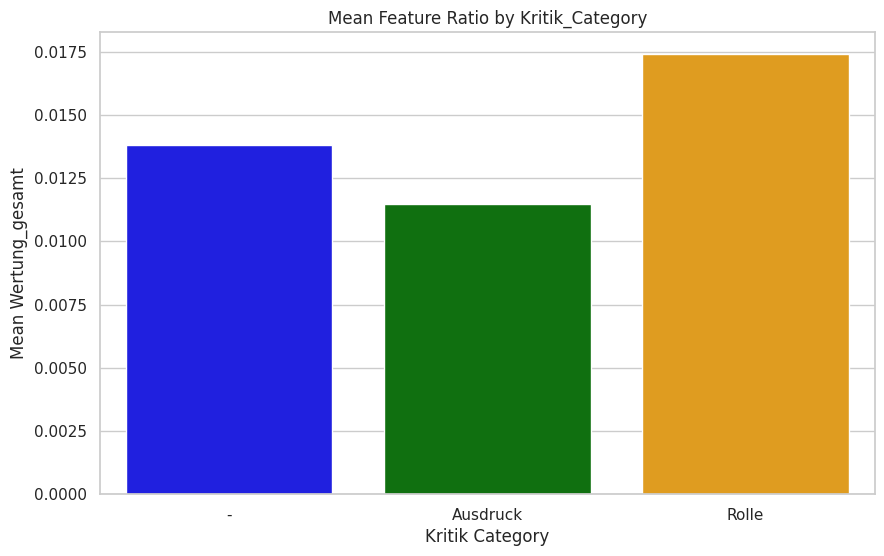

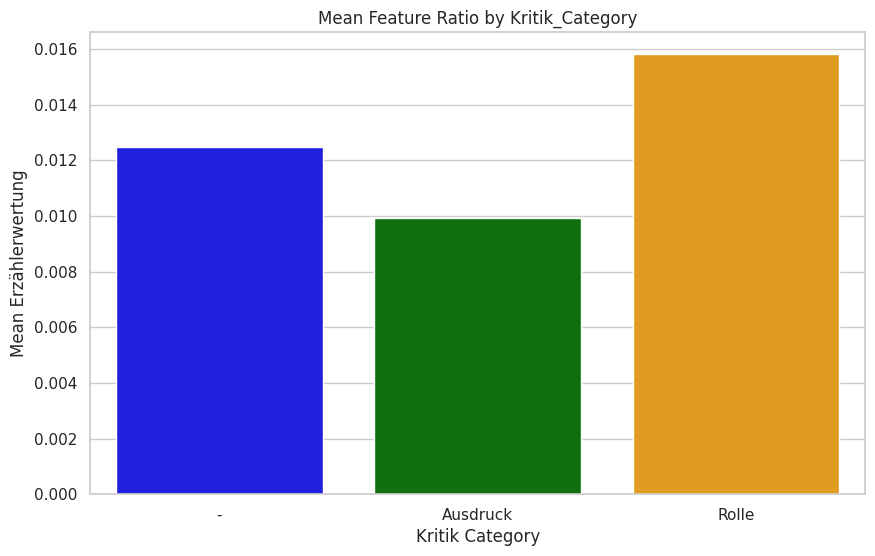

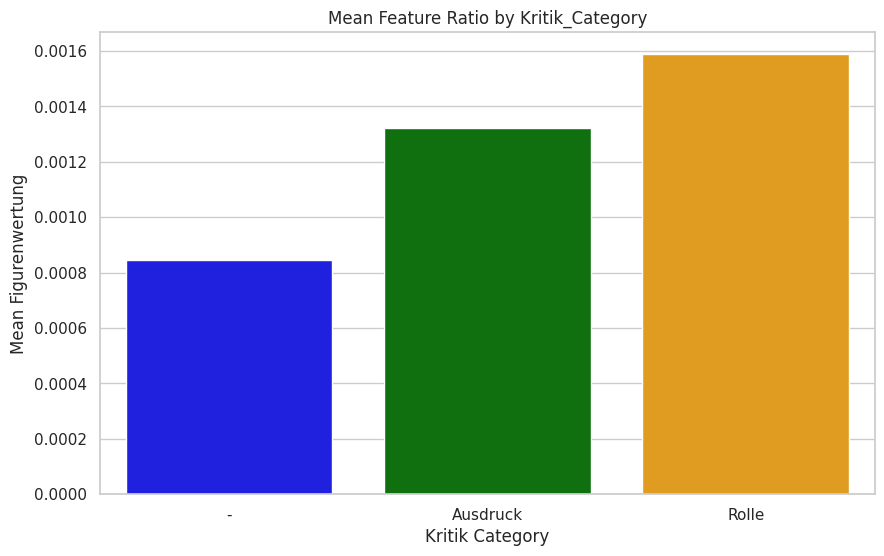

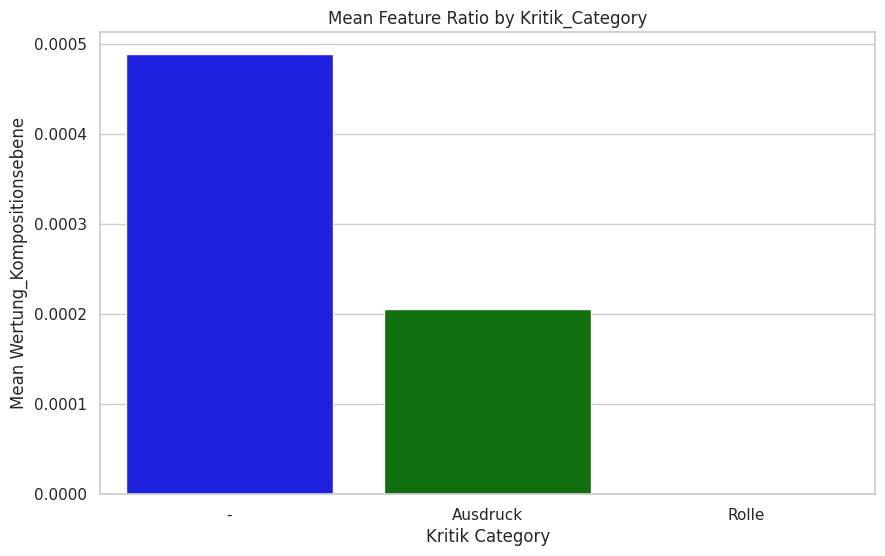

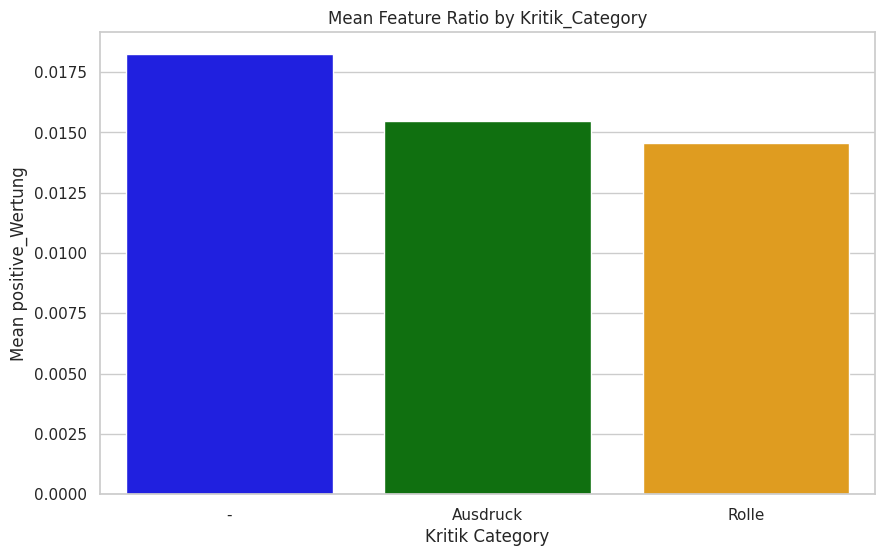

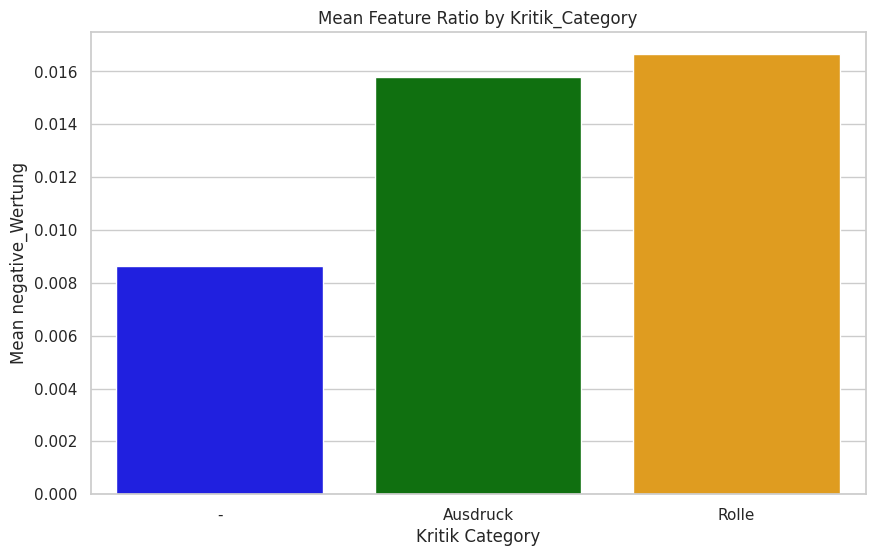

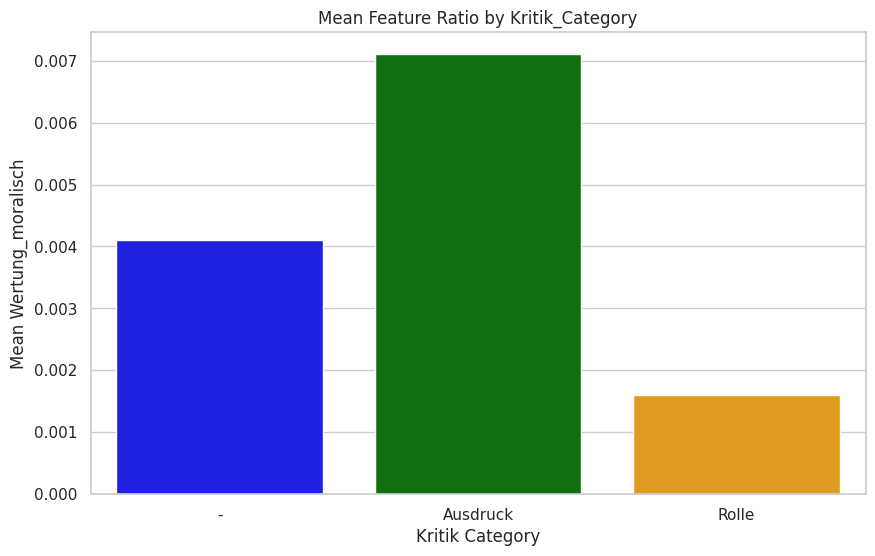

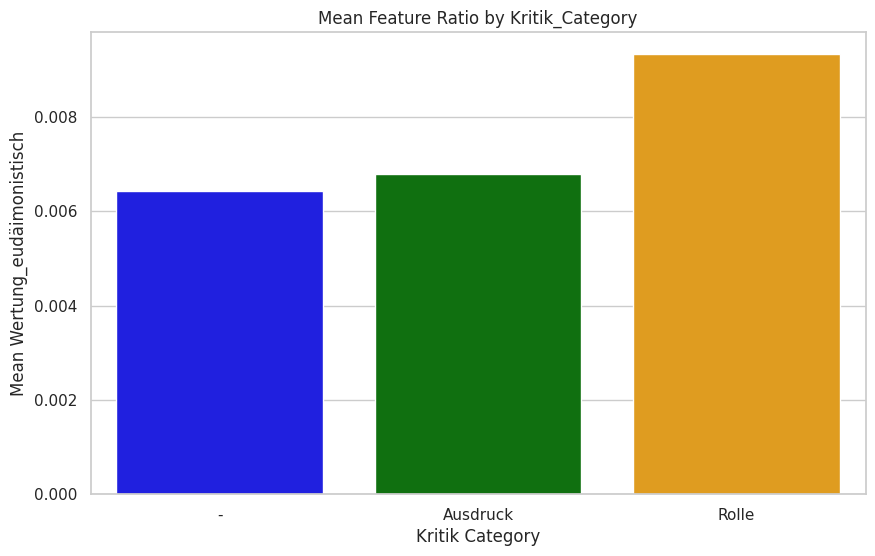

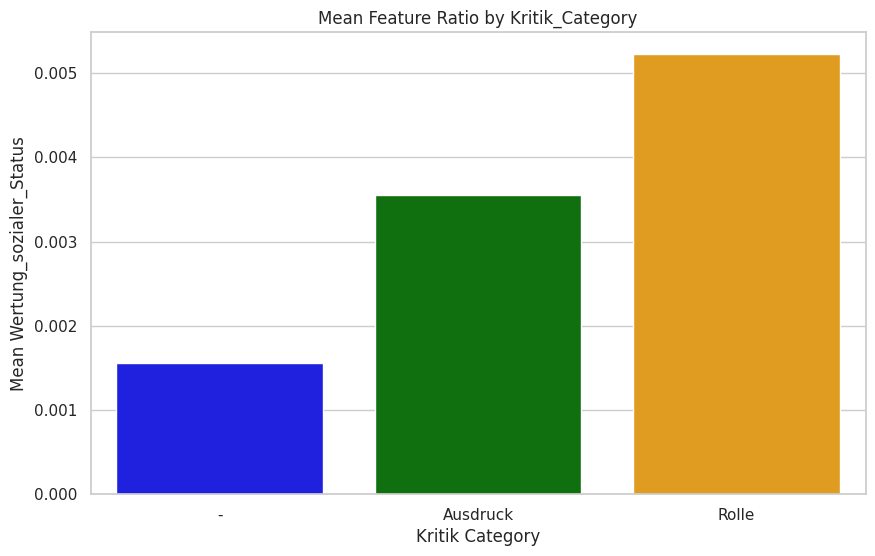

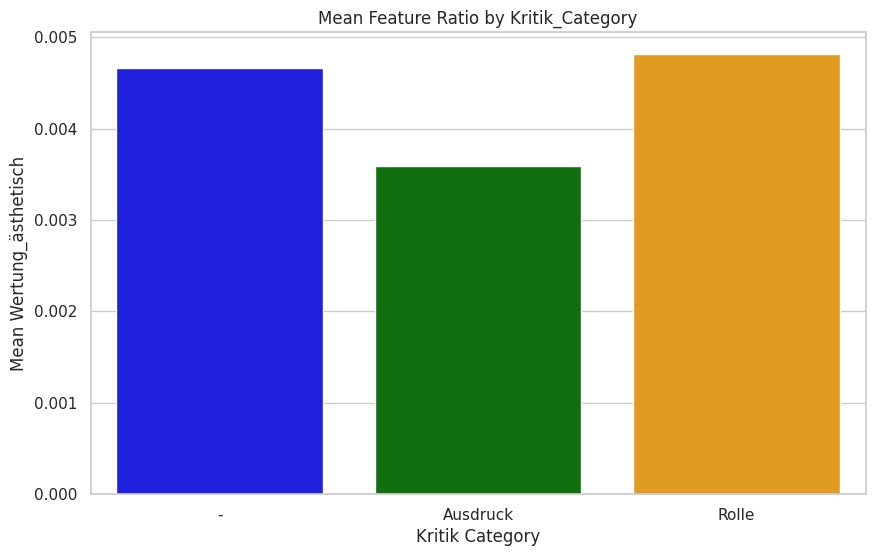

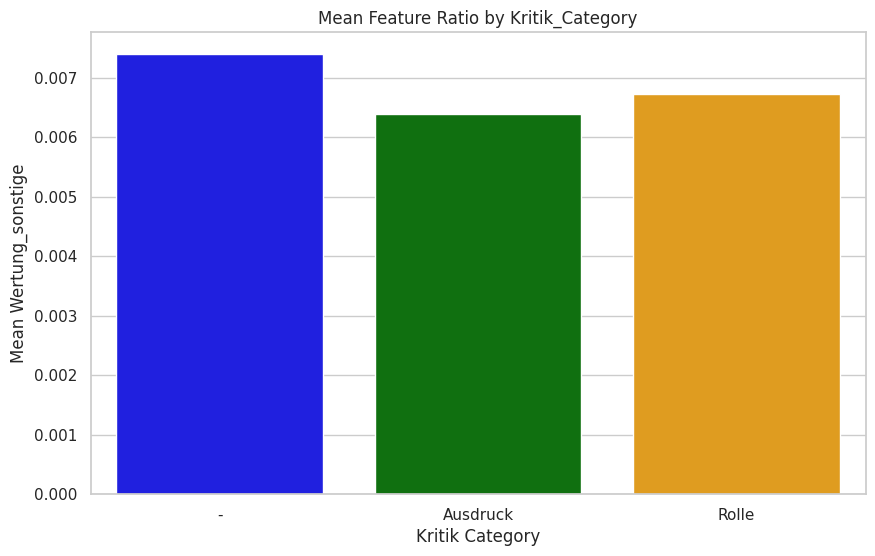

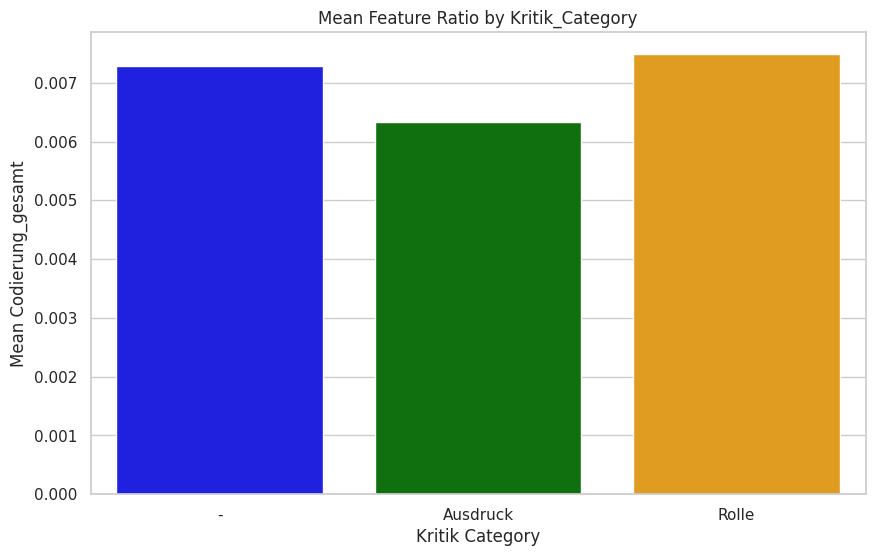

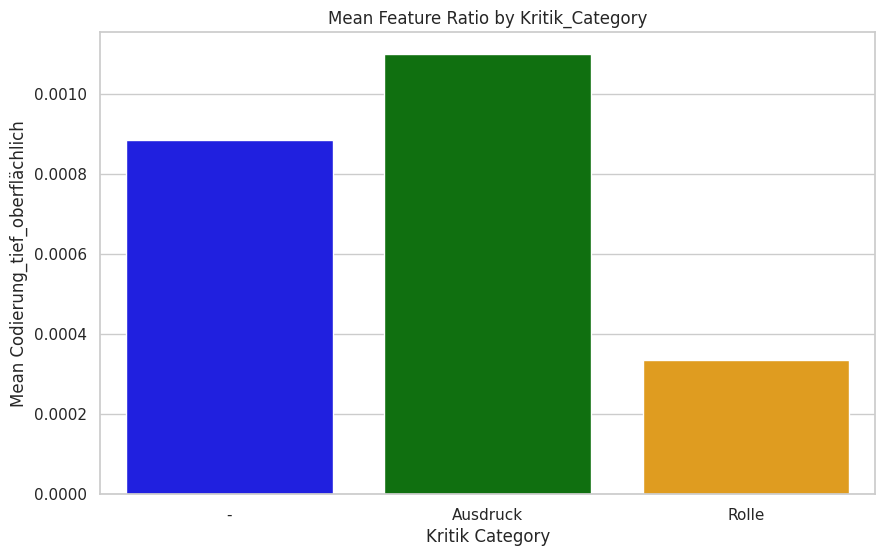

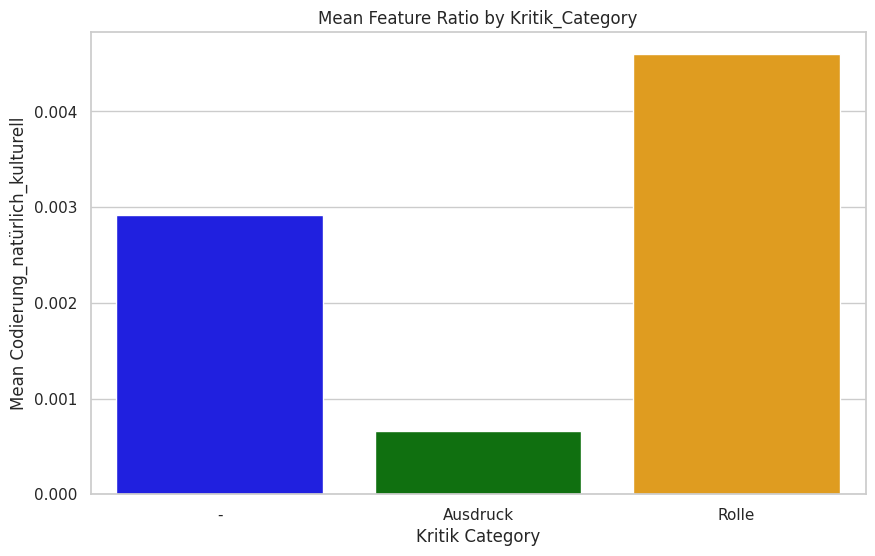

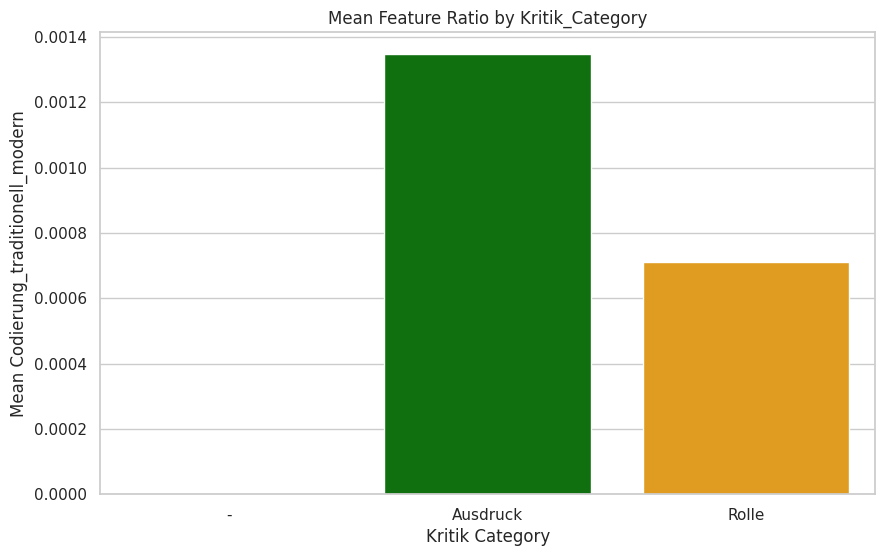

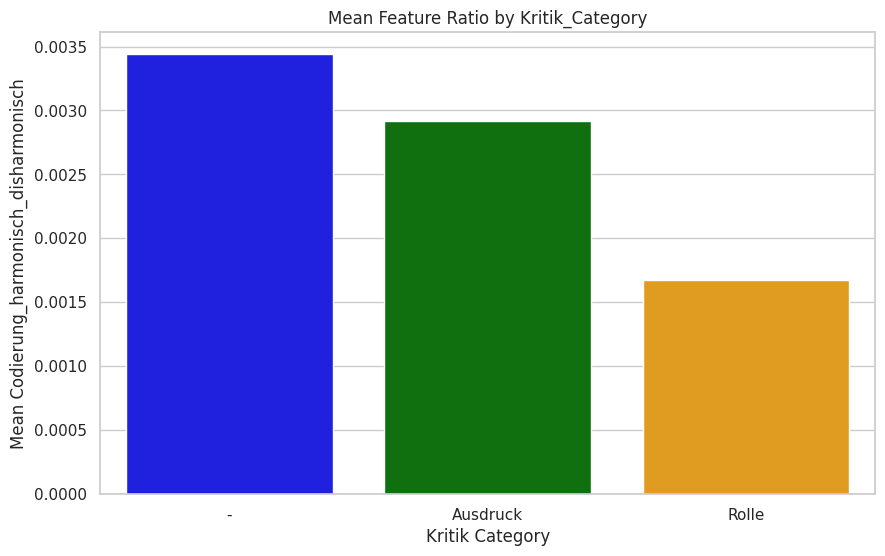

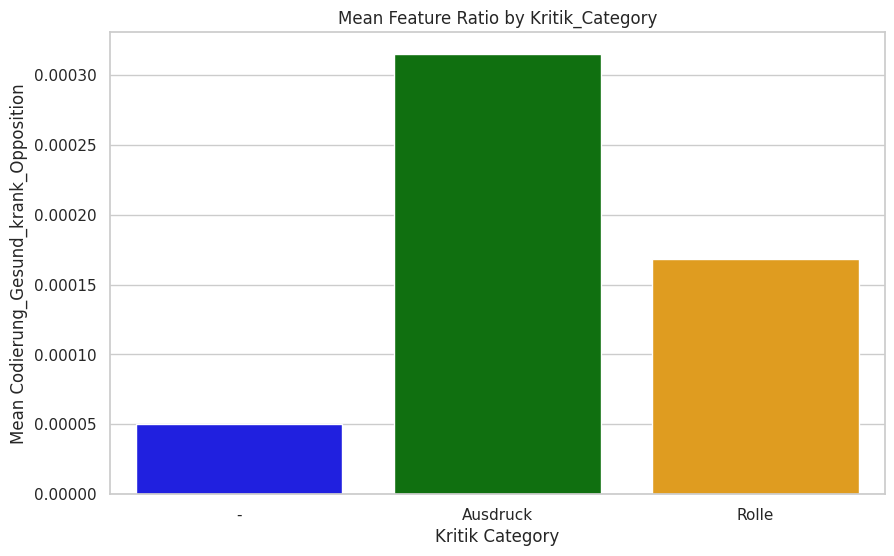

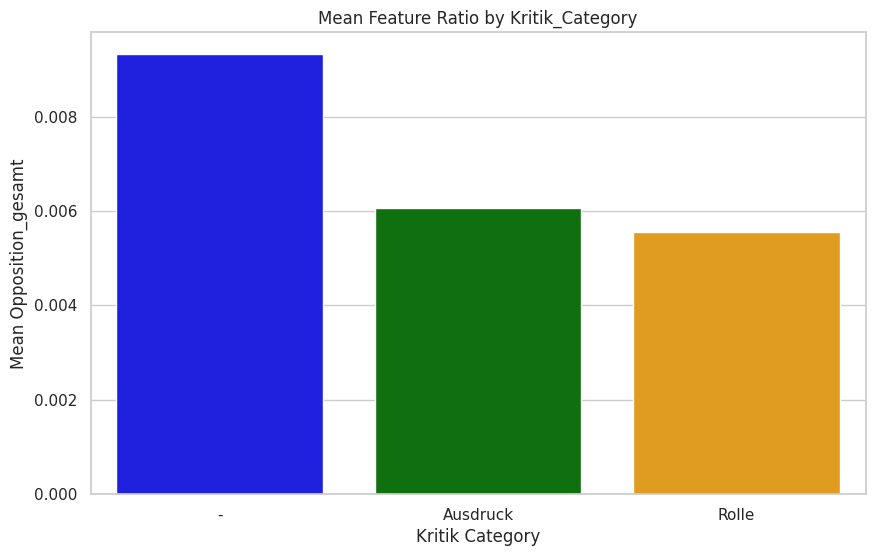

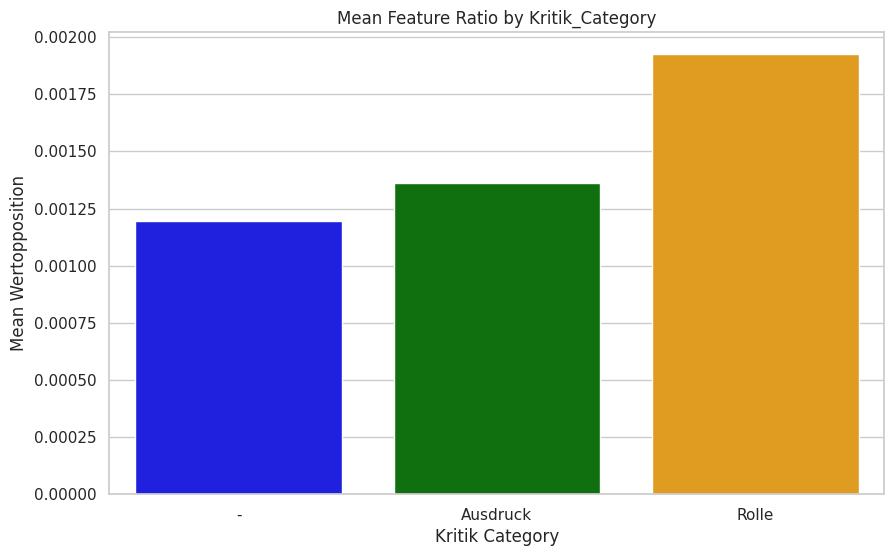

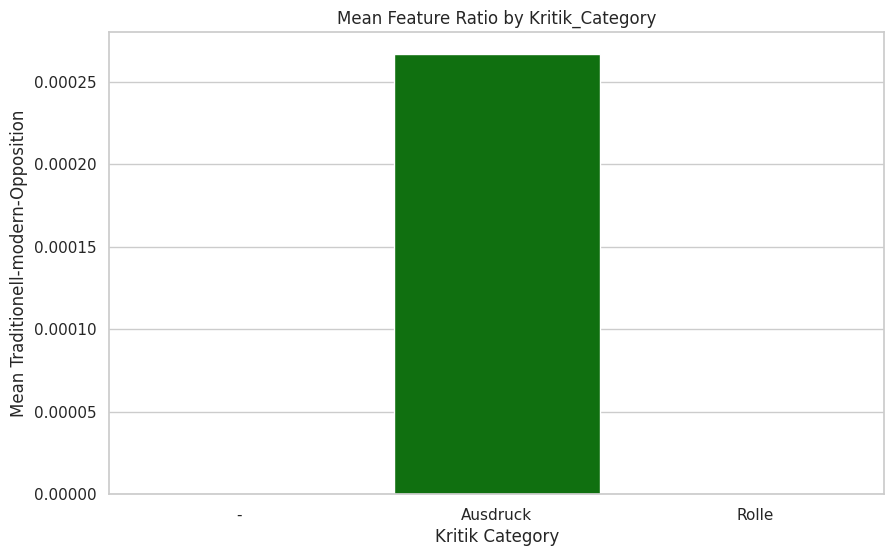

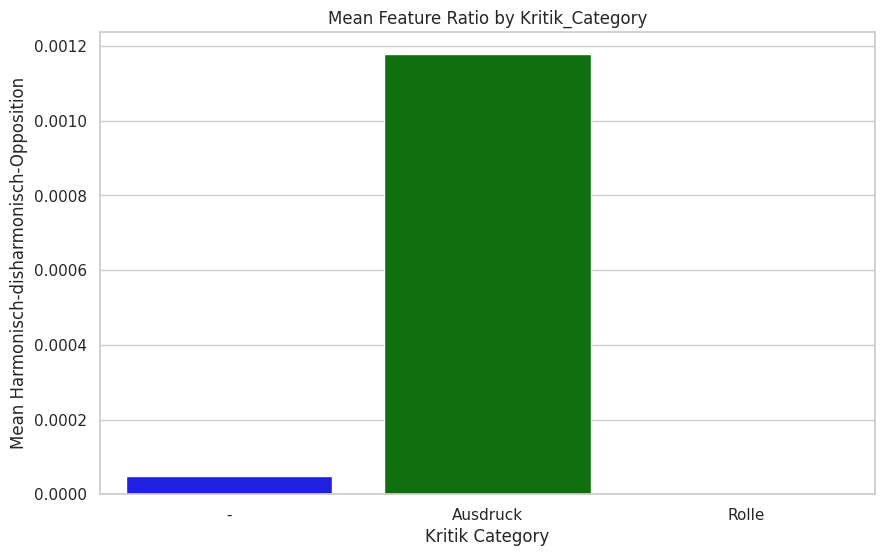

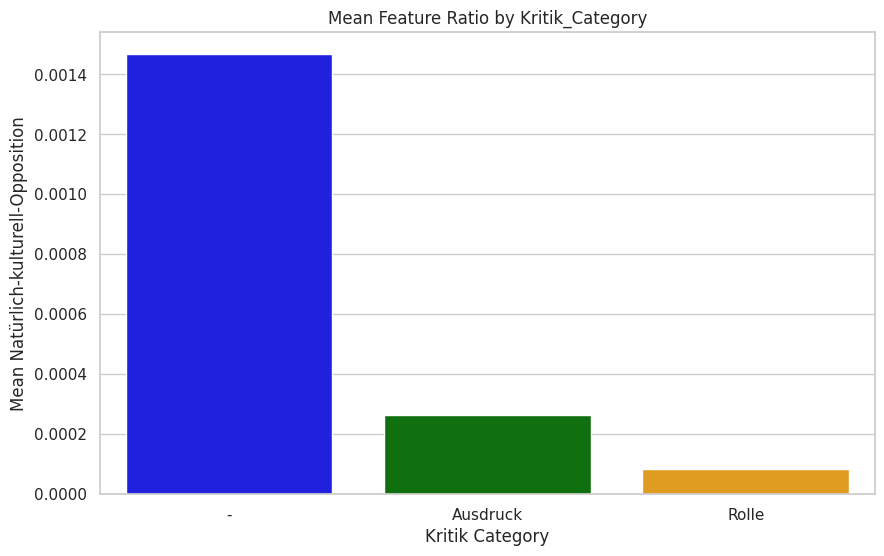

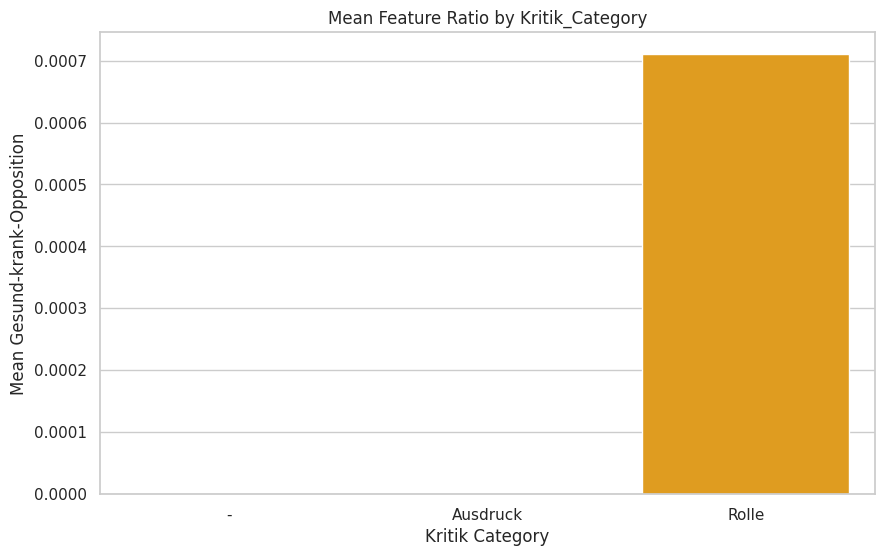

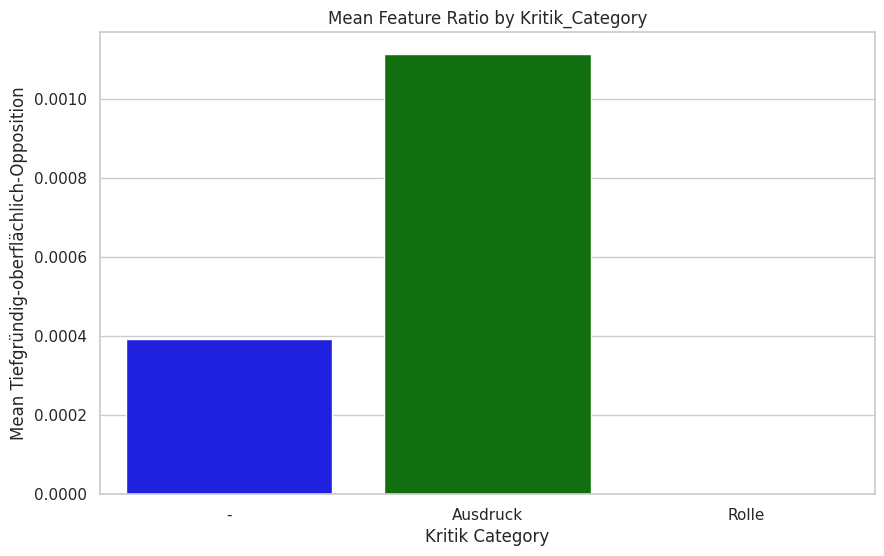

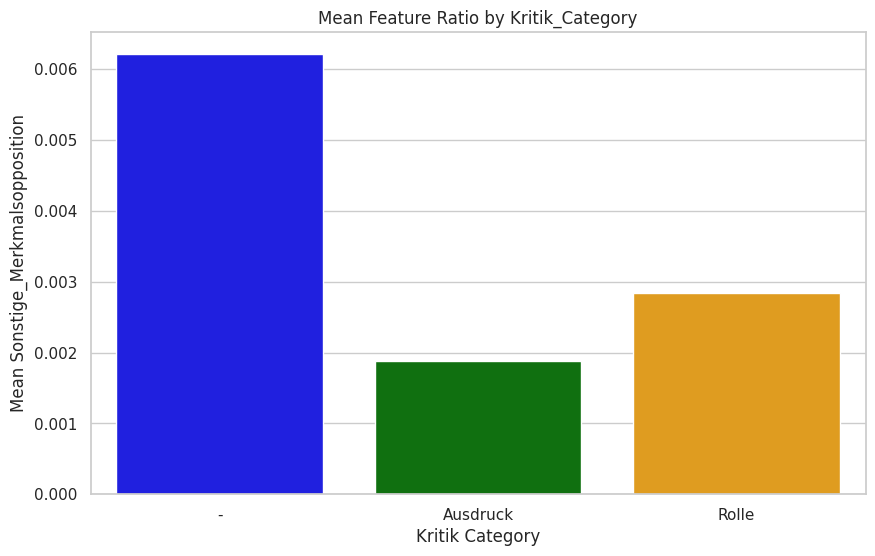

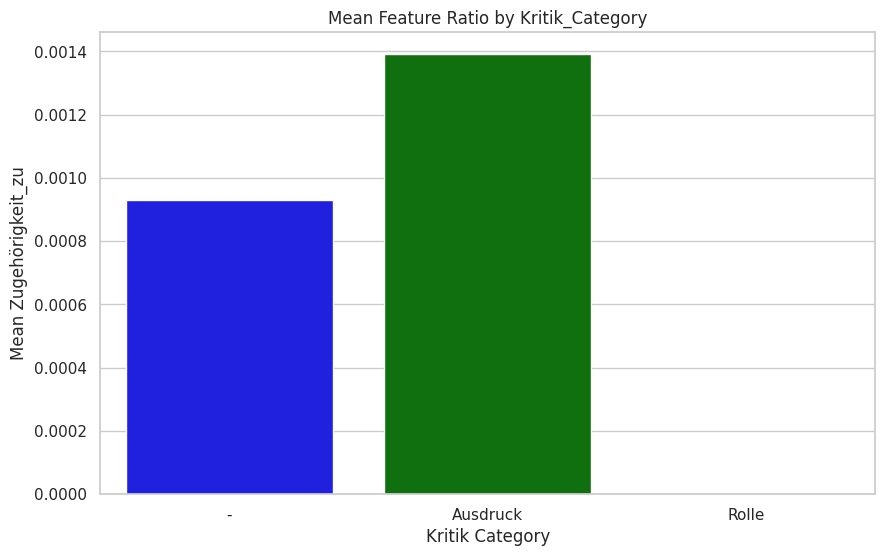

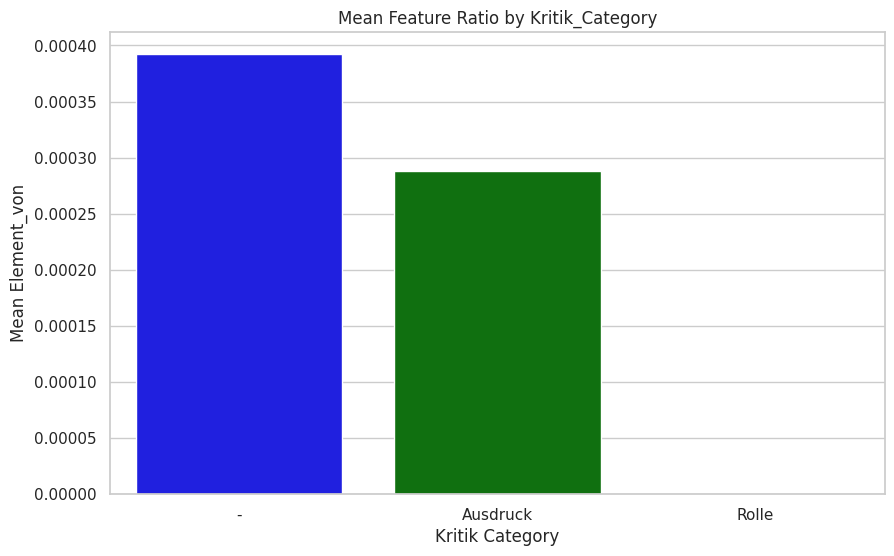

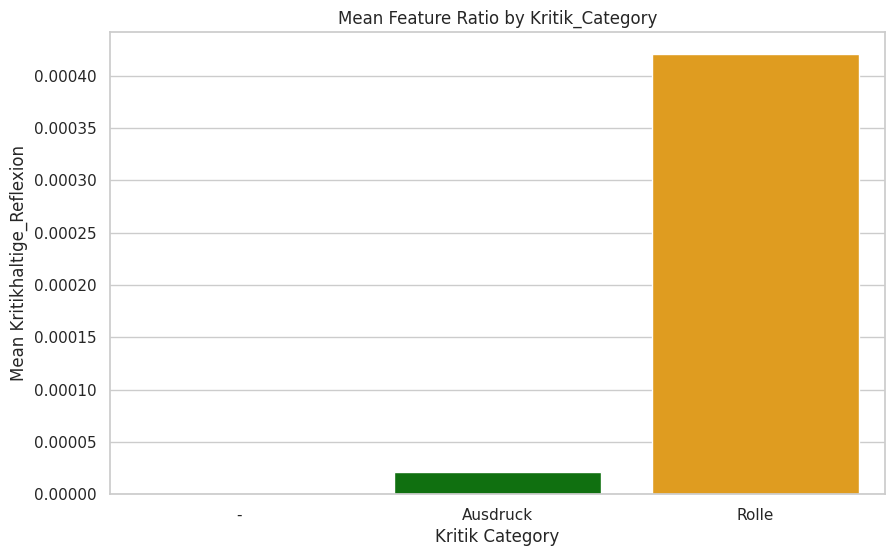

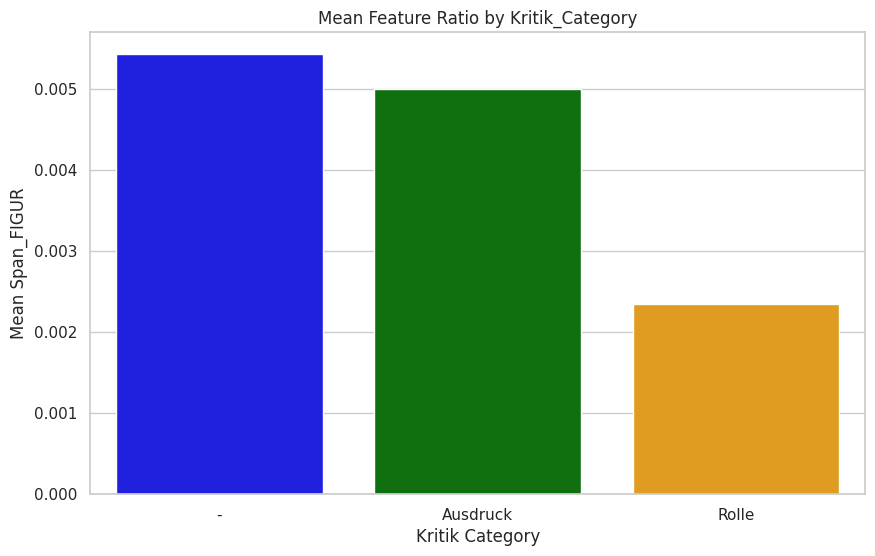

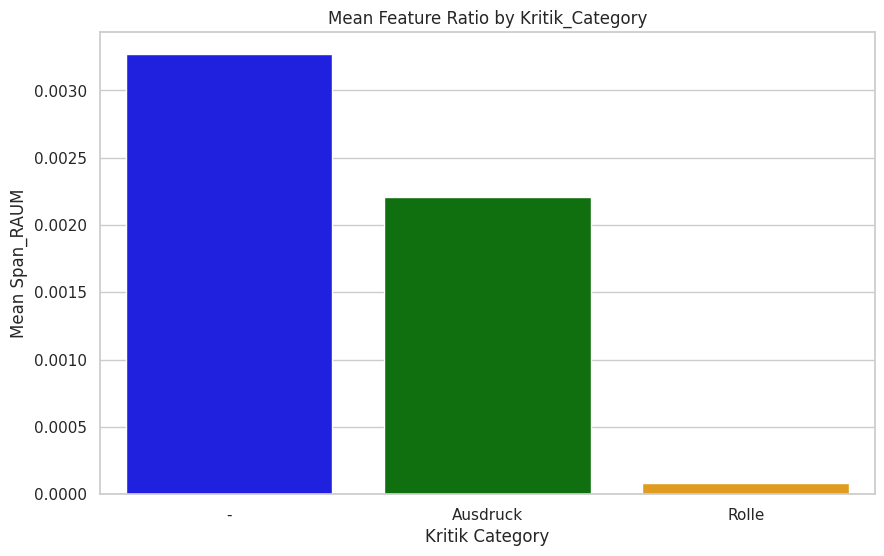

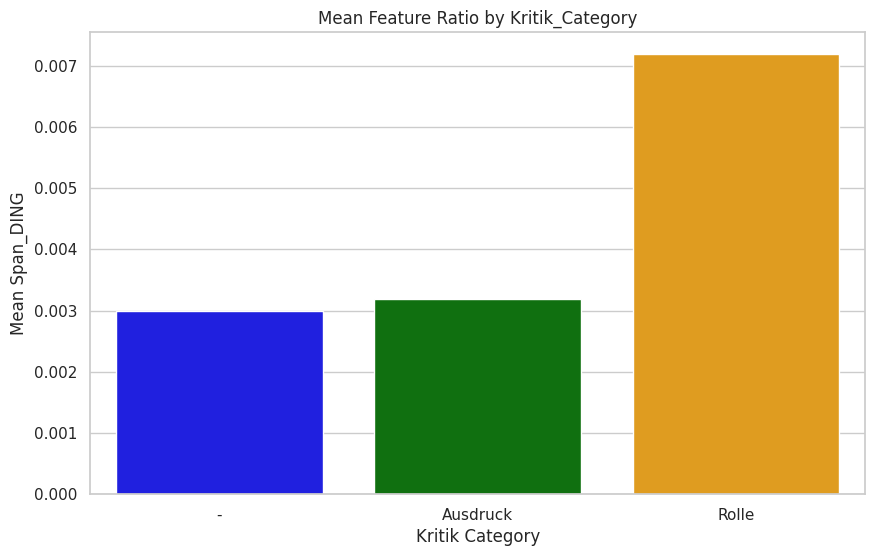

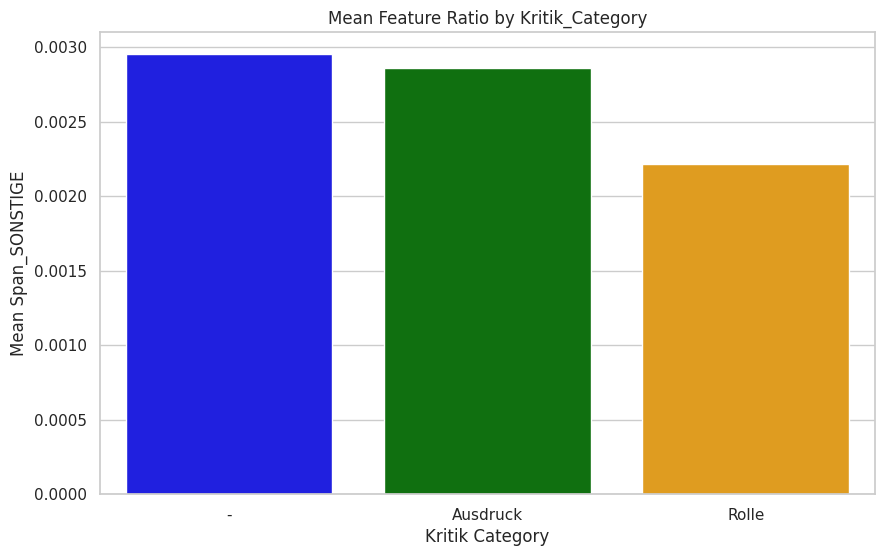

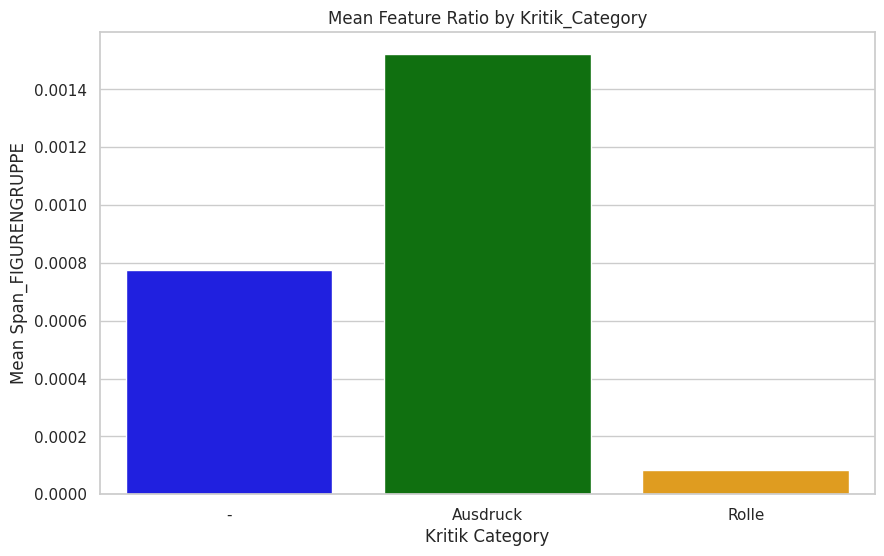

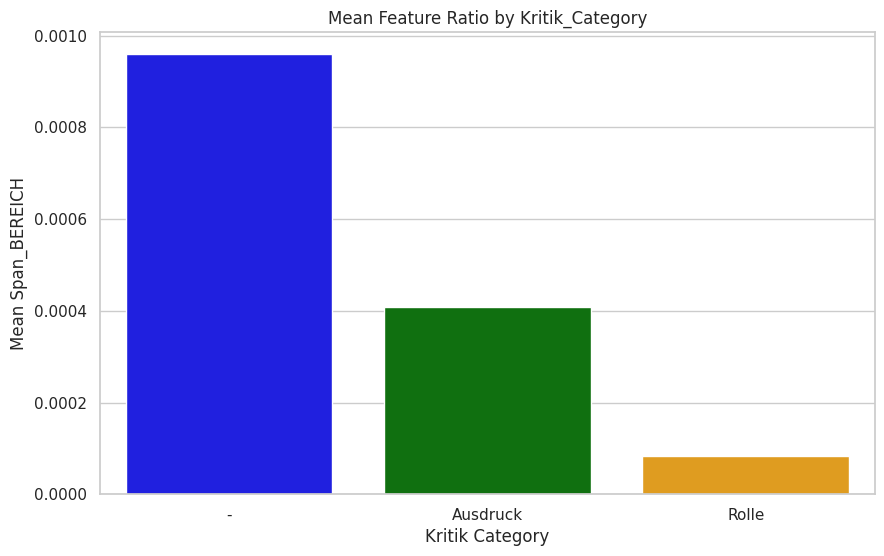

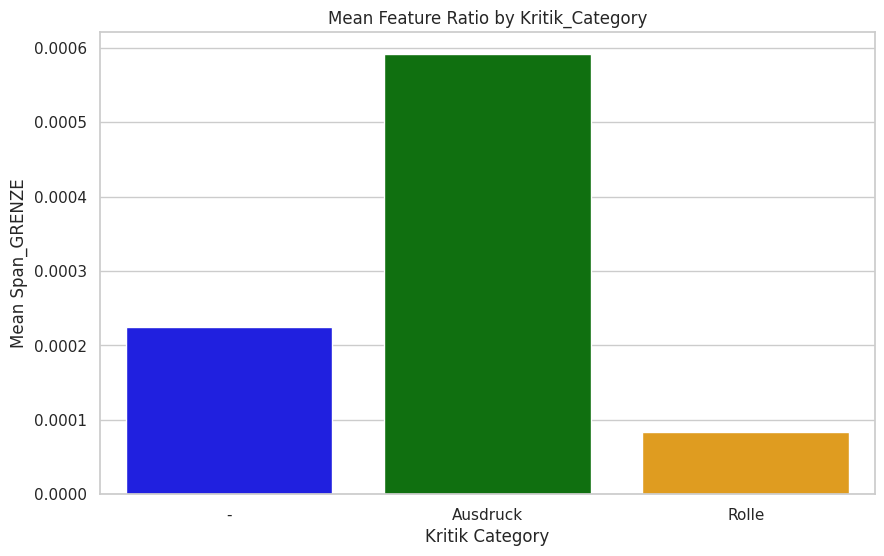

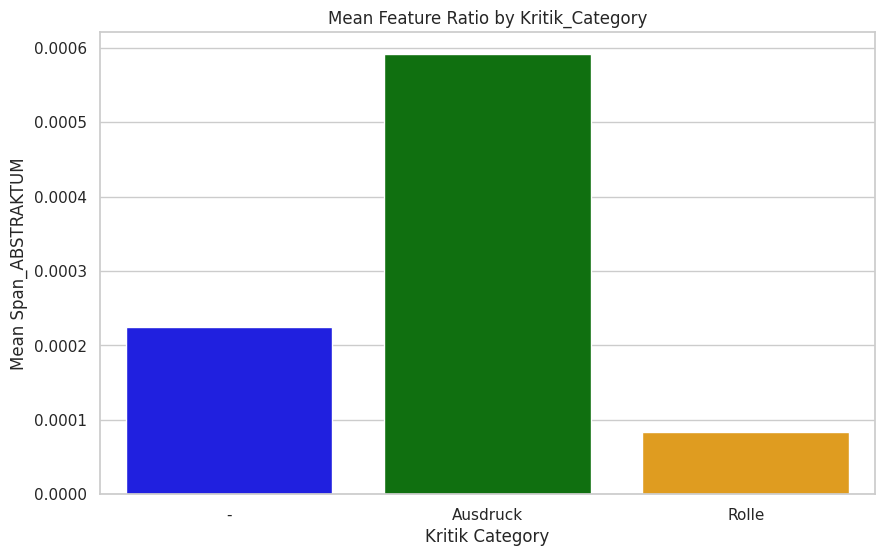

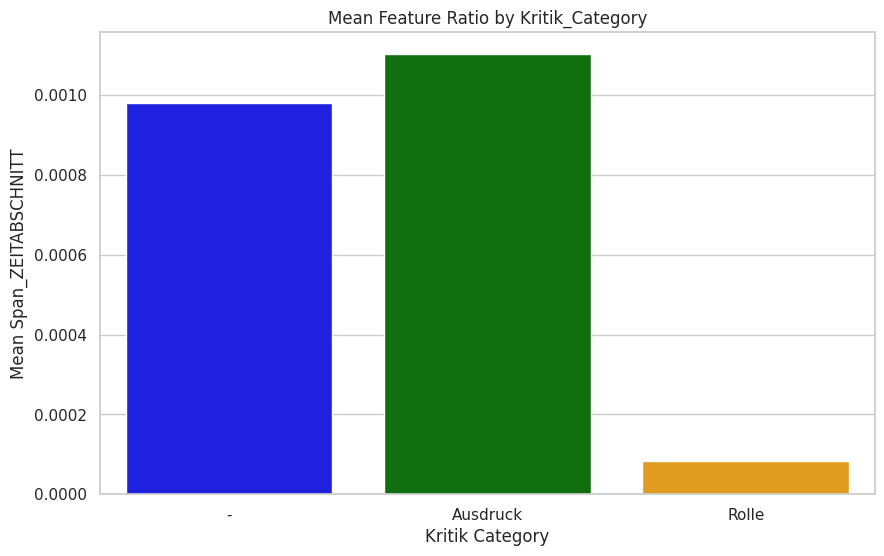

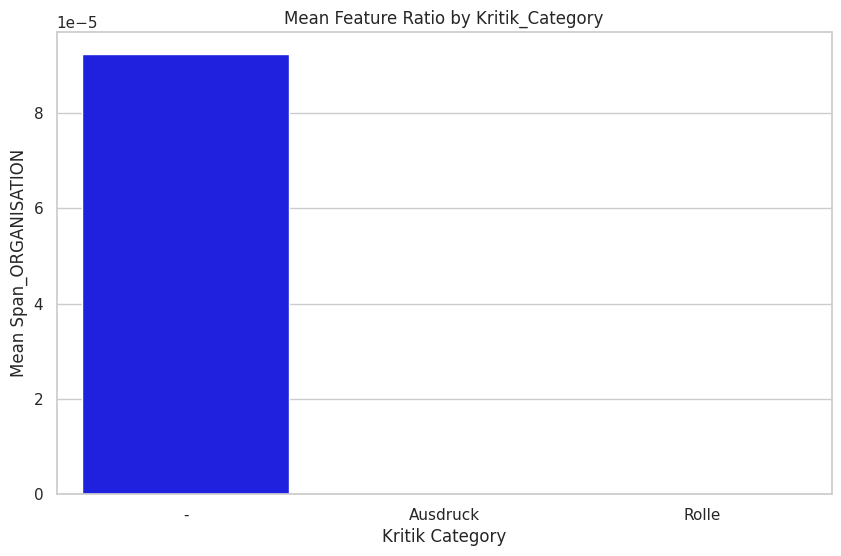

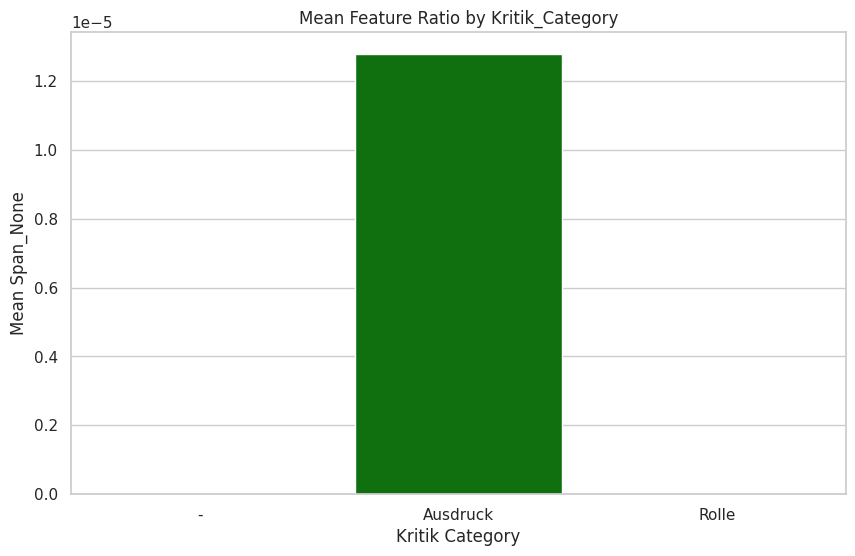

In [ ]:
#Charts for Kritik_Category
# Load data from CSV file
file_path = 'charts.csv'  # Replace with the actual path to your CSV file
df = pd.read_csv(file_path,encoding='ISO-8859-1')

categories=['Kritik_Category']

columns=['Wertung_gesamt',
'Erzählerwertung',
'Figurenwertung',
'Wertung_Kompositionsebene',
'positive_Wertung',
'negative_Wertung',
'Wertung_moralisch',
'Wertung_eudäimonistisch',
'Wertung_sozialer_Status',
'Wertung_ästhetisch',
'Wertung_sonstige',
'Codierung_gesamt',
'Codierung_tief_oberflächlich',
'Codierung_natürlich_kulturell',
'Codierung_traditionell_modern',
'Codierung_harmonisch_disharmonisch',
'Codierung_Gesund_krank',
'Opposition_gesamt',
'Wertopposition',
'Traditionell-modern-Opposition',
'Harmonisch-disharmonisch-Opposition',
'Natürlich-kulturell-Opposition',
'Gesund-krank-Opposition',
'Tiefgründig-oberflächlich-Opposition',
'Sonstige_Merkmalsopposition',
'Zugehörigkeit_zu',
'Element_von',
'Kritikhaltige_Reflexion',
'Span_FIGUR',
'Span_RAUM',
'Span_DING',
'Span_SONSTIGE',
'Span_FIGURENGRUPPE',
'Span_BEREICH',
'Span_GRENZE',
'Span_ABSTRAKTUM',
'Span_ZEITABSCHNITT',
'Span_ORGANISATION',
'Span_None'
]

# Define directory to save charts
save_dir = 'charts_directory'  # Replace with the desired directory name
os.makedirs(save_dir, exist_ok=True)  # Create directory if it doesn't exist


for category in categories:
  print('Charts for ',category)
  for column in columns:
    # Group by 'Category' and calculate the mean
    mean_values = df.groupby(categories)[column].mean().reset_index()

    # Plotting the data with Seaborn
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x=category, y=column, hue=category, data=mean_values, palette=['blue', 'green', 'orange'], legend=False)
    x_label = 'Mean Feature Ratio by ' + category
    ax.set_title(x_label)
    y_label='Mean ' + column
    ax.set_ylabel(y_label)
    ax.set_xlabel('Kritik Category')
    plt.show()
    print('\n')


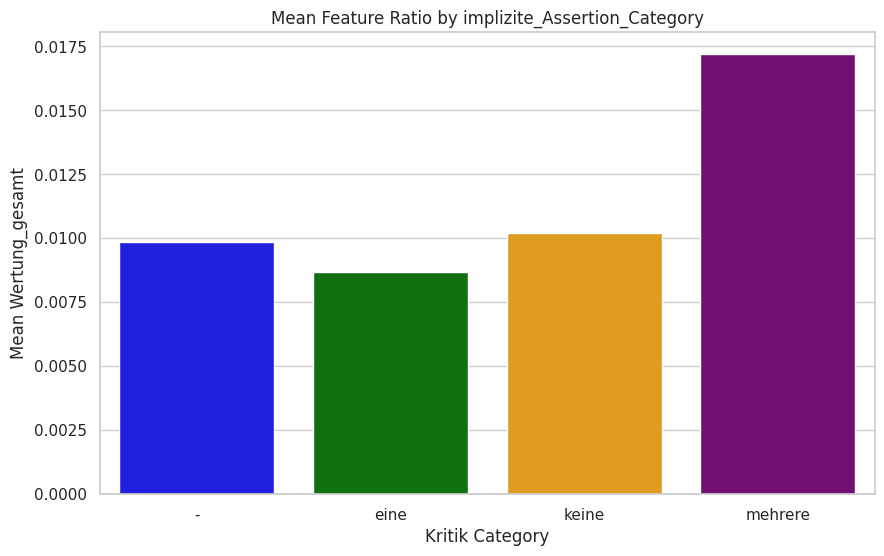

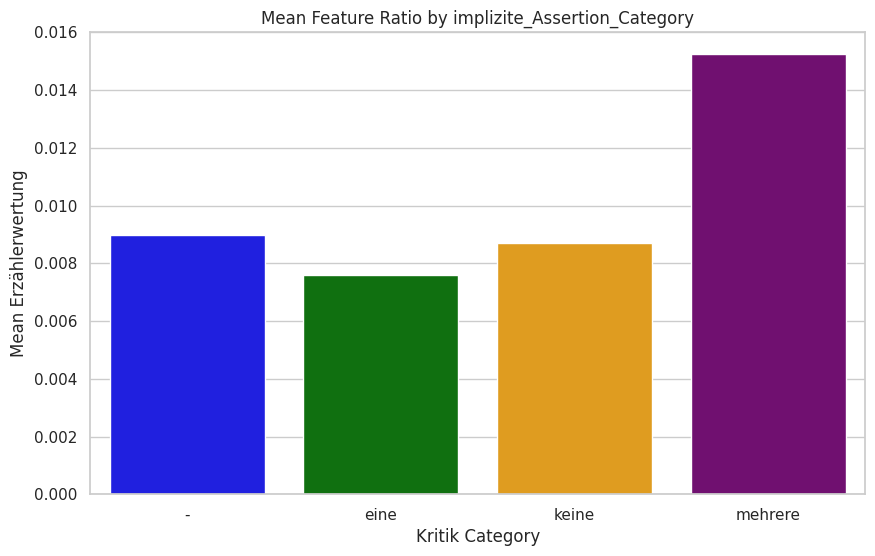

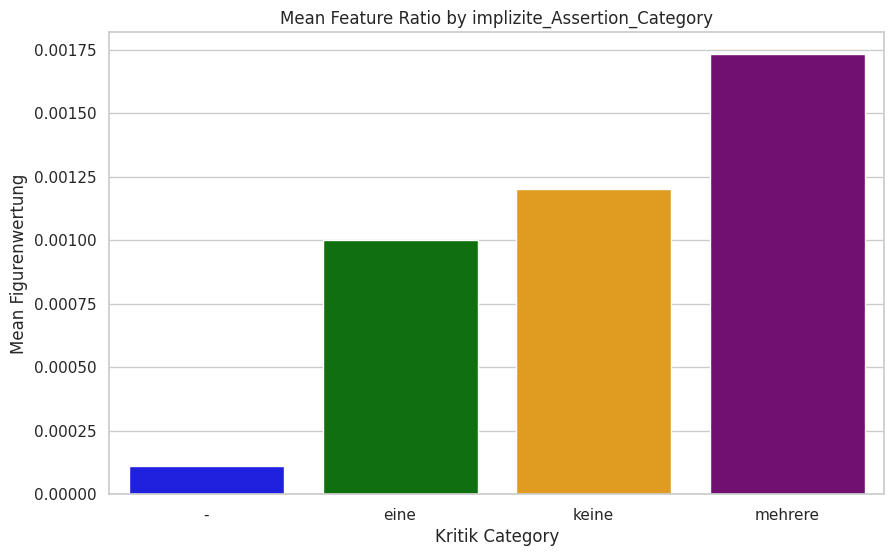

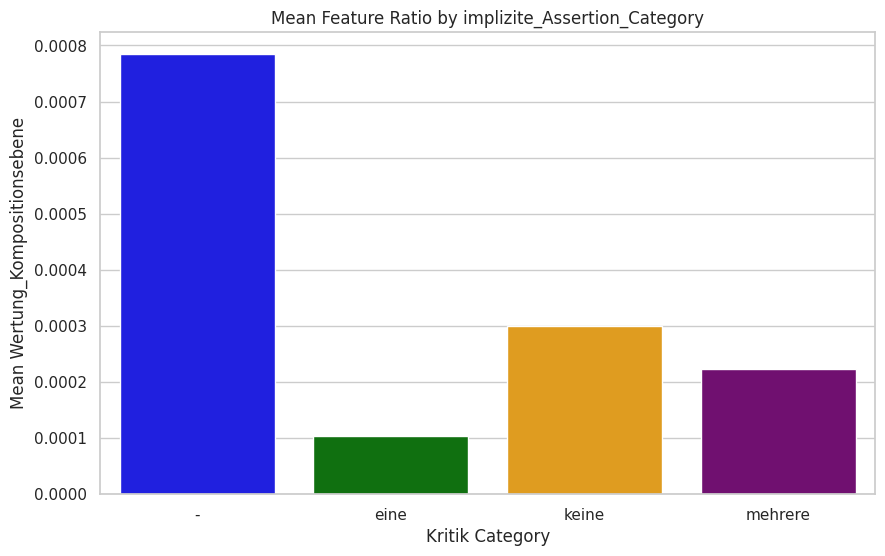

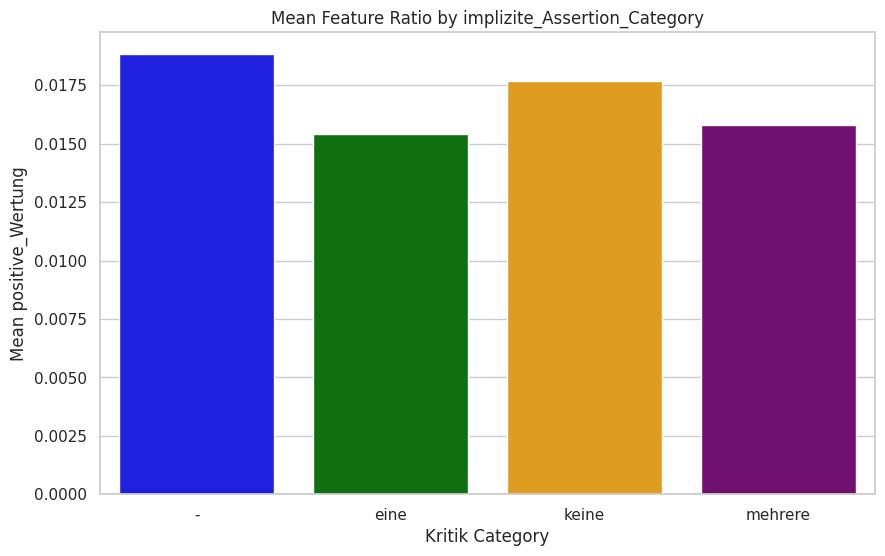

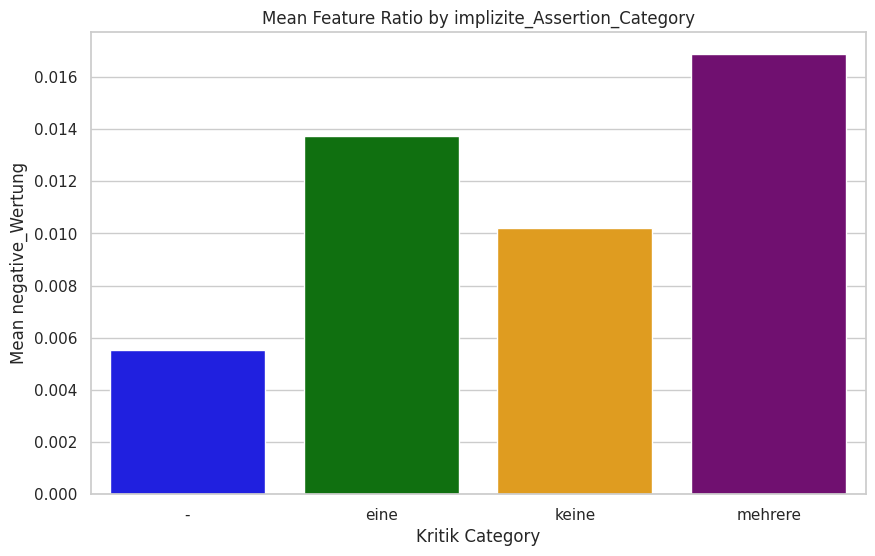

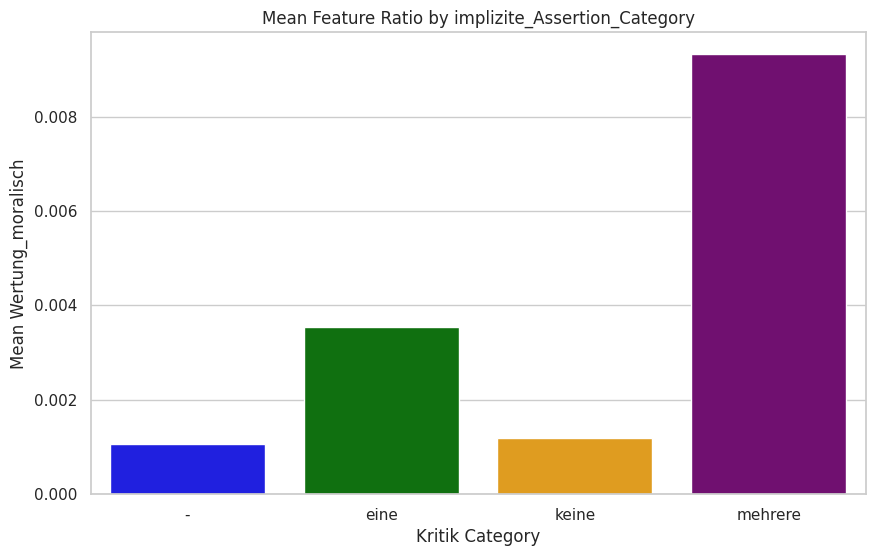

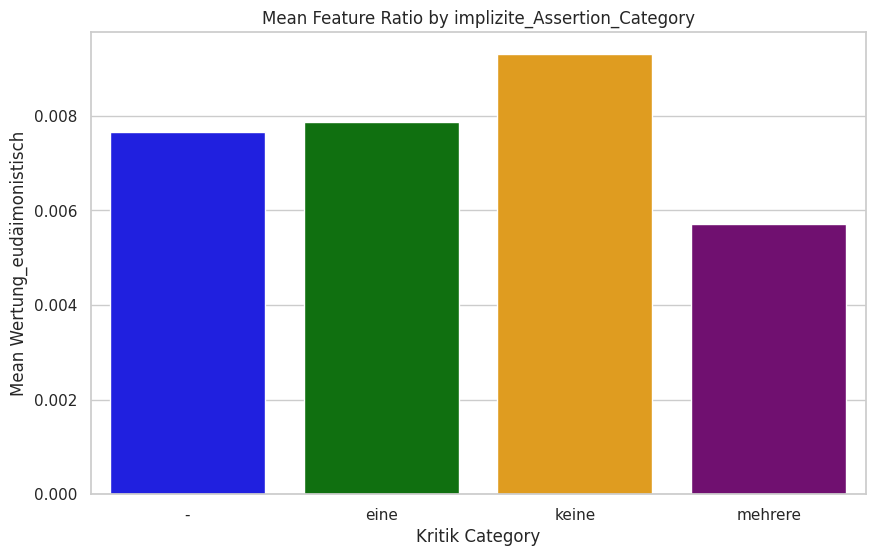

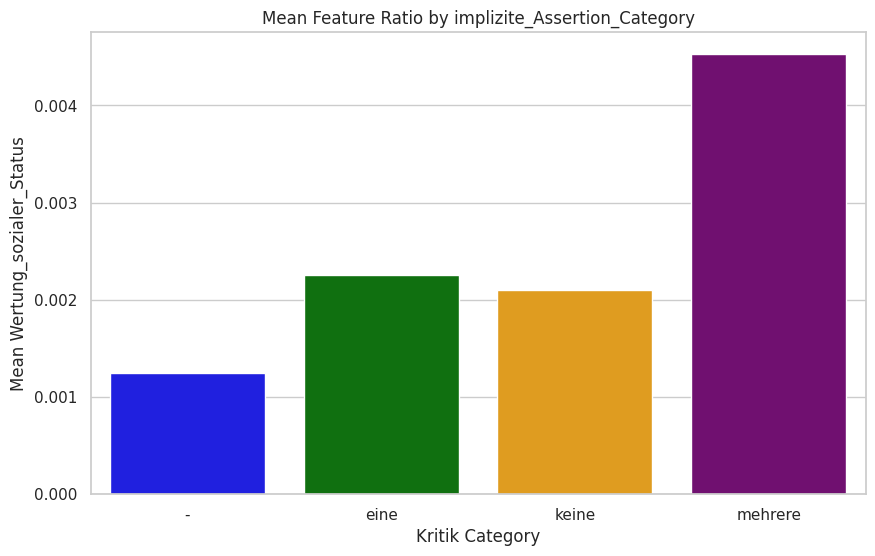

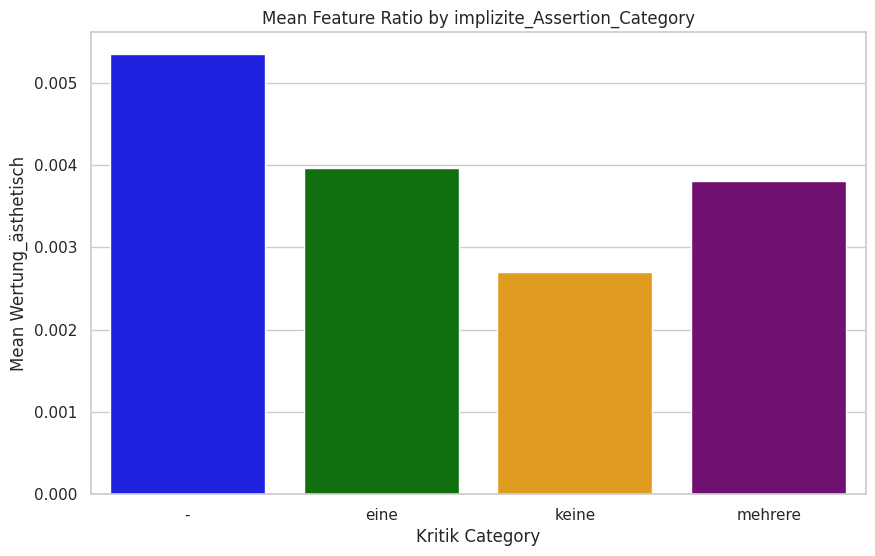

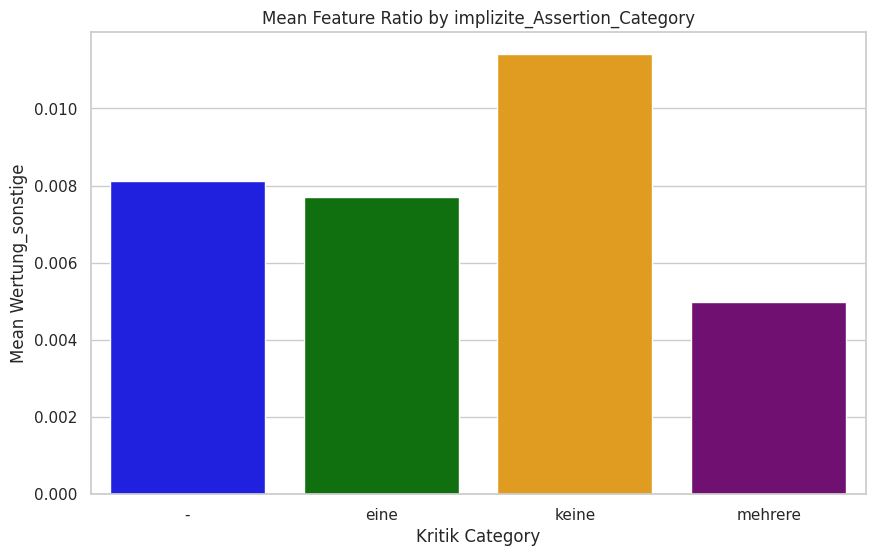

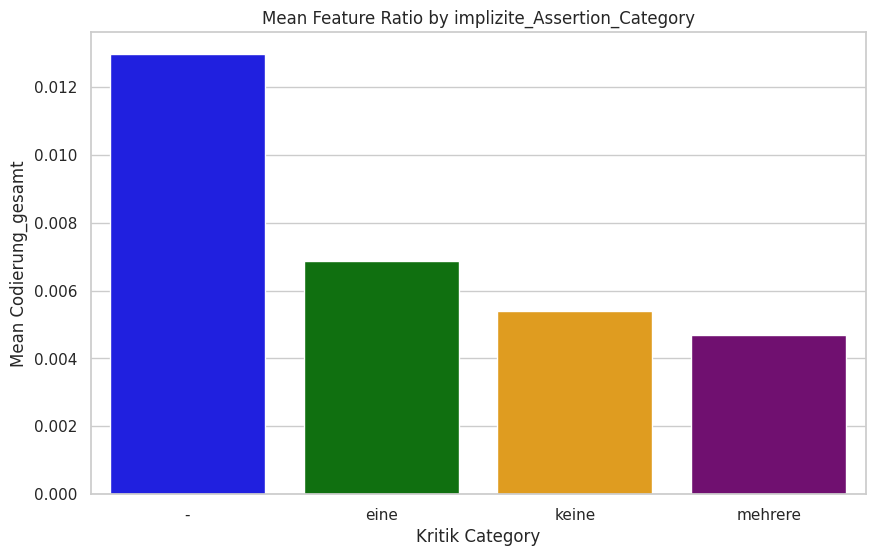

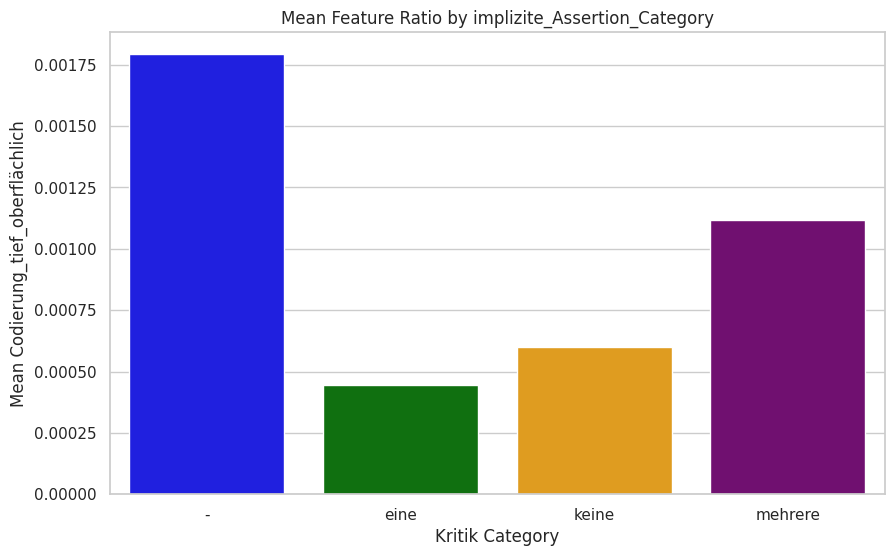

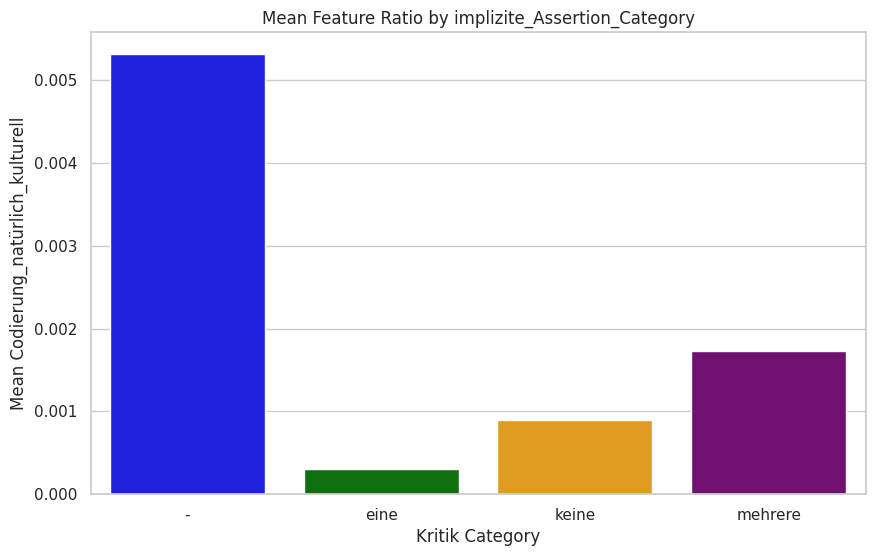

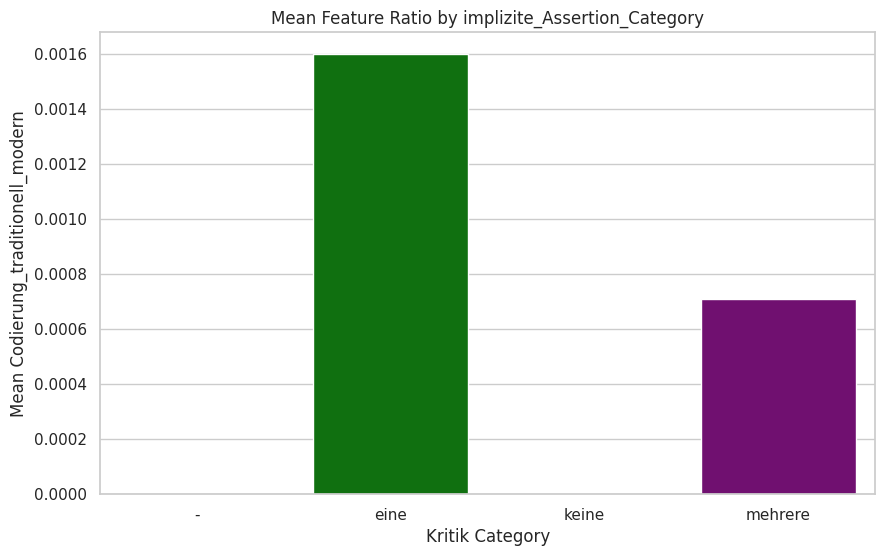

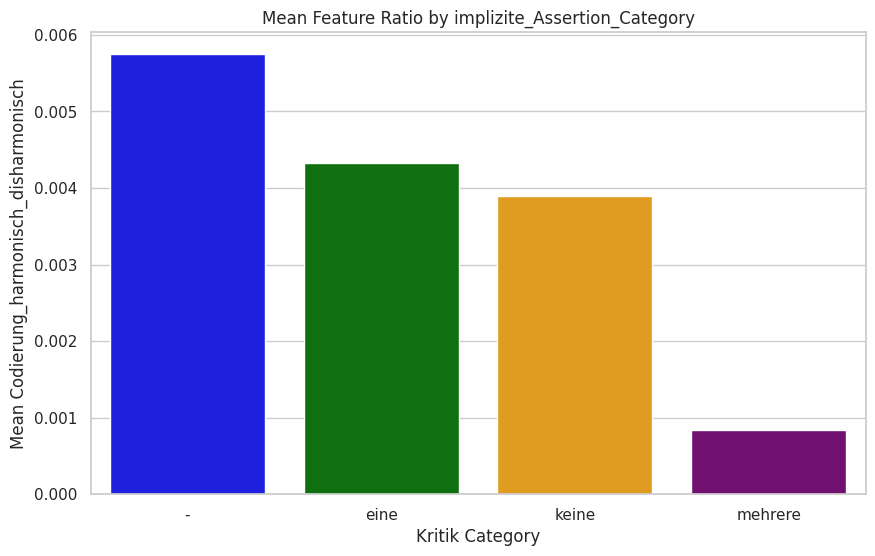

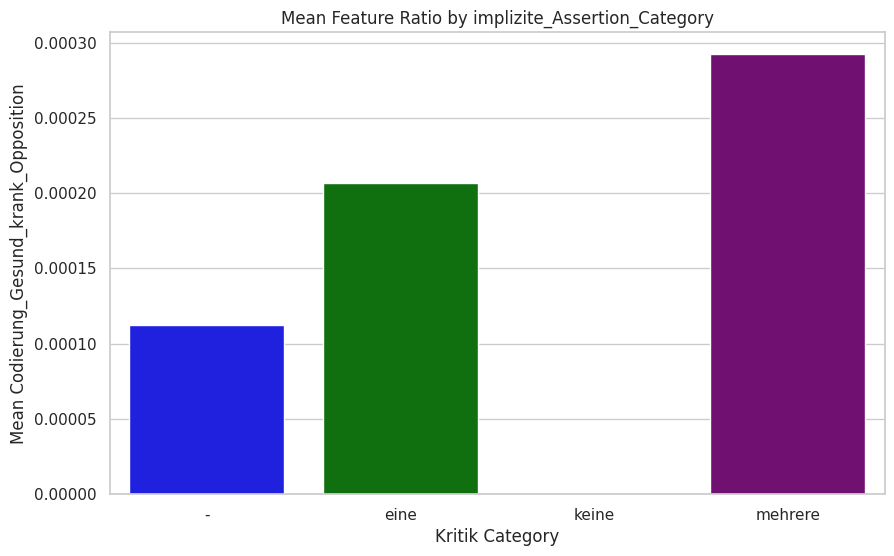

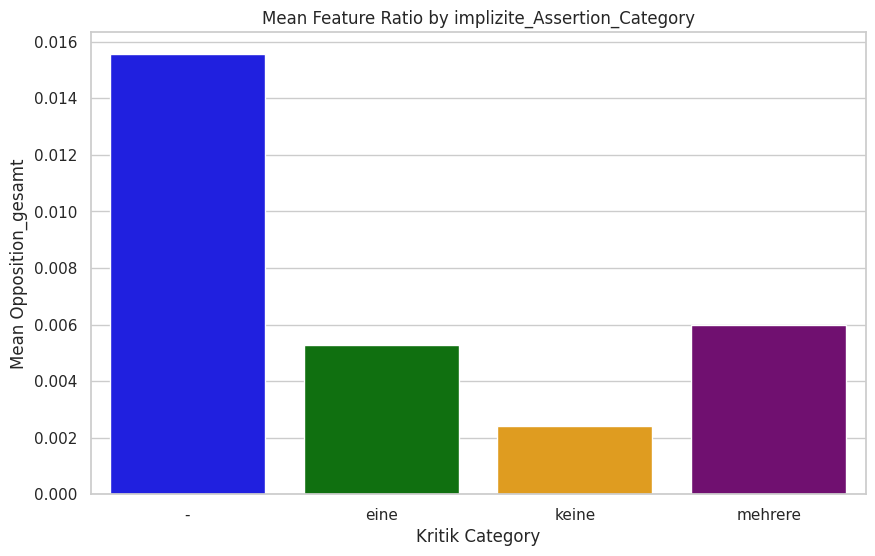

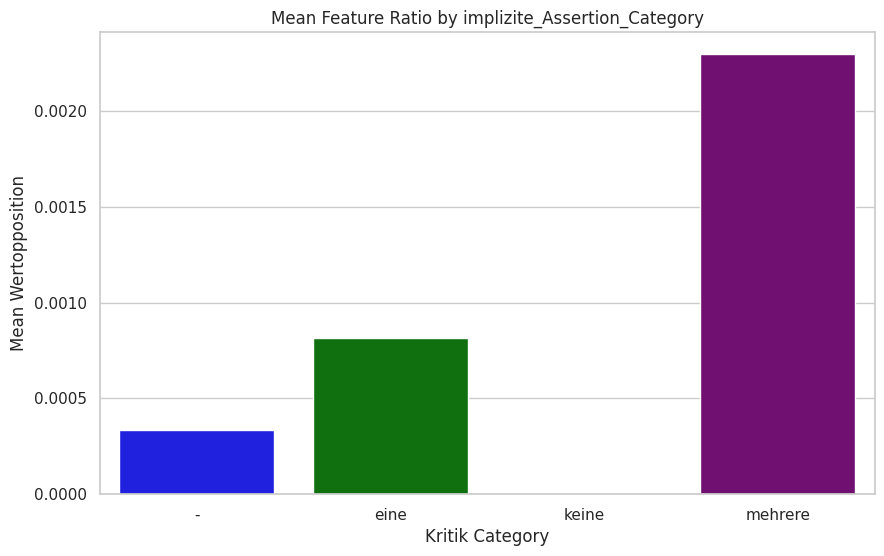

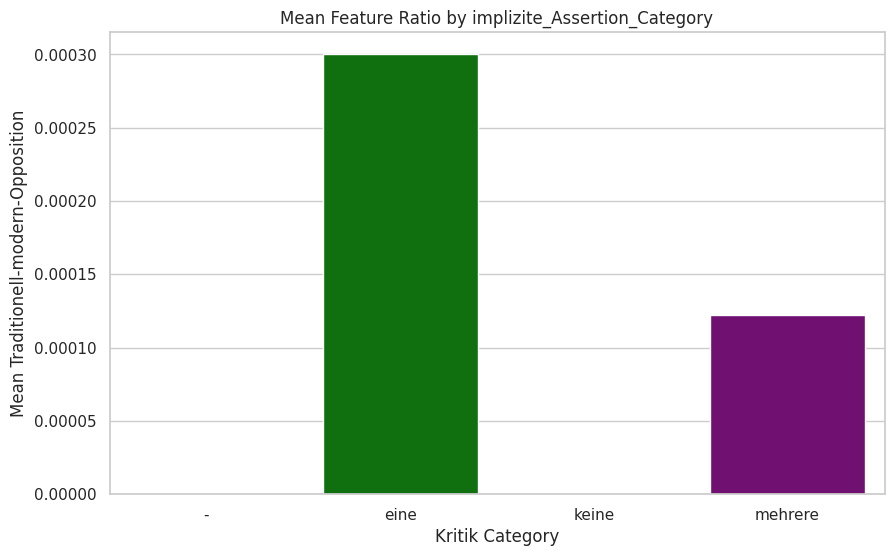

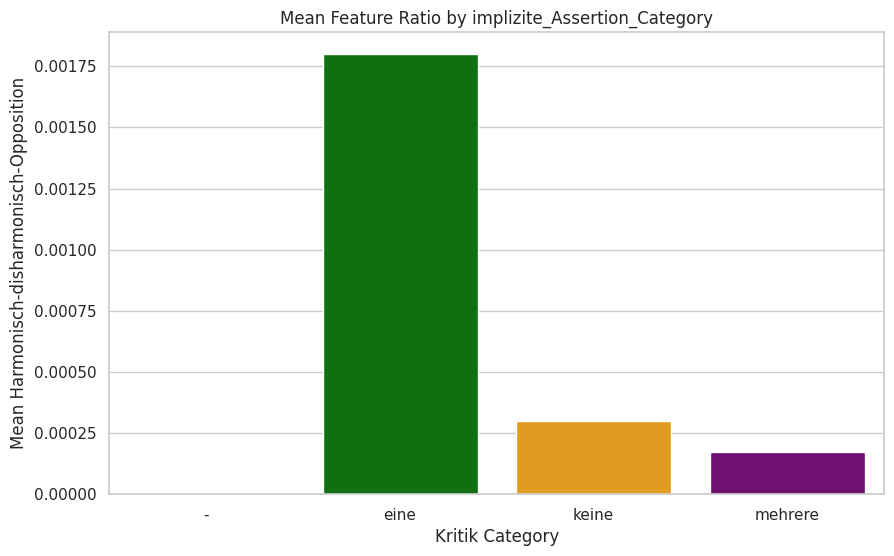

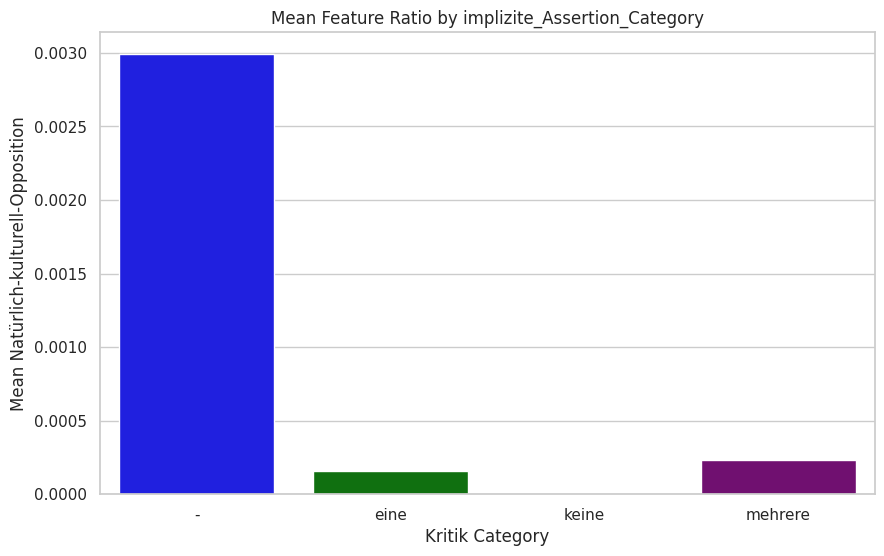

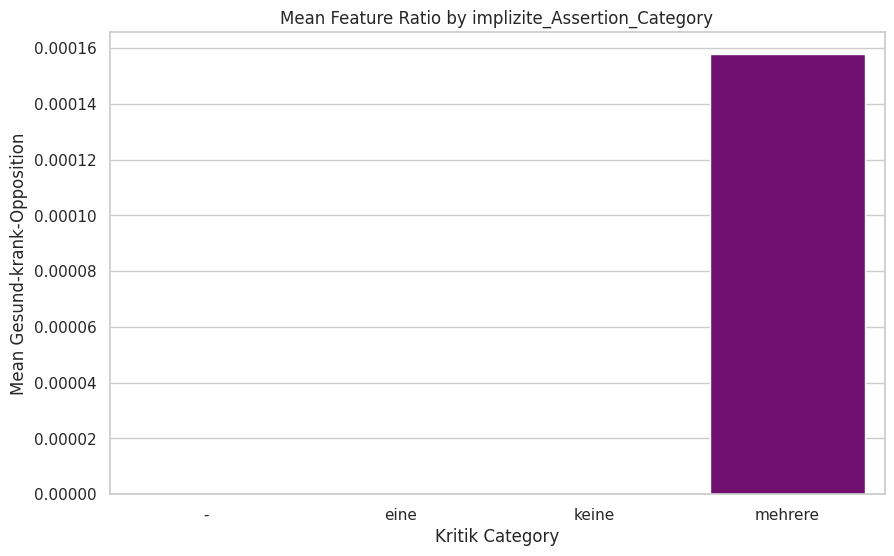

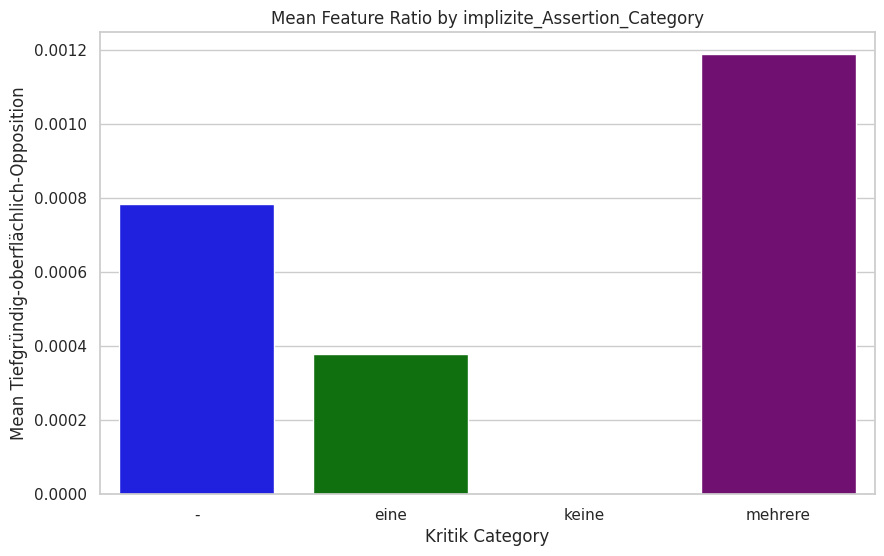

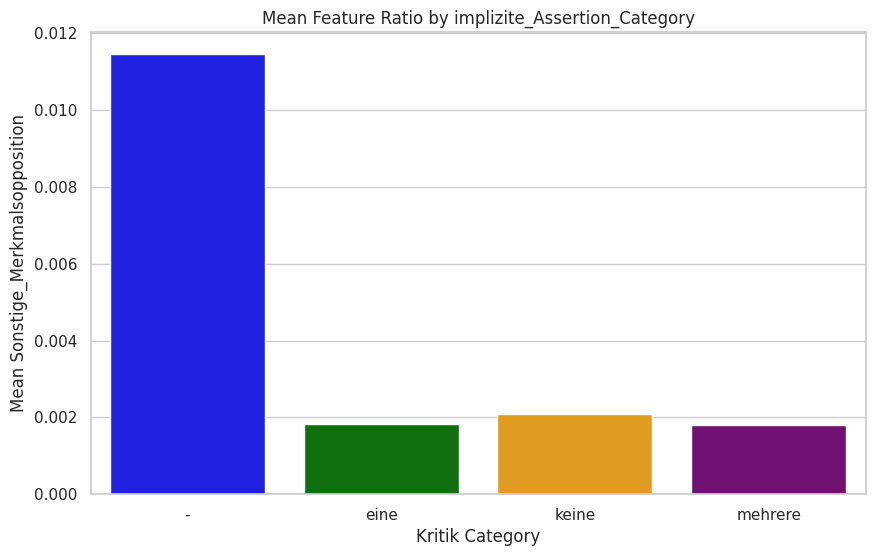

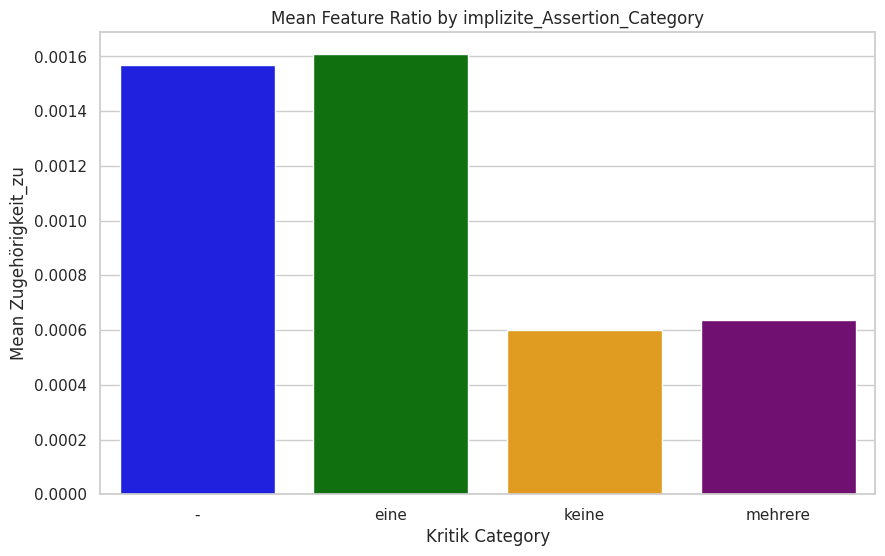

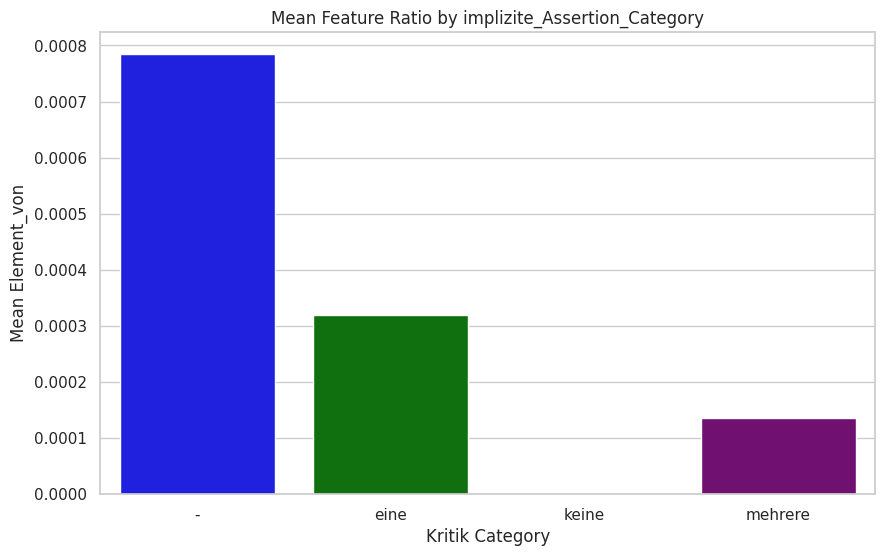

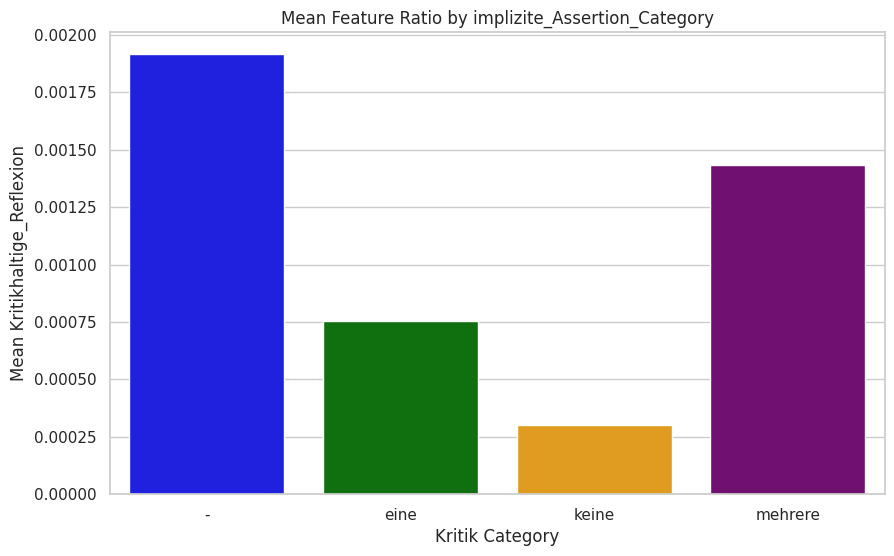

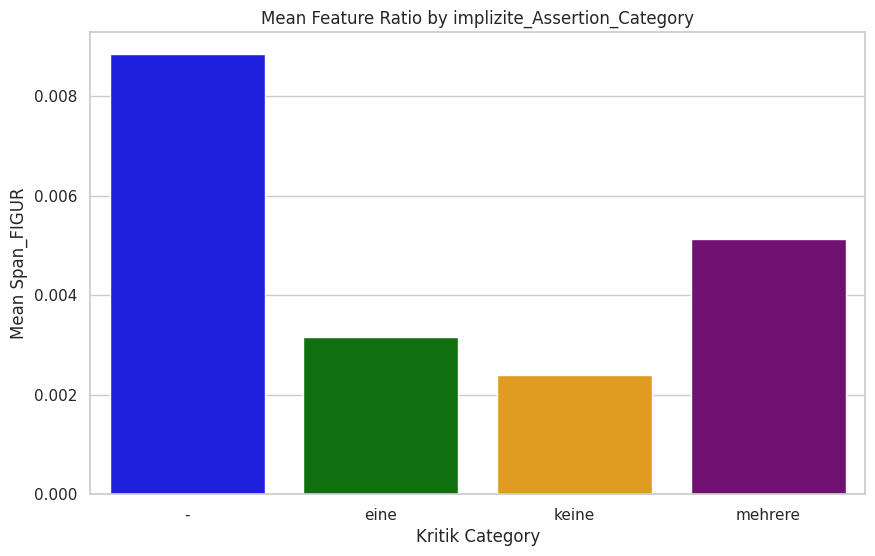

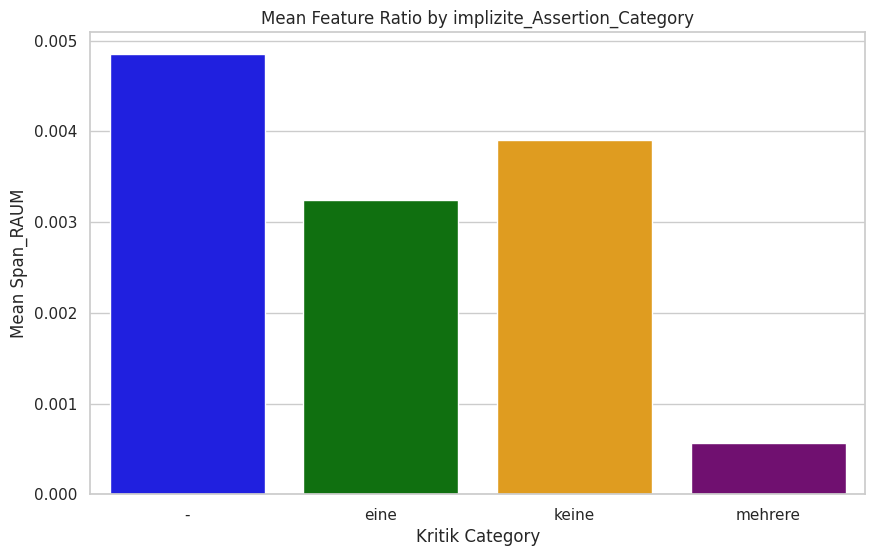

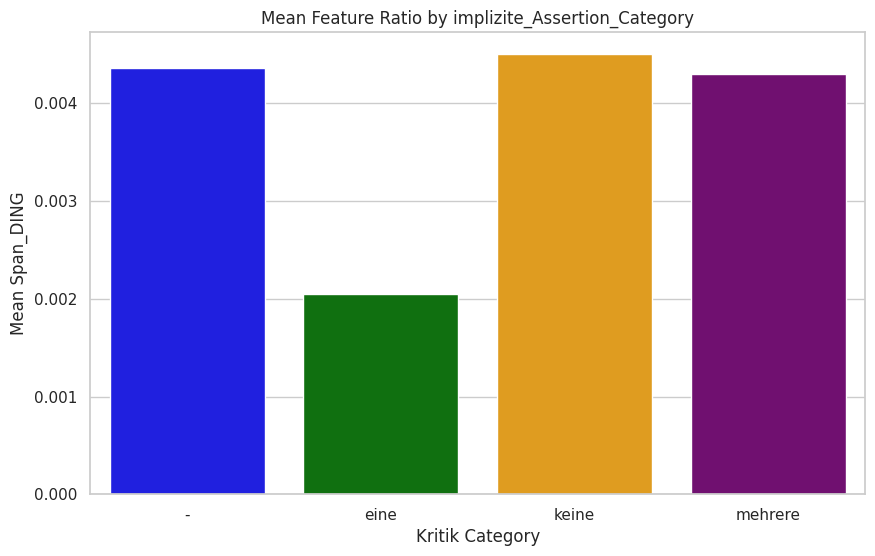

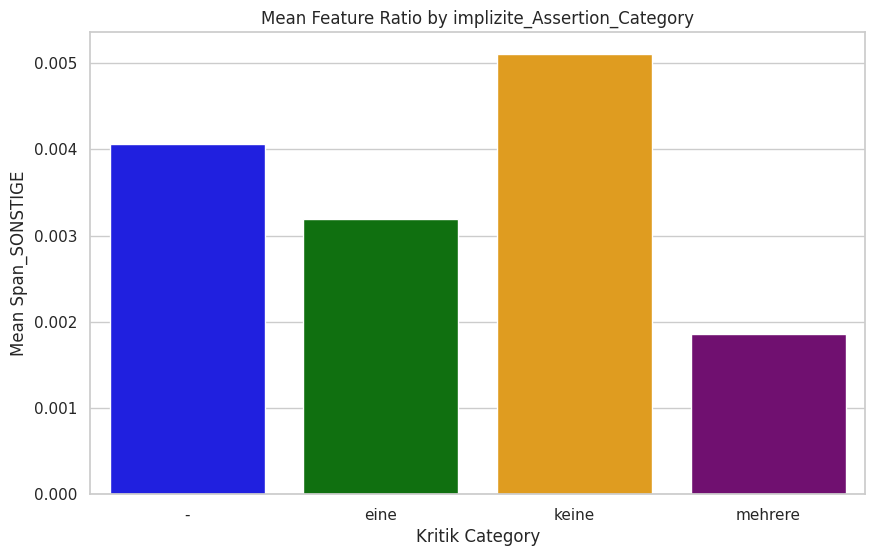

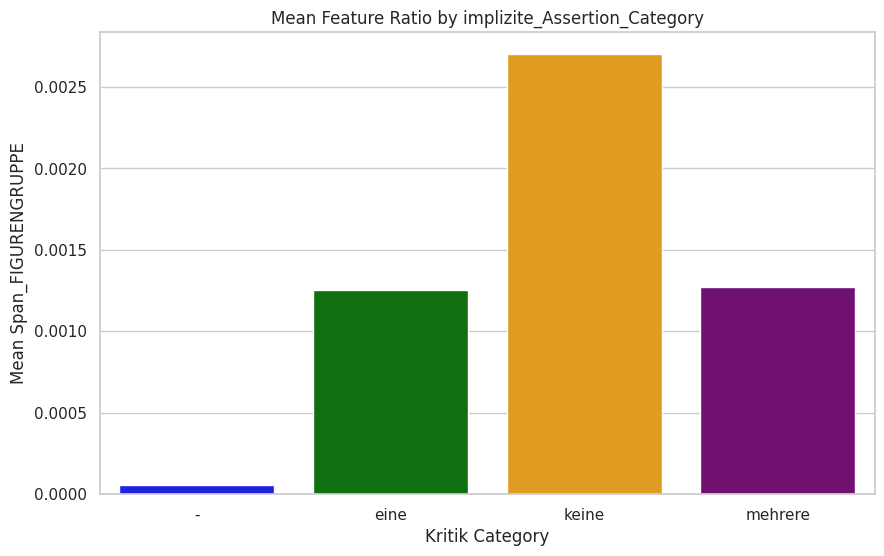

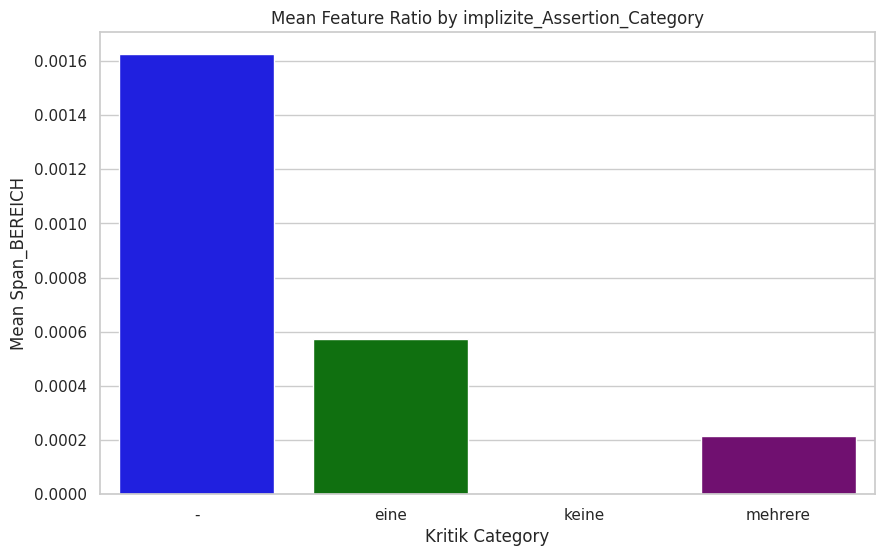

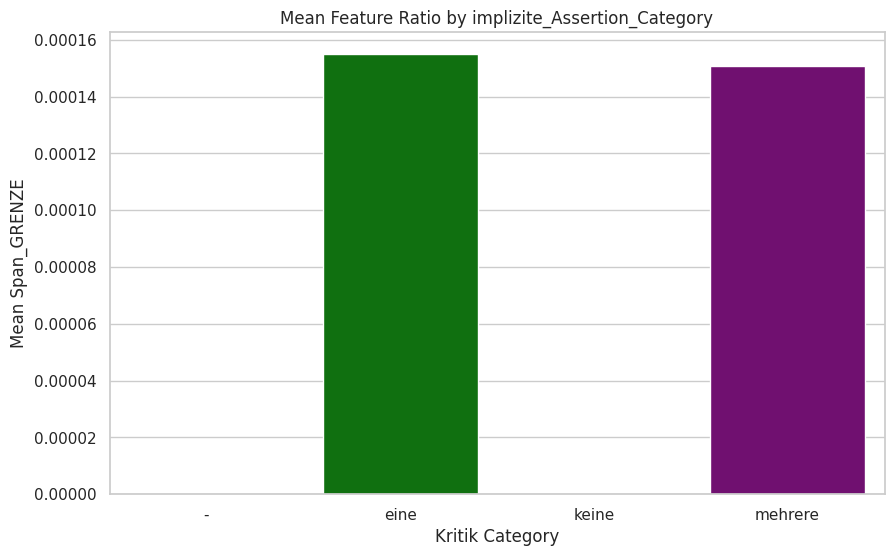

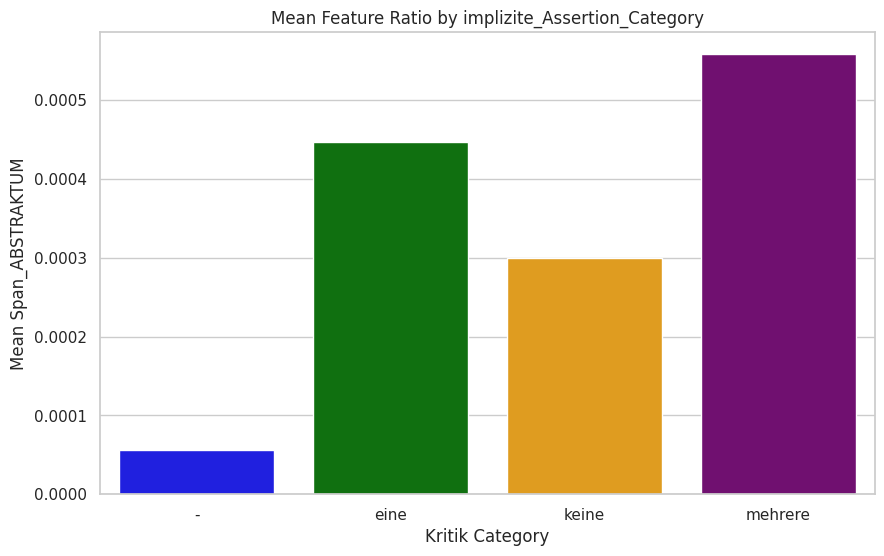

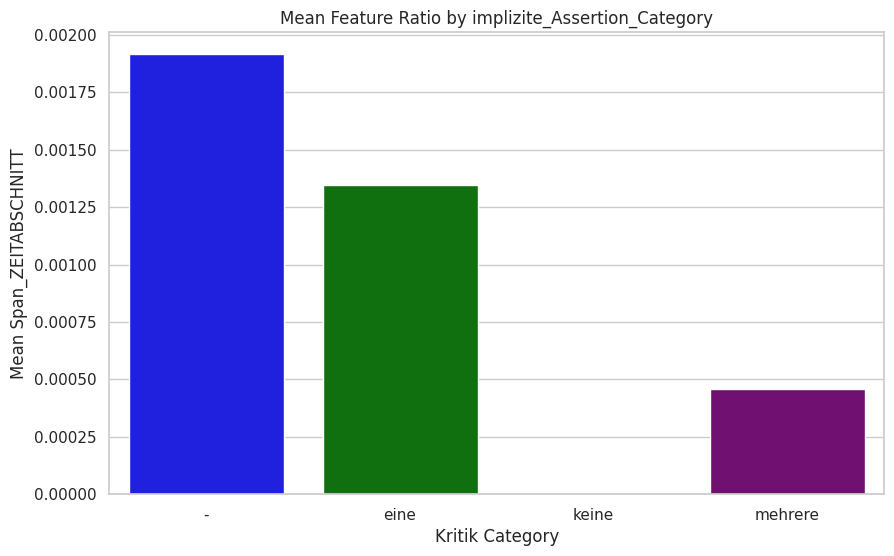

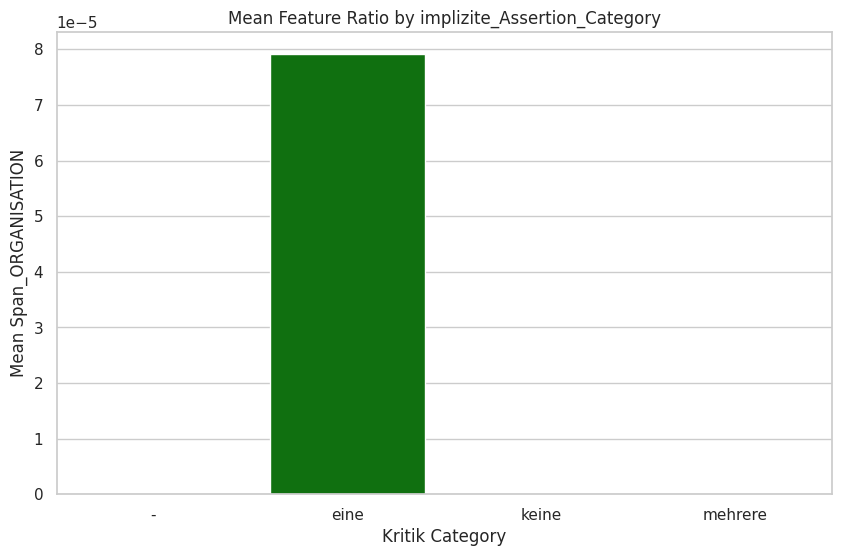

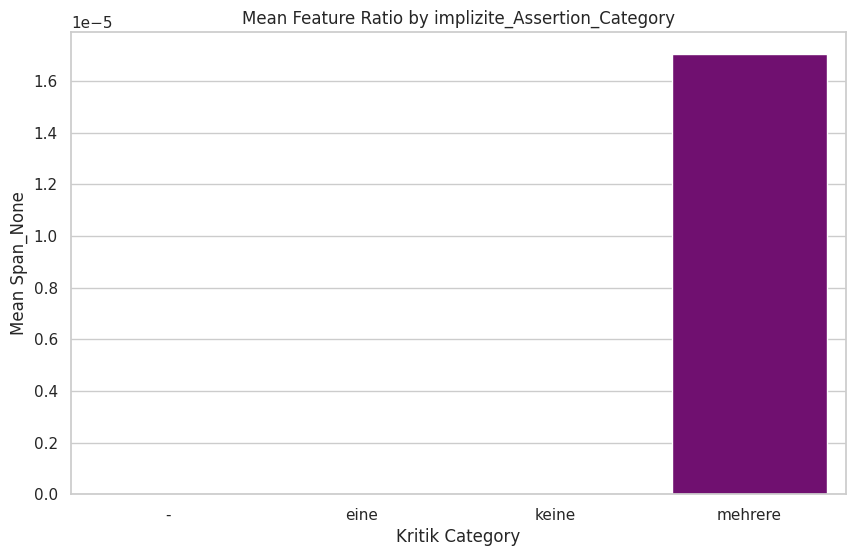

In [ ]:
#Charts for implizite_Assertion_Category
# Load data from CSV file
file_path = 'charts.csv'  # Replace with the actual path to your CSV file
df = pd.read_csv(file_path,encoding='ISO-8859-1')

categories=['implizite_Assertion_Category']

columns=['Wertung_gesamt',
'Erzählerwertung',
'Figurenwertung',
'Wertung_Kompositionsebene',
'positive_Wertung',
'negative_Wertung',
'Wertung_moralisch',
'Wertung_eudäimonistisch',
'Wertung_sozialer_Status',
'Wertung_ästhetisch',
'Wertung_sonstige',
'Codierung_gesamt',
'Codierung_tief_oberflächlich',
'Codierung_natürlich_kulturell',
'Codierung_traditionell_modern',
'Codierung_harmonisch_disharmonisch',
'Codierung_Gesund_krank',
'Opposition_gesamt',
'Wertopposition',
'Traditionell-modern-Opposition',
'Harmonisch-disharmonisch-Opposition',
'Natürlich-kulturell-Opposition',
'Gesund-krank-Opposition',
'Tiefgründig-oberflächlich-Opposition',
'Sonstige_Merkmalsopposition',
'Zugehörigkeit_zu',
'Element_von',
'Kritikhaltige_Reflexion',
'Span_FIGUR',
'Span_RAUM',
'Span_DING',
'Span_SONSTIGE',
'Span_FIGURENGRUPPE',
'Span_BEREICH',
'Span_GRENZE',
'Span_ABSTRAKTUM',
'Span_ZEITABSCHNITT',
'Span_ORGANISATION',
'Span_None'
]

for category in categories:
  for column in columns:
    # Group by 'Category' and calculate the mean
    mean_values = df.groupby(categories)[column].mean().reset_index()

    # Plotting the data with Seaborn
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x=category, y=column, hue=category, data=mean_values, palette=['blue', 'green', 'orange','purple'], legend=False)
    x_label = 'Mean Feature Ratio by ' + category
    ax.set_title(x_label)
    y_label='Mean ' + column
    ax.set_ylabel(y_label)
    ax.set_xlabel('Kritik Category')
    plt.show()
    print('\n')


In [ ]:
Document_title= [
'Aichinger_Das_Fenstertheater.txt',
'Bachmann_Arkadien_clean.txt',
'BÃ¶ll_Wanderer_kommst_du_nach_Spa_clean.txt',
'Brecht_Herr_Keuner_und_die_Schauspielerin.txt',
'Dorn_Vorsicht_Steinschlag.txt',
'Grimm_Aschenputtel_clean.txt',
'Grimm_Das_tapfere_Schneiderlein.txt',
'Grimm_Frau_Holle_clean.txt',
'Hollenstein_Gelb_wie_eine_Zitrone.txt',
'Ein Bericht fÃ¼r eine Akademie',
'Der neue Advokat',
'Kleist_Chili_clean.txt',
'LanggÃ¤sser_Die_Sippe_auf_dem_Berg_und_im_Tal.txt',
'LÃ¶ns_Die_beiden_HÃ¶fe_clean.txt',
'Mann_Beim_Propheten_clean.txt',
'Mann_Der_Geburtstag_der_Frau_Baronin.txt',
'Rilke_Die_Weise_von_Liebe_und_Tod_des_Cornets_Christoph_Rilke_clean.txt',
'Roth_Der_stumme_Prophet_Fragment_gb_clean.txt',
'Stamm_Das_schÃ¶nste_MÃ¤dchen.txt',
'Walser_Der_Nachen.txt'
]

In [ ]:
len(Wertung_gesamt_rations)

20

In [ ]:
Kritik=[
'Ausdruck',
'Ausdruck',
'Ausdruck',
'Ausdruck',
'Rolle',
'-',
'-',
'-',
'Ausdruck',
'Ausdruck',
'Ausdruck',
'Ausdruck',
'Ausdruck',
'Ausdruck',
'Ausdruck',
'-',
'-',
'Rolle',
'-',
'-']

In [ ]:
Wertung_gesamt_rations=[
0.016465,
0.005423,
0.004040,
0.019608,
0.028409,
0.010827,
0.012462,
0.026261,
0.002212,
0.010406,
0.000000,
0.009045,
0.012500,
0.013305,
0.014706,
0.029871,
0.010204,
0.006391,
0.007059,
0.016129]

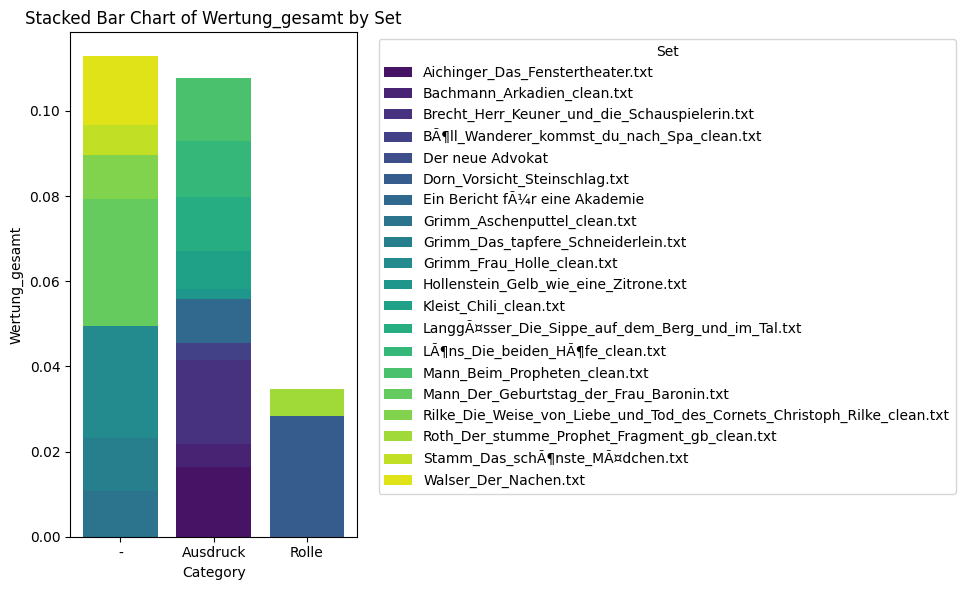

In [ ]:


# Data
data = {
    'Set': Document_title,
    'Category': Kritik,
    'Wertung_gesamt': Wertung_gesamt_rations
}

df = pd.DataFrame(data)

#Aggregate Data for Stacked Bars
# Sum the values for each category by set
df_aggregated = df.groupby(['Category', 'Set']).agg({'Wertung_gesamt': 'sum'}).reset_index()

# Pivot the DataFrame for stacking
pivot_df = df_aggregated.pivot(index='Category', columns='Set', values='Wertung_gesamt').fillna(0)

# Plot Stacked Bar Chart
fig, ax = plt.subplots(figsize=(10, 6))

# Plot each series in the pivot table as a bar
bottoms = pd.Series([0] * len(pivot_df), index=pivot_df.index)
colors = sns.color_palette('viridis', len(pivot_df.columns))

for i, column in enumerate(pivot_df.columns):
    ax.bar(pivot_df.index, pivot_df[column], bottom=bottoms, color=colors[i], label=column)
    bottoms += pivot_df[column]

# Customize the Plot
ax.set_title('Stacked Bar Chart of Wertung_gesamt by Set')
ax.set_xlabel('Category')
ax.set_ylabel('Wertung_gesamt')
ax.legend(title='Set', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to fit the legend
plt.tight_layout()

# Show the Plot
plt.show()

# Network Analysis

## Daten Für Netzwerkanalysen generieren

### x Codierungen

In [ ]:
def polarität_zu_int(polarität):
  """
  Gibt für verschiedene Codierungspolaritäten Integer aus, um Kompatibilität mit bisherigen Code (auf Wertungen bezogen) zu gewährleisten.

  Bsp: polarität == "sehr alt/traditionell" returns -1
  """
  match polarität:
    case "sehr alt/traditionell" | "sehr flach/oberflächlich" | "sehr kulturell/zivilisatorisch" | "sehr disharmonisch/fragmentiert" | "sehr krank/morbid":
      return -1
    case "alt/traditionell" | "flach/oberflächlich" | "kulturell/zivilisatorisch" | "disharmonisch/fragmentiert" | "krank/morbid":
      return -0.5
    case "neuartig/modern" | "tief/tiefsinnig" | "natürlich/ursprünglich" | "harmonisch/ganzheitlich" | "gesund/heil":
      return 0.5
    case "sehr neuartig/modern" | "sehr tief/tiefsinnig" | "sehr natürlich/ursprünglich" | "sehr harmonisch/ganzheitlich" | "sehr gesund/heil":
      return 1
    case _:
      raise ValueError("Keine existierende Polarität: %s", polarität)


In [ ]:
# Codierungen auslesen
Codierungen = {}
j = 0
# speichert Codierungen nach diesem Muster (analog dazu, wie Wertungen abgespeichert werden):
# {1: (Codierende*r, codierte Entität, Art der Codierung, Polarität, Entitätentyp),
#  2: (Codierende*r, codierte Entität, Art der Codierung, Polarität, Entitätentyp)}



# ein segment == eine codierung
for segment in doc.select('webanno.custom.AltNeuCodierung'):
    j = j+1
    #print(segment.get_covered_text())

    if segment.Polaritt_harmonisch:
      # polarität = segment.Polaritt_harmonisch # polarität als string abspeichern (zB "sehr alt/traditionell" statt -1)
      polarität = polarität_zu_int(segment.Polaritt_harmonisch)
    elif segment.Polaritt_gesund:
      # polarität = segment.Polaritt_gesund
      polarität = polarität_zu_int(segment.Polaritt_gesund)
    elif segment.Polaritt_natrlich:
      # polarität = segment.Polaritt_natrlich
      polarität = polarität_zu_int(segment.Polaritt_natrlich)
    elif segment.Polaritt_tief:
      # polarität = segment.Polaritt_tief
      polarität = polarität_zu_int(segment.Polaritt_tief)
    elif segment.Polaritt:
      # polarität = segment.Polaritt
      polarität = polarität_zu_int(segment.Polaritt)
    else:
      # polarität = None
      polarität = polarität_zu_int(None)

    codierte_entität = ""
    codierend = "Erzähler" # default Codierende*r ist Erzähler*in
    if segment.Bezugsentitt: # d.h. wir ignorieren all jene Codierungen, bei denen keine codierte Entität o Codierende*r annotiert ist (weil schlecht darstellbar). Bei zB Roth werden dann zwei Codierungen nicht weiter berücksichtigt
      for e in segment.Bezugsentitt.elements:
          if e.role == "codierte Entität":
            ent_typ = e.target.label
            if e.target.Name:
              codierte_entität = e.target.Name.split(":")[1].strip()
            else:
              codierte_entität = e.target.get_covered_text()
          elif e.role == "Codierender": # wenn die Entität Codierender ist und nicht Codierter (gibts z.B. bei Roth)
            if e.target.Name:
              codierend = e.target.Name.split(":")[1].strip()
            else:
              codierend = e.target.get_covered_text()
      """
      # kompaktere Speicherungsart:
      # {codierte Entität A : [[Art der Codierung, Polarität, Codierende*r], [Art der Codierung2, Polarität2, Codierende*r2], ...]; codierte Entität B: []; ...}
      if codierte_entität in Codierungen: # wenn diese Entität bereits als key existiert, weil schon andere Codierung dazu abgespeichert wurde
        Codierungen[codierte_entität].append([segment.Art, polarität, codierend, ent_typ])
      else:
        Codierungen[codierte_entität] = [[segment.Art, polarität, codierend, ent_typ]]
      """
      if codierte_entität:
        Codierungen[j] = codierend, codierte_entität, segment.Art, polarität, ent_typ

# testweise Ausgabe
for k,v in Codierungen.items():
  print(k, ": ", v)

NameError: name 'doc' is not defined

### x Wertungen

In [26]:
Wertungen = {}
i=j # Nummerierung der Wertungen (= keys vom Wertungen-Dictionary) beginnt da, wo diejenige der Codierungen aufhört, sodass beide dictionaries
# sich, wenn geüwnscht, mergen lassen und zusammen im Netzwerk darstellen lassen
# s.u: Codierungen und/oder Wertungen anzeigen?

for segment in doc.select('webanno.custom.Wertung'):
    i = i+1

    #print(segment.TEST)
    #print(str(segment.TEST.elements))
    print(segment.Label, ": ", segment.get_covered_text(), "; Hinsicht: ", segment.Wertungshinsicht, "; Polarität: ", segment.Polaritt)
    #if segment.Label == "implizite Wertung" or "explizite Wertung":
    Hinsicht = segment.Wertungshinsicht
    Polarität = segment.Polaritt

    if Polarität == "sehr positiv":
        Polarität_int = 1
    if Polarität == "positiv":
        Polarität_int = 0.5
    if Polarität == "sehr negativ":
        Polarität_int = -1
    if Polarität == "negativ":
        Polarität_int = -0.5


    Wertender = "Erzähler" # default
    gew_Ent = None # default

    try:
        for e in segment.TEST.elements:
            t= "test"
    except:
        print("Segment ohne gew. Objekt")
        continue

    for e in segment.TEST.elements:

        if e.role == "Wertender":

            #print(e.role, ": ", e.target.get_covered_text(), "Typ: ", e.target.label, "Name: ", e.target.Name)
            if e.target.Name is not None:
                Wertender = e.target.Name.rsplit(": ")[1]
            else:
                Wertender = e.target.get_covered_text()

        if e.role == "gewertete Entität":
                EntTyp = e.target.label
                if e.target.Name is not None:
                    gew_Ent = e.target.Name.rsplit(": ")[1]
                else:
                    gew_Ent = e.target.get_covered_text()

    # Ausschluss von Fällen ohne Wertungsobjekt
    if gew_Ent is not None:
        Wertungen[i] = Wertender, gew_Ent, Hinsicht, Polarität_int, EntTyp


#print(Wertungen)
# Filter
#res = {key: val for key, val in Wertungen if val[0] != "Erzähler"}
#print(res)

# to csv
import csv
data_folder = PureWindowsPath(r"D:\Dropbox\Wissenschaft\Kultur_und_Modernekritik\Gephi")
file_to_open = data_folder / "Kleist_for_gephi.csv"
with open(file_to_open, 'w', newline='', encoding='utf-8') as csv_file:
    writer = csv.writer(csv_file, delimiter=';')
    #writer.writerow(["id", "gewertete_Entität", "Hinsicht_Polarität"])

    # gephi-Format
    writer.writerow(["Source", "Target", "Type", "Id", "Label", "Weight"])
    Type = "Directed"
    #Source = "Erzähler"
    Id = 0


    for key, value in Wertungen.items():
        Source = value[0]
        Entität = value[1]
        Hinsicht = value[2]
        Polarität = value[3]
        writer.writerow([Source, Entität, Type, key, Hinsicht, Polarität])
        Id = Id +1

print("#######")
print(Wertungen)


None :  Hohe Herren von der Akademie ; Hinsicht:  sozialer Status ; Polarität:  positiv
None :  Sie erweisen mir die Ehre ; Hinsicht:  sonstige ; Polarität:  positiv
None :  In diesem Sinne kann ich leider der Aufforderung nicht nachkommen ; Hinsicht:  nicht spezifiziert ; Polarität:  negativ
None :  von vortrefflichen Menschen ; Hinsicht:  moralisch ; Polarität:  positiv
None :  Diese Leistung ; Hinsicht:  nicht spezifiziert ; Polarität:  positiv
None :  ich, freier Affe ; Hinsicht:  sozialer Status ; Polarität:  positiv
None :  ich, freier Affe, fügte mich diesem Joch ; Hinsicht:  eudämonistisch ; Polarität:  sehr negativ
None :  freigestellt durch das ganze Tor, das der Himmel über der Erde bildet, wurde es gleichzeitig mit meiner vorwärtsgepeitschten Entwicklung immer niedriger und enger ; Hinsicht:  sonstige ; Polarität:  negativ
None :  vorwärtsgepeitschten Entwicklung ; Hinsicht:  sonstige ; Polarität:  negativ
None :  wohler und eingeschlossener fühlte ich mich in der Menschenw

### x Positive und negativ bewertete Entitäten

In [ ]:
"""
Ent_Bewert speichert zu jeder bewerteten Entität ab, in welcher Hinsicht und mit welcher Polarität die bewertet wird,
nach folgendem Muster (Beispiel):

{'der Einsamkeit': {'ästhetisch': 0.5,
  'epistemisch': 0,
  'eudämonistisch': -0.5,
  'eudämonistisch Figur': 0,
  'moralisch': 0,
  'sozialer Status': 0,
  'sonstige': 0,
  'nicht spezifiziert': 0,
  'gesamt': 0.0,
  'gesamt_Erzähler': 0.0,
  'gesamt_Rest': 0,
  'Typ Entität': 'ABSTRAKTUM'}, ...}
"""

Id = 0
Ent_Bewert = {}

keylist = ["ästhetisch", "epistemisch", "eudämonistisch", "eudämonistisch Figur", "moralisch",
                          "sozialer Status", "sonstige", "nicht spezifiziert", "gesamt", "gesamt_Erzähler", "gesamt_Rest", "Typ Entität"]

for key, value in Wertungen.items():
    Wertender = value[0]
    Entität = value[1]
    Hinsicht = value[2]
    Polarität = value[3]
    EntTyp = value[4]
    #print(Wertungen.items())



    #if Wertender == "Erzähler":            #optional nur Erzählerwertungen
    if Entität in Ent_Bewert.keys():
        Ent_Bewert[Entität][Hinsicht] = Ent_Bewert[Entität][Hinsicht] + Polarität
        Ent_Bewert[Entität]["gesamt"] += Polarität
        if Wertender == "Erzähler":
          try:
            Ent_Bewert[Entität]["gesamt_Erzähler"] = Ent_Bewert[Entität]["gesamt_Erzähler"] + Polarität
          except KeyError: # falls gesamt_Erzähler noch nicht initialisiert wurde
            Ent_Bewert[Entität]["gesamt_Erzähler"] = Polarität
        else: # Wertungen, die nicht vom Erzähler ausgehen
          try:
            Ent_Bewert[Entität]["gesamt_Rest"] = Ent_Bewert[Entität]["gesamt_Rest"] + Polarität
          except KeyError:
            Ent_Bewert[Entität]["gesamt_Rest"] = Polarität
    else: # wenn die entität noch nicht in Ent_Bewert ist
        empty_d = {}
        for i in keylist:
            try:
              empty_d[i] = 0
            except:
              continue
        Ent_Bewert[Entität] = empty_d
        Ent_Bewert[Entität][Hinsicht] = Polarität
        Ent_Bewert[Entität]["gesamt"] = Polarität
        if Wertender == "Erzähler":
          Ent_Bewert[Entität]["gesamt_Erzähler"] = Polarität
        else:
          Ent_Bewert[Entität]["gesamt_Rest"] = Polarität
        Ent_Bewert[Entität]["Typ Entität"] = EntTyp

Ent_Bewert



### Figurenprofile

In [ ]:
import plotly.express as px
import pandas as pd
df =pd.DataFrame.from_dict(Ent_Bewert,orient='index')
df
df.drop('gesamt', axis=1, inplace=True)

#df = pd.DataFrame(df.loc[["Jeronimo Rugera"]])
fig = px.line_polar(df, r=df.loc["Jeronimo Rugera"], theta=df.columns, line_close=True)
fig.show()

# Netzwerkanalyse

## x Codierungen und/oder Wertungen anzeigen?

In [ ]:
"""
anzeige_option == "c" --> nur Codierungen im Netzwerk
anzeige_option == "w" --> nur Wertungen
anzeige_option  == alles andere --> Wertungen und Codierungen
Ausnahme: auf Ebene der Relationen werden immer auch nicht nur Wertoppositionen angezeigt, sondern
auch zB nat-kult-Oppositionen
"""

anzeige_option = "y" # <------- set option. wenn geändert, danach noch mal alle mit x versehenen Abschnitte laufen lassen


if anzeige_option == "w":
  df = pd.DataFrame.from_dict(Wertungen, orient = "index", columns=['Source', 'Target', 'Label', "Weight", "Type"])
elif anzeige_option == "c":
  df = pd.DataFrame.from_dict(Codierungen, orient = "index", columns=['Source', 'Target', 'Label', "Weight", "Type"])
else:
  combined_dict = {}
  combined_dict.update(Codierungen)
  combined_dict.update(Wertungen)
  df = pd.DataFrame.from_dict(combined_dict, orient = "index", columns=['Source', 'Target', 'Label', "Weight", "Type"])

df["Weight"] = df["Weight"].astype(float)*5
pd.set_option('display.max_rows', 5)
print(df)

       Source                                             Target  \
1    Erzähler  seit dem fürchterlichen Schlage, der sie durch...   
2    Erzähler  diesen gräßlichen Augenblicken, in welchen all...   
..        ...                                                ...   
121  Erzähler                                Der Marine-Offizier   
122  Erzähler                                       Don Fernando   

                        Label  Weight           Type  
1    Harmonisch-Disharmonisch     2.5  ZEITABSCHNITT  
2    Harmonisch-Disharmonisch     5.0  ZEITABSCHNITT  
..                        ...     ...            ...  
121                 moralisch    -2.5          FIGUR  
122                 moralisch     2.5          FIGUR  

[107 rows x 5 columns]


## x Netzwerk mit Erzählerwertungen als Kanten (G)

In [ ]:
# Networkx
!pip install pyvis
!pip install cyjupyter
!pip install networkx

from pyvis.network import Network
from IPython.display import HTML
import pandas as pd
import networkx as nx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 64.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 9.5 MB/s eta 0:00:00
  Attempting uninstall: attrs
    Found existing installation: attrs 21.2.0
    Uninstalling attrs-21.2.0:
      Successfully uninstalled attrs-21.2.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
dkpro-cassis 0.8.0 requires attrs==21.2.*, but you have attrs 23.1.0 which is incompatible.


In [ ]:
# MultiDiGraph erstellen
G = nx.MultiDiGraph()
G_Fig = nx.MultiDiGraph()

# benutzerdefinierte Farbpalette definieren
color_palette = {"positive": "green", "negative": "red"}

# Kanten aus DataFrame hinzufügen
for i, row in df.iterrows():
    source = row["Source"]
    target = row["Target"]
    label = row["Label"]
    weight = row["Weight"]
    Typ = row["Type"]
    edge_color = color_palette["positive"] if weight >= 0 else color_palette["negative"]
    if source == "Erzähler" and Typ == "FIGUR":
      G.add_edge(source, target, key=i, label=label, weight=weight, width=weight, color=edge_color)
    if source != "Erzähler" and Typ == "FIGUR":
      G_Fig.add_edge(source, target, key=i, label=label, weight=weight, width=weight, color=edge_color)



# Größe der Nodes
scale=3 # Scaling the size of the nodes by 10*degree
d = dict(G.degree)
#print(d)

#Updating dict
d.update((x, scale*y) for x, y in d.items())
#print(d)
#Setting up size attribute
nx.set_node_attributes(G,d,'size')

# Netzwerk mit pyvis erstellen
nt = Network(notebook=True, directed=True, cdn_resources='in_line')
nt.from_nx(G)

# Optionen für das Layout des Graphen festlegen
nt.barnes_hut()
nt.options.physics.enabled = True
nt.options.edges.smooth = True

# Node- und Kantenbeschriftungen aktivieren
nt.show_buttons()
nt.toggle_physics(True)


# Kantenbreite und -farbe anpassen
nt.options.edges.width = 1
nt.options.edges.color = {"inherit":False}
nt.options.edges.font = {"size": 25, "color": "#444444"}

for node in nt.nodes:
    #node["color"] = "red"
    node['font'] = {'size': 60}

# Netzwerk anzeigen
nt.show('nx.html')
# nur in colab
display(HTML('nx.html'))


nx.html


## x Figurenwertungen (G_Fig)

In [ ]:
#G.edges(data= True)
#G.nodes(data = True)
#nt.nodes

In [ ]:
# Figurenwertungen
# Größe der Nodes
scale=3 # Scaling the size of the nodes by 10*degree
d = dict(G_Fig.degree)
#print(d)

#Updating dict
d.update((x, scale*y) for x, y in d.items())
#print(d)
#Setting up size attribute
nx.set_node_attributes(G_Fig,d,'size')

# Netzwerk mit pyvis erstellen
nt = Network(notebook=True, directed=True, cdn_resources='in_line')
nt.from_nx(G_Fig)

# Optionen für das Layout des Graphen festlegen
nt.barnes_hut()
nt.options.physics.enabled = True
nt.options.edges.smooth = True

# Node- und Kantenbeschriftungen aktivieren
nt.show_buttons()
nt.toggle_physics(True)


# Kantenbreite und -farbe anpassen
nt.options.edges.width = 1
nt.options.edges.color = {"inherit":False}
nt.options.edges.font = {"size": 25, "color": "#444444"}

for node in nt.nodes:
    #node["color"] = "red"
    node['font'] = {'size': 60}

# Netzwerk anzeigen
nt.show('nx.html')
# nur in colab
display(HTML('nx.html'))

nx.html


## x Netzwerk mit annotierten Oppositionen als Kanten (G2)

In [ ]:
# Achtung: Edges, die übereinanderliegen werden nicht dargestellt

# MultiDiGraph erstellen
G2 = nx.MultiDiGraph()

# benutzerdefinierte Farbpalette definieren
color_palette = {"Wertopposition": "green", "else": "red"}


# Kanten aus DataFrame hinzufügen
for key, value in Relationen.items():
    source = value[0]
    target = value[1]
    label = value[2]
    edge_color = color_palette["Wertopposition"] if label == "Wertopposition" else color_palette["else"]
    G2.add_edge(source, target, key=i, label=label, color=edge_color)

# Größe der Nodes
scale=10 # Scaling the size of the nodes by 10*degree
d = dict(G2.degree)
#print(d)

#Updating dict
d.update((x, scale*y) for x, y in d.items())
#print(d)
#Setting up size attribute
nx.set_node_attributes(G2,d,'size')

# Netzwerk mit pyvis erstellen
nt = Network(notebook=True, directed=True, heading='Oppositionen Kleist', layout="hierarchical", cdn_resources='in_line')
#nt.show_buttons(filter_=["physics"])

nt.from_nx(G2)

# Optionen für das Layout des Graphen festlegen
nt.barnes_hut()
nt.options.physics.enabled = True
nt.options.edges.smooth = True

# Node- und Kantenbeschriftungen aktivieren
nt.show_buttons()
nt.toggle_physics(False)


# Kantenbreite und -farbe anpassen
nt.options.edges.width = 1
nt.options.edges.color = {"inherit":False}
nt.options.edges.font = {"size": 10, "color": "#444444"}


# Netzwerk anzeigen
nt.show('nx.html')
display(HTML('nx.html'))


nx.html


In [ ]:
G2.edges(data = True)

OutMultiEdgeDataView([('Friedrich Kargan', 'Die Genossen', {'label': 'Wertopposition', 'color': 'green', 'width': 1}), ('Friedrich Kargan', 'sie', {'label': 'Wertopposition', 'color': 'green', 'width': 1}), ('Friedrich Kargan', 'Herr von Derschatta', {'label': 'Wertopposition', 'color': 'green', 'width': 1}), ('Friedrich Kargan', 'Savelli', {'label': 'Wertopposition', 'color': 'green', 'width': 1}), ('Die Zeiten', 'Jetzt', {'label': 'Wertopposition', 'color': 'green', 'width': 1}), ('Der Proletarier', 'der Bourgeois', {'label': 'Wertopposition', 'color': 'green', 'width': 1}), ('Sibirien', 'der zivilisierten Länder', {'label': 'Natürlich-kulturell-Opposition', 'color': 'red', 'width': 1})])

## Netzwerk mit (nicht-annotierten) Oppositionen als Kanten

In [ ]:
negativeFiguren = {k:v for k,v in Ent_Bewert.items() if v['gesamt'] < 0 and v["Typ Entität"] == "FIGUR"}
positiveFiguren = {k:v for k,v in Ent_Bewert.items() if v['gesamt'] > 0 and v["Typ Entität"] == "FIGUR"}

negativeFiguren


{'Friedrich Kargan': {'ästhetisch': 0,
  'epistemisch': -1,
  'eudämonistisch': 0,
  'eudämonistisch Figur': -1.0,
  'moralisch': -1.0,
  'sozialer Status': 0,
  'sonstige': -0.5,
  'nicht spezifiziert': 0.5,
  'gesamt': -3.0,
  'gesamt_Erzähler': -2.0,
  'gesamt_Rest': -1.0,
  'Typ Entität': 'FIGUR'},
 'ihren eifersüchtigen Mann': {'ästhetisch': 0,
  'epistemisch': 0,
  'eudämonistisch': 0,
  'eudämonistisch Figur': 0,
  'moralisch': 0,
  'sozialer Status': 0,
  'sonstige': -0.5,
  'nicht spezifiziert': 0,
  'gesamt': -0.5,
  'gesamt_Erzähler': -0.5,
  'gesamt_Rest': 0,
  'Typ Entität': 'FIGUR'},
 'Herr von Derschatta': {'ästhetisch': 0,
  'epistemisch': 0,
  'eudämonistisch': 0,
  'eudämonistisch Figur': 0,
  'moralisch': 0,
  'sozialer Status': 0,
  'sonstige': -1.5,
  'nicht spezifiziert': 0,
  'gesamt': -1.5,
  'gesamt_Erzähler': -1.5,
  'gesamt_Rest': 0,
  'Typ Entität': 'FIGUR'},
 'Wilson': {'ästhetisch': 0,
  'epistemisch': 0,
  'eudämonistisch': 0,
  'eudämonistisch Figur': 0,

In [ ]:
# MultiDiGraph erstellen
G3 = nx.MultiDiGraph()

# benutzerdefinierte Farbpalette definieren
color_palette = {"nicht-annotiert": "black", "else": "red"}

for key, value in negativeFiguren.items():
    source = key
    i = 0
    for key2, value2 in positiveFiguren.items():
        i = i +1
        target = key2
        label = "nicht-annotiert"
        edge_color = color_palette["nicht-annotiert"] if label == "nicht-annotiert" else color_palette["else"]
        G3.add_edge(source, target, key = i, label=label, color=edge_color)

# annotierte Relationen
for key, value in Relationen.items():
    source = value[0]
    target = value[1]
    label = value[2]
    if source or target in nt.nodes.keys():
        G3.add_edge(source, target, key=i, label=label, color="red")


# Größe der Nodes
scale=5 # Scaling the size of the nodes by 10*degree
d = dict(G3.degree)
#print(d)

#Updating dict
d.update((x, scale*y) for x, y in d.items())
#print(d)
#Setting up size attribute
nx.set_node_attributes(G3,d,'size')

# Netzwerk mit pyvis erstellen
nt = Network(notebook=True, directed=True, heading='Oppositionen Kleist', cdn_resources='in_line')
#nt.show_buttons(filter_=["physics"])

nt.from_nx(G3)

# Optionen für das Layout des Graphen festlegen
nt.barnes_hut()
nt.options.physics.enabled = True
nt.options.edges.smooth = True

# Node- und Kantenbeschriftungen aktivieren
nt.show_buttons(True)
nt.toggle_physics(True)


# Kantenbreite und -farbe anpassen
nt.options.edges.width = 1
nt.options.edges.color = {"inherit":False}
nt.options.edges.font = {"size": 10, "color": "#444444"}

#Farbe der Nodes
for node in nt.nodes:
    if node["id"] in negativeFiguren.keys():
        node["color"] = "red"
        node['font'] = {'size': 50}
    else:
        node["color"] = "green"
        node['font'] = {'size': 50}



# Netzwerk anzeigen
nt.show('nx.html')
display(HTML('nx.html'))


NameError: ignored

In [ ]:
G3.nodes(data = True)

NodeDataView({'seines stolzen Sohnes': {'size': 45}, 'Don Henrico Asteron': {'size': 40}, 'Donna Josephe': {'size': 35}, 'der heiligen Mutter Gottes': {'size': 35}, 'ein mutiger Retter': {'size': 40}, 'Gott': {'size': 35}, 'die Äbtissin': {'size': 35}, 'den teuern Knaben': {'size': 35}, 'Don Fernando': {'size': 40}, 'Donna Elvire': {'size': 35}, 'ein anderer, bleich wie der Tod': {'size': 50}, 'dem Besitzer': {'size': 45}, 'Donna Elisabeth': {'size': 45}, 'Meister Pedrillo': {'size': 50}, 'ich': {'size': 45}, 'den fanatischen Mordknecht, der diese Greuel veranlaßte': {'size': 45}, 'Tale': {'size': 5}, 'St. Jago': {'size': 5}, 'Jeronimo Rugera': {'size': 5}, 'ein weites, nur von wenig Menschen besuchtes Tal': {'size': 5}, 'Stadt': {'size': 5}, 'ein See': {'size': 5}, 'väterliches Haus': {'size': 5}, 'Klostergarten': {'size': 5}, 'den Gefängnissen': {'size': 5}, 'ungeheuern Taten': {'size': 5}, 'der nichtssagenden Unterhaltungen': {'size': 5}, 'der Täter': {'size': 10}, 'der Chorherr': {

## Netzwerk mit (nicht-annotierten) Oppositionen nach Hinsicht als Kanten

In [ ]:
# MultiDiGraph erstellen
G4 = nx.MultiDiGraph()

# benutzerdefinierte Farbpalette definieren
color_palette = {"ästhetisch": "black", "epistemisch": "brown", "eudämonistisch": "blue", "eudaimonistisch Figur": "pink", "moralisch": "green",
                          "sozialer Status": "yellow", "else": "grey"}

#create dict of all entities
alleFiguren = {**negativeFiguren, **positiveFiguren}
#print(alleFiguren)


oppositionen = []
for key, value in alleFiguren.items():
    source = key
    i = 0
    negative_hinsichten = []
    # create list aller relevanten Hinsichten
    for hinsicht, wert in value.items():
      try:
        if wert < 0 and hinsicht != "gesamt":
          negative_hinsichten.append(hinsicht)
      except:
        pass
      #print(negative_hinsichten)
    # suche alle anderen Entitäten mit entgegengesetzer Hinsicht
    for key2, value2 in alleFiguren.items():
      target = key2
      for hinsicht, wert in value2.items():
        #print(wert)
        try:
          if wert > 0 and hinsicht in negative_hinsichten:
            oppositionen.append((source, target))
            i = i +1
            label = hinsicht
            edge_color = color_palette[hinsicht] if label == hinsicht else color_palette["else"]
            G4.add_edge(source, target, key = i, label=label, color=edge_color)
        except:
          pass
#print(oppositionen)

# annotierte Relationen
for key, value in Relationen.items():
    try:
      source = value[0].split(":")[1]
    except:
      source = value[0]
    try:
      target = value[1].split(":")[1]
    except:
      target = value[1]
    label = value[2]

    if source or target in nt.nodes.keys():
        i = i + 1
        G4.add_edge(source, target, key=i, label=label, color="red")


# Größe der Nodes
scale=5 # Scaling the size of the nodes by 10*degree
d = dict(G4.degree)
#print(d)

#Updating dict
d.update((x, scale*y) for x, y in d.items())
#print(d)
#Setting up size attribute
nx.set_node_attributes(G4,d,'size')

# Netzwerk mit pyvis erstellen
nt = Network(notebook=True, directed=True, heading='Oppositionen nach Hinsicht Kleist', cdn_resources='in_line')
#nt.show_buttons(filter_=["physics"])

nt.from_nx(G4)

# Optionen für das Layout des Graphen festlegen
nt.barnes_hut()
nt.options.physics.enabled = True
nt.options.edges.smooth = True

# Node- und Kantenbeschriftungen aktivieren
nt.show_buttons(True)
nt.toggle_physics(True)


# Kantenbreite und -farbe anpassen
nt.options.edges.width = 1
nt.options.edges.color = {"inherit":False}
nt.options.edges.font = {"size": 25, "color": "#444444"}


#Farbe der Nodes
for node in nt.nodes:
    if node["id"] in negativeFiguren.keys():
        node["color"] = "red"
        node['font'] = {'size': 50}
    else:
        node["color"] = "green"
        node['font'] = {'size': 50}



# Netzwerk anzeigen
nt.show('nx.html')
display(HTML('nx.html'))


nx.html


In [ ]:
Relationen.items()

dict_items([(1, ('Tale', 'St. Jago', 'Natürlich-kulturell-Opposition')), (2, ('Tale', 'St. Jago', 'Wertopposition')), (3, ('Don Henrico Asteron', 'Jeronimo Rugera', 'Wertopposition')), (4, ('ein mutiger Retter', 'ein anderer, bleich wie der Tod', 'Wertopposition')), (5, ('ein weites, nur von wenig Menschen besuchtes Tal', 'Stadt', 'Wertopposition')), (6, ('ein See', 'väterliches Haus', 'Natürlich-kulturell-Opposition')), (7, ('Klostergarten', 'den Gefängnissen', 'Wertopposition')), (8, ('ungeheuern Taten', 'der nichtssagenden Unterhaltungen', 'Wertopposition')), (9, ('der Täter', 'der Chorherr', 'Wertopposition')), (10, ('Menschen', 'der Täter', 'Wertopposition')), (11, ('diese gottlosen Menschen', 'die ganze im Tempel Jesu versammelte Christenheit', 'Wertopposition')), (12, ('Don Fernando', 'Meister Pedrillo', 'Wertopposition')), (13, ('Don Fernando', 'Meister Pedrillo', 'Wertopposition'))])

In [ ]:
G4.edges(data = True)

OutMultiEdgeDataView([('seines stolzen Sohnes', 'Donna Josephe', {'label': 'moralisch', 'color': 'green', 'width': 1}), ('seines stolzen Sohnes', 'ein mutiger Retter', {'label': 'moralisch', 'color': 'green', 'width': 1}), ('seines stolzen Sohnes', 'Gott', {'label': 'moralisch', 'color': 'green', 'width': 1}), ('seines stolzen Sohnes', 'die Äbtissin', {'label': 'moralisch', 'color': 'green', 'width': 1}), ('seines stolzen Sohnes', 'Don Fernando', {'label': 'moralisch', 'color': 'green', 'width': 1}), ('seines stolzen Sohnes', 'Donna Elvire', {'label': 'moralisch', 'color': 'green', 'width': 1}), ('ein mutiger Retter', 'ein anderer, bleich wie der Tod', {'label': 'Wertopposition', 'color': 'red', 'width': 1}), ('Don Fernando', 'Meister Pedrillo', {'label': 'Wertopposition', 'color': 'red', 'width': 1}), ('Don Fernando', 'Meister Pedrillo', {'label': 'Wertopposition', 'color': 'red', 'width': 1}), ('ein anderer, bleich wie der Tod', 'Donna Josephe', {'label': 'moralisch', 'color': 'green

## Knotengröße nach Wertung plus alle Oppositionen




In [ ]:
negativeFiguren = {k:v for k,v in Ent_Bewert.items() if v['gesamt'] < 0 and v["Typ Entität"] == "FIGUR"}
positiveFiguren = {k:v for k,v in Ent_Bewert.items() if v['gesamt'] > 0 and v["Typ Entität"] == "FIGUR"}

negativeFiguren

{'seines stolzen Sohnes': {'ästhetisch': 0,
  'epistemisch': 0,
  'eudämonistisch': 0,
  'eudaimonistisch Figur': 0,
  'moralisch': -0.5,
  'sozialer Status': 0,
  'sonstige': 0,
  'nicht spezifiziert': 0,
  'gesamt': -0.5,
  'gesamt_Erzähler': -0.5,
  'gesamt_Rest': 0,
  'Typ Entität': 'FIGUR'},
 'ein anderer, bleich wie der Tod': {'ästhetisch': 0,
  'epistemisch': 0,
  'eudämonistisch': 0,
  'eudaimonistisch Figur': 0,
  'moralisch': -0.5,
  'sozialer Status': 0,
  'sonstige': 0,
  'nicht spezifiziert': 0,
  'gesamt': -0.5,
  'gesamt_Erzähler': -0.5,
  'gesamt_Rest': 0,
  'Typ Entität': 'FIGUR'},
 'dem Besitzer': {'ästhetisch': 0,
  'epistemisch': 0,
  'eudämonistisch': 0,
  'eudaimonistisch Figur': 0,
  'moralisch': -0.5,
  'sozialer Status': 0,
  'sonstige': 0,
  'nicht spezifiziert': 0,
  'gesamt': -0.5,
  'gesamt_Erzähler': -0.5,
  'gesamt_Rest': 0,
  'Typ Entität': 'FIGUR'},
 'Donna Elisabeth': {'ästhetisch': -0.5,
  'epistemisch': 0,
  'eudämonistisch': 0,
  'eudaimonistisch Fi

In [ ]:
# MultiDiGraph erstellen
G4 = nx.MultiDiGraph()

# benutzerdefinierte Farbpalette definieren
color_palette = {"ästhetisch": "pink", "epistemisch": "brown", "eudämonistisch": "blue", "eudaimonistisch Figur": "blue", "moralisch": "black",
                          "sozialer Status": "yellow", "else": "grey"}

#create dict of all entities
alleFiguren = {**negativeFiguren, **positiveFiguren}
#print(alleFiguren)

# alle Nodes hinzufügen
for key, value in alleFiguren.items():
  size = abs(alleFiguren[key]["gesamt"])*10
  G4.add_node(key, label=str(key), size=size)

oppositionen = []
for key, value in alleFiguren.items():
    source = key
    i = 0
    negative_hinsichten = []
    # create list aller relevanten Hinsichten
    for hinsicht, wert in value.items():
      try:
        if wert < 0 and hinsicht != "gesamt":
          negative_hinsichten.append(hinsicht)
      except:
        pass
      #print(negative_hinsichten)
    # suche alle anderen Entitäten mit entgegengesetzer Hinsicht
    for key2, value2 in alleFiguren.items():
      target = key2
      for hinsicht, wert in value2.items():
        #print(wert)
        try:
          if wert > 0 and hinsicht in negative_hinsichten:
            oppositionen.append((source, target))
            i = i +1
            label = hinsicht
            edge_color = color_palette[hinsicht] if label == hinsicht else color_palette["else"]
            G4.add_edge(source, target, key = i, label=label, color=edge_color)
        except:
          pass
#print(oppositionen)

# annotierte Relationen
for key, value in Relationen.items():
    try:
      source = value[0].split(":")[1]
    except:
      source = value[0]
    try:
      target = value[1].split(":")[1]
    except:
      target = value[1]
    label = value[2]

    if source or target in nt.nodes.keys():
        i = i + 1
        nt.add_edge(source, target, key=i, label=label, color="red")



# Größe der Nodes
#scale=5 # Scaling the size of the nodes by 10*degree
#d = dict(G4.degree)
#print(d)

#Updating dict
#d.update((x, scale*y) for x, y in d.items())
#print(d)
#Setting up size attribute
#nx.set_node_attributes(G4,d,'size')

# Netzwerk mit pyvis erstellen
nt = Network(notebook=True, directed=True, heading='Oppositionen nach Hinsicht Kleist', cdn_resources='in_line')
#nt.show_buttons(filter_=["physics"])

nt.from_nx(G4)

# Optionen für das Layout des Graphen festlegen
nt.barnes_hut()
nt.options.physics.enabled = True
nt.options.edges.smooth = True

# Node- und Kantenbeschriftungen aktivieren
nt.show_buttons(True)
nt.toggle_physics(True)


# Kantenbreite und -farbe anpassen
nt.options.edges.width = 1
nt.options.edges.color = {"inherit":False}
nt.options.edges.font = {"size": 25, "color": "#444444"}


#Farbe und Größe der Nodes
for node in nt.nodes:
    if node["id"] in negativeFiguren.keys():
        node["color"] = "red"
        node['font'] = {'size': 50}
    else:
        node["color"] = "green"
        node['font'] = {'size': 50}




# Netzwerk anzeigen
nt.show('nx.html')
display(HTML('nx.html'))


nx.html


In [ ]:
G4.nodes(data = True)

NodeDataView({'seines stolzen Sohnes': {'label': 'seines stolzen Sohnes', 'size': 5}, 'ein anderer, bleich wie der Tod': {'label': 'ein anderer, bleich wie der Tod', 'size': 5}, 'dem Besitzer': {'label': 'dem Besitzer', 'size': 5}, 'Donna Elisabeth': {'label': 'Donna Elisabeth', 'size': 5}, 'Meister Pedrillo': {'label': 'Meister Pedrillo', 'size': 15}, 'ich': {'label': 'ich', 'size': 10}, 'den fanatischen Mordknecht, der diese Greuel veranlaßte': {'label': 'den fanatischen Mordknecht, der diese Greuel veranlaßte', 'size': 10}, 'Don Henrico Asteron': {'label': 'Don Henrico Asteron', 'size': 5.0}, 'Donna Josephe': {'label': 'Donna Josephe', 'size': 85}, 'der heiligen Mutter Gottes': {'label': 'der heiligen Mutter Gottes', 'size': 5.0}, 'ein mutiger Retter': {'label': 'ein mutiger Retter', 'size': 5}, 'Gott': {'label': 'Gott', 'size': 25}, 'die Äbtissin': {'label': 'die Äbtissin', 'size': 5}, 'den teuern Knaben': {'label': 'den teuern Knaben', 'size': 5.0}, 'Don Fernando': {'label': 'Don 

In [ ]:
nt.get_nodes()


['seines stolzen Sohnes',
 'Donna Josephe',
 'ein mutiger Retter',
 'Gott',
 'die Äbtissin',
 'Don Fernando',
 'Donna Elvire',
 'ein anderer, bleich wie der Tod',
 'dem Besitzer',
 'Donna Elisabeth',
 'Meister Pedrillo',
 'den fanatischen Mordknecht, der diese Greuel veranlaßte',
 'ich',
 'Don Henrico Asteron',
 'der heiligen Mutter Gottes',
 'den teuern Knaben']

In [ ]:
alleFiguren

{'seines stolzen Sohnes': {'ästhetisch': 0,
  'epistemisch': 0,
  'eudämonistisch': 0,
  'eudaimonistisch Figur': 0,
  'moralisch': -0.5,
  'sozialer Status': 0,
  'sonstige': 0,
  'nicht spezifiziert': 0,
  'gesamt': -0.5,
  'gesamt_Erzähler': -0.5,
  'gesamt_Rest': 0,
  'Typ Entität': 'FIGUR'},
 'ein anderer, bleich wie der Tod': {'ästhetisch': 0,
  'epistemisch': 0,
  'eudämonistisch': 0,
  'eudaimonistisch Figur': 0,
  'moralisch': -0.5,
  'sozialer Status': 0,
  'sonstige': 0,
  'nicht spezifiziert': 0,
  'gesamt': -0.5,
  'gesamt_Erzähler': -0.5,
  'gesamt_Rest': 0,
  'Typ Entität': 'FIGUR'},
 'dem Besitzer': {'ästhetisch': 0,
  'epistemisch': 0,
  'eudämonistisch': 0,
  'eudaimonistisch Figur': 0,
  'moralisch': -0.5,
  'sozialer Status': 0,
  'sonstige': 0,
  'nicht spezifiziert': 0,
  'gesamt': -0.5,
  'gesamt_Erzähler': -0.5,
  'gesamt_Rest': 0,
  'Typ Entität': 'FIGUR'},
 'Donna Elisabeth': {'ästhetisch': -0.5,
  'epistemisch': 0,
  'eudämonistisch': 0,
  'eudaimonistisch Fi

In [ ]:
!git clone git@github.com:bolozna/Multilayer-networks-library.git

Cloning into 'Multilayer-networks-library'...
Host key verification failed.
fatal: Could not read from remote repository.

Please make sure you have the correct access rights
and the repository exists.


## Multilayer Network Analysis


### x Matplotlib

Voraussetzung: mit x markierte Abschnitte sind in aktueller Sitzung durchgelaufen

In [ ]:
# all diejenigen Entitäten, die zu anderen Relationen gehören als Wertoppositionen, in entsprechende Listen speichern

nat_kult_Oppositionen = [] # alle natürlich-kulturell Oppositionen
alt_neu_Oppositionen = []
flach_tief_Oppositionen = []
disharm_harm_Oppositionen = []
krank_gesund_Oppositionen = []

for key, value in Relationen.items():
  if value[2] != "Wertopposition":
    match value[2]: # Relationsart
      case 'Alt-Neu-Opposition':
        alt_neu_Oppositionen.append([value[0], value[1]])
      case 'Natürlich-kulturell-Opposition':
        nat_kult_Oppositionen.append([value[0], value[1]])
      case 'Harmonisch-disharmonisch-Opposition':
        disharm_harm_Oppositionen.append([value[0], value[1]])
      case 'Tief-oberflächlich-Opposition':
        flach_tief_Oppositionen.append([value[0], value[1]])
      case 'Gesund-krank-Opposition':
        krank_gesund_Oppositionen.append([value[0], value[1]])
      case _:
        raise ValueError("Keine existierende Opposition: %s", value[2])

In [ ]:
# all diejenigen Entitäten, die codiert werden, zusammen mit der codierenden Entität speichern
alt_neu = []
flach_tief = []
kult_nat = []
disharm_harm = []
krank_gesund = []

for key, value in Codierungen.items():
  match value[2]: # die Codierungsart
    case 'Gesund-Krank':
      krank_gesund.append([value[0], value[1]])
    case 'Natürlich-Kulturell':
      kult_nat.append([value[0], value[1]])
    case 'Tief-Oberflächlich':
      flach_tief.append([value[0], value[1]])
    case 'Harmonisch-Disharmonisch':
      disharm_harm.append([value[0], value[1]])
    case 'Alt-Neu':
      alt_neu.append([value[0], value[1]])
    case _:
      raise ValueError("Keine existierende Codierungsart: %s", value[2])



In [ ]:
# Listen mit all jenen Entitäten, die entweder vom Erzähler o einzelnen Figuren pos/neg/beides bewertet werden
# Ent_Bewert[Entität]["gesamt_Erzähler"] speichert die addierten Wertungen des Erzählers,
# Ent_Bewert[Entität]["gesamt_Rest"] die addierten Wertungen der Figuren.
# --> für die Knotensymbolauswahl
Figuren_pos_bewertet = [k for k,v in Ent_Bewert.items() if v['gesamt_Rest'] > 0]
Erzähler_pos_bewertet = [k for k,v in Ent_Bewert.items() if v['gesamt_Erzähler'] > 0]
Figuren_neutr_bewertet = [k for k,v in Ent_Bewert.items() if v['gesamt_Rest'] == 0]
Erzähler_neutr_bewertet = [k for k,v in Ent_Bewert.items() if v['gesamt_Erzähler'] == 0]
Figuren_neg_bewertet = [k for k,v in Ent_Bewert.items() if v['gesamt_Rest'] < 0]
Erzähler_neg_bewertet = [k for k,v in Ent_Bewert.items() if v['gesamt_Erzähler'] < 0]

In [ ]:
## Create Node Labels
g_dict = nx.to_dict_of_dicts(G)
g_dict_Fig = nx.to_dict_of_dicts(G_Fig)
g_dict_Rel = nx.to_dict_of_dicts(G2)

g_dict_gesamt = g_dict|g_dict_Fig|g_dict_Rel

#print(g_dict)
node_labels = {}
for key in g_dict_gesamt:
  #print(key)
  node_labels[key] = str(key)
print(node_labels)



"""size=5
for node in nt.nodes:
    #node["color"] = "red"
    node['font'] = {'size': 10}"""

{'Erzähler': 'Erzähler', 'ihrem kranken Vater': 'ihrem kranken Vater', 'Donna Elvire': 'Donna Elvire', 'Jeronimo Rugera': 'Jeronimo Rugera', 'Don Henrico Asteron': 'Don Henrico Asteron', 'seines stolzen Sohnes': 'seines stolzen Sohnes', 'Donna Josephe': 'Donna Josephe', 'ein mutiger Retter': 'ein mutiger Retter', 'ein anderer, bleich wie der Tod': 'ein anderer, bleich wie der Tod', 'die Äbtissin': 'die Äbtissin', 'den teuern Knaben': 'den teuern Knaben', 'Don Fernando': 'Don Fernando', 'dem Besitzer': 'dem Besitzer', 'Donna Elisabeth': 'Donna Elisabeth', 'Meister Pedrillo': 'Meister Pedrillo', 'den fanatischen Mordknecht, der diese Greuel veranlaßte': 'den fanatischen Mordknecht, der diese Greuel veranlaßte', 'Der Marine-Offizier': 'Der Marine-Offizier', 'der Äbtissin': 'der Äbtissin', 'der heiligen Mutter Gottes': 'der heiligen Mutter Gottes', 'Gott': 'Gott', 'Philipp': 'Philipp', 'Don Pedro': 'Don Pedro', 'er': 'er', 'ein Dritter': 'ein Dritter', 'ein Unbekannter': 'ein Unbekannter',

'size=5\nfor node in nt.nodes:\n    #node["color"] = "red"\n    node[\'font\'] = {\'size\': 10}'

In [ ]:
!apt-get install -y fonts-liberation
import matplotlib.font_manager as fm

!apt-get install python3-dev
!pip install --upgrade setuptools
#!pip install matplotlib numpy
!pip install mpl_toolkits
from mpl_toolkits.mplot3d.axes3d import Axes3D

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-liberation is already the newest version (1:1.07.4-11).
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
python3-dev is already the newest version (3.10.6-1~22.04).
python3-dev set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.5/819.5 kB 9.6 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 67.7.2
    Uninstalling setuptools-67.7.2:
      Successfully uninstalled setuptools-67.7.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which

ERROR: Could not find a version that satisfies the requirement mpl_toolkits (from versions: none)
ERROR: No matching distribution found for mpl_toolkits


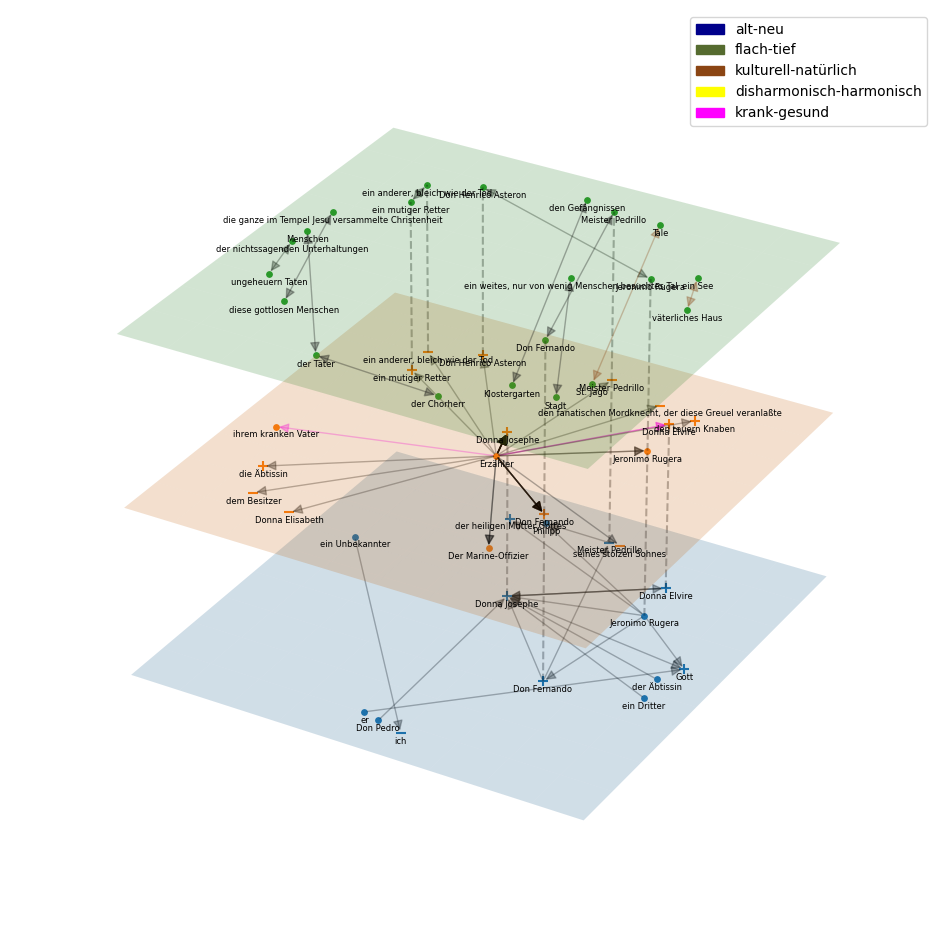

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from mpl_toolkits.mplot3d.art3d import Patch3DCollection
from matplotlib.patches import Arrow
from matplotlib.collections import PatchCollection
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

import matplotlib.patches as mpatches


def codierung_farbe(coords, alt_neu_coords, flach_tief_coords, kult_nat_coords, disharm_harm_coords, krank_gesund_coords):
  """
  Bestimmt Farbe basierend auf Codierungsart (oder Relationsart).

  coords: Koordinaten von codierender und codierter Entität (oder Koordinaten der zur Relation gehörenden Entitäten)
  alt_neu_coords etc: Listen an Koordinaten von alt/neu codierende u als alt/neu codierte Entität (oder alt_neu_opps_coords)
  Diese Listen werden in der Klasse LayeredNetworkGraph erstellt.

  Achtung: Nach Polarität wird nicht differenziert (würde unübersichtlich).
  D.h. sowohl eine als gesund codierte als auch eine als krank codierte Entität
  hätten einen magenta Pfeil, der auf sie zeigt, weil sie zur selben Codierungsart gehören ("gesund-krank").
  """
  if coords in alt_neu_coords:
    return "darkblue"
  elif coords in flach_tief_coords:
    return "darkolivegreen"
  elif coords in kult_nat_coords:
    return "saddlebrown"
  elif coords in disharm_harm_coords:
    return "yellow"
  elif coords in krank_gesund_coords:
    return "magenta"
  else:
    return "black" # default: keine codierung zwischen diesen entitäten bzw bei relationen: es handelt sich um eine wertopposition


class Arrow3D(FancyArrowPatch):
    # https://stackoverflow.com/questions/22867620/putting-arrowheads-on-vectors-in-a-3d-plot
    def __init__(self, xs, ys, zs, *args, **kwargs):
        super().__init__((0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def do_3d_projection(self, renderer=None):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, self.axes.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))

        return np.min(zs)

class LayeredNetworkGraph(object):
    # https://stackoverflow.com/questions/60392940/multi-layer-graph-in-networkx
    """
    Plot multi-graphs in 3D.
    """
    def __init__(self, graphs, node_labels=None, layout=nx.spring_layout, ax=None):
        """Given an ordered list of graphs [g1, g2, ..., gn] that represent
        different layers in a multi-layer network, plot the network in
        3D with the different layers separated along the z-axis.

        Within a layer, the corresponding graph defines the connectivity.
        Between layers, nodes in subsequent layers are connected if
        they have the same node ID.

        Arguments:
        ----------
        graphs : list of networkx.Graph objects
            List of graphs, one for each layer.

        node_labels : dict node ID : str label or None (default None)
            Dictionary mapping nodes to labels.
            If None is provided, nodes are not labelled.

        layout_func : function handle (default networkx.spring_layout)
            Function used to compute the layout.

        ax : mpl_toolkits.mplot3d.Axes3d instance or None (default None)
            The axis to plot to. If None is given, a new figure and a new axis are created.

        """

        # book-keeping
        self.graphs = graphs
        self.total_layers = len(graphs)

        self.node_labels = node_labels
        self.layout = layout

        if ax:
            self.ax = ax
        else:
            fig = plt.figure()
            self.ax = fig.add_subplot(111, projection='3d')

        # create internal representation of nodes and edges
        self.get_nodes()
        self.get_edges_within_layers()
        self.get_edges_between_layers()

        # compute layout and plot
        self.get_node_positions()
        self.draw()


    def get_nodes(self):
        """Construct an internal representation of nodes with the format (node ID, layer)."""
        self.nodes = []
        for z, g in enumerate(self.graphs):
            self.nodes.extend([(node, z) for node in g.nodes()])


    def get_edges_within_layers(self):
        """Remap edges in the individual layers to the internal representations of the node IDs."""
        self.edges_within_layers = []
        for z, g in enumerate(self.graphs):
            self.edges_within_layers.extend([((source, z), (target, z)) for source, target in g.edges()])


    def get_edges_between_layers(self):
        """Determine edges between layers. Nodes in subsequent layers are
        thought to be connected if they have the same ID."""
        self.edges_between_layers = []
        for z1, g in enumerate(self.graphs[:-1]):
            z2 = z1 + 1
            h = self.graphs[z2]
            shared_nodes = set(g.nodes()) & set(h.nodes())
            self.edges_between_layers.extend([((node, z1), (node, z2)) for node in shared_nodes])


    def get_node_positions(self, *args, **kwargs):
        """Get the node positions in the layered layout."""
        # What we would like to do, is apply the layout function to a combined, layered network.
        # However, networkx layout functions are not implemented for the multi-dimensional case.
        # Futhermore, even if there was such a layout function, there probably would be no straightforward way to
        # specify the planarity requirement for nodes within a layer.
        # Therefor, we compute the layout for the full network in 2D, and then apply the
        # positions to the nodes in all planes.
        # For a force-directed layout, this will approximately do the right thing.
        # TODO: implement FR in 3D with layer constraints.

        composition = self.graphs[0]
        for h in self.graphs[1:]:
            composition = nx.compose(composition, h)

        pos = self.layout(composition, k=1.5, *args, **kwargs) # adjust k for distance between nodes

        self.node_positions = dict()
        for z, g in enumerate(self.graphs):
            self.node_positions.update({(node, z) : (*pos[node], z) for node in g.nodes()})


    def draw_nodes(self, nodes, *args, **kwargs):
        """
        Originale Funktion so angepasst, dass auf Figuren- bzw. Erzählerebene pos/neg/beides bzw gar nicht gewertete Entitäten
        mit je unterschiedlichen Knotensymbole angezeigt werden.
        """
        for node in nodes:
          x, y, z = self.node_positions[node] # koordinaten
          ent = self.node_labels[node[0]] # name der entität
          # zuerst Knoten auf Figurenebene eintragen
          if z == 0:
            if ent in Figuren_pos_bewertet:
                self.ax.scatter(x, y, z, marker="+", c="#1f77b4", *args, **kwargs)
            elif ent in Figuren_neg_bewertet:
                self.ax.scatter(x, y, z, marker="_", c="#1f77b4", *args, **kwargs)
            else:
                self.ax.scatter(x, y, z, marker=".", c="#1f77b4", *args, **kwargs)
          # ... dann auf Erzählerebene
          elif z == 1:
            if ent in Erzähler_pos_bewertet:
              self.ax.scatter(x, y, z, marker="+", c="#ff7f0e", *args, **kwargs)
            elif ent in Erzähler_neg_bewertet:
              self.ax.scatter(x, y, z, marker="_", c="#ff7f0e", *args, **kwargs)
            else:
              self.ax.scatter(x, y, z, marker=".", c="#ff7f0e", *args, **kwargs)
          # ... schließlich auf Ebene der Relationen
          else:
            """
            # Knoten derjenigen Entitäten, die an Relationen beteiligt sind, die nicht Wertoppositionen sind, anders kennzeichnen
            # aktuell über versch Pfeilfarben gelöst
            if ent in nicht_Wertoppositionen:
              self.ax.scatter(x, y, z, marker="*", c=farbe, *args, **kwargs)
            else:
            """
            self.ax.scatter(x, y, z, marker=".", c="#2ca02c", *args, **kwargs)


    # originale draw function
    def draw_edges(self, edges, *args, **kwargs):
        global global_segments
        segments = [(self.node_positions[source], self.node_positions[target]) for source, target in edges]
        global_segments = segments
        line_collection = Line3DCollection(segments, *args, **kwargs)
        self.ax.add_collection3d(line_collection)


    def draw_arrows(self, edges, nodes, *args, **kwargs):
        """
        Adds edges as 3D arrows to graph.

        zeichnet unterschiedliche Relationen (oberste Ebene) und Codierungen
        (unteren zwei Ebenen) in unterschiedlichen Farben

        noch offen/Probleme:
        - nur eine Kante zwischen Knoten in nur einer Farbe, auch wenn es vllt mehrere Wertungen/
        Relationen/Codierungen gibt (z.B. sowohl eine Wert- als auch eine natürlich-kulturell-Opposition). Da aber in diesen
        Fällen mehrere Pfeile übereinander dargestellt werden, sind diese Kanten zumindest dicker.
        -  wenn Entitäten sich selbst werten oder codieren, sind sie aktuell ohne Pfeil im Netzwerk platziert.
        Ggf. den Punkt mit einen Pfeil versehen, der auf sich selbst zeigt (wsl kompliziert)
        - ggf for loops für listengenerierungen noch zsmfassen
        """
        # Listen der an Oppositionen beteiligten Knoten (deren Koordinaten). Exkl Wertoppositionen
        nat_kult_opps_coords = []
        alt_neu_opps_coords = []
        flach_tief_opps_coords = []
        disharm_harm_opps_coords = []
        krank_gesund_opps_coords = []

        # Listen der an Codierungen beteiligten Knoten (jeweils codierende u codierte Entität)
        alt_neu_coords = []
        flach_tief_coords = []
        kult_nat_coords = []
        disharm_harm_coords = []
        krank_gesund_coords = []

        # speichert unter dem Entitätennamen die Koordinaten
        # für jede Ebene eigene Liste, weil ja evtl Entitäten auf allen Ebenen vorkommen
        relationen_nodes = {} # oberste Ebene
        erzähler_nodes = {}
        figuren_nodes = {}
        for node in nodes:
          x, y, z = self.node_positions[node] # koordinaten
          ent = self.node_labels[node[0]] # name der entität
          if z == 2:
            relationen_nodes[ent] = (x, y, z)
          elif z == 1:
            erzähler_nodes[ent] = (x, y, z)
          else:
            figuren_nodes[ent] = (x, y, z)

        # Koordinatenlisten füllen
        for relation in nat_kult_Oppositionen:
          nat_kult_opps_coords.append((relationen_nodes[relation[0]], relationen_nodes[relation[1]]))

        for relation in alt_neu_Oppositionen:
          alt_neu_opps_coords.append((relationen_nodes[relation[0]], relationen_nodes[relation[1]]))

        for relation in flach_tief_Oppositionen:
          flach_tief_opps_coords.append((relationen_nodes[relation[0]], relationen_nodes[relation[1]]))

        for relation in disharm_harm_Oppositionen:
          disharm_harm_opps_coords.append((relationen_nodes[relation[0]], relationen_nodes[relation[1]]))

        for relation in krank_gesund_Oppositionen:
          krank_gesund_opps_coords.append((relationen_nodes[relation[0]], relationen_nodes[relation[1]]))

        # die Koordinaten der an Codierungen beteiligten Entitäten in unterschiedlichen
        # Listen je nach Codierungsart speichern
        for codierung in alt_neu:
          # wenn codierende und codierte entität beide auf einer ebene sind, koordinaten abspeichern, um pfeil dazwischen zu zeichnen
          if codierung[0] in erzähler_nodes.keys() and codierung[1] in erzähler_nodes.keys():
            alt_neu_coords.append((erzähler_nodes[codierung[0]], erzähler_nodes[codierung[1]]))
          if codierung[0] in figuren_nodes.keys() and codierung[1] in figuren_nodes.keys():
            alt_neu_coords.append((figuren_nodes[codierung[0]], figuren_nodes[codierung[1]]))

        for codierung in flach_tief:
          if codierung[0] in erzähler_nodes.keys() and codierung[1] in erzähler_nodes.keys():
            flach_tief_coords.append((erzähler_nodes[codierung[0]], erzähler_nodes[codierung[1]]))
          if codierung[0] in figuren_nodes.keys() and codierung[1] in figuren_nodes.keys():
            flach_tief_coords.append((figuren_nodes[codierung[0]], figuren_nodes[codierung[1]]))

        for codierung in kult_nat:
          if codierung[0] in erzähler_nodes.keys() and codierung[1] in erzähler_nodes.keys():
            kult_nat_coords.append((erzähler_nodes[codierung[0]], erzähler_nodes[codierung[1]]))
          if codierung[0] in figuren_nodes.keys() and codierung[1] in figuren_nodes.keys():
            kult_nat_coords.append((figuren_nodes[codierung[0]], figuren_nodes[codierung[1]]))

        for codierung in disharm_harm:
          if codierung[0] in erzähler_nodes.keys() and codierung[1] in erzähler_nodes.keys():
            disharm_harm_coords.append((erzähler_nodes[codierung[0]], erzähler_nodes[codierung[1]]))
          if codierung[0] in figuren_nodes.keys() and codierung[1] in figuren_nodes.keys():
            disharm_harm_coords.append((figuren_nodes[codierung[0]], figuren_nodes[codierung[1]]))

        for codierung in krank_gesund:
          if codierung[0] in erzähler_nodes.keys() and codierung[1] in erzähler_nodes.keys():
            krank_gesund_coords.append((erzähler_nodes[codierung[0]], erzähler_nodes[codierung[1]]))
          if codierung[0] in figuren_nodes.keys() and codierung[1] in figuren_nodes.keys():
            krank_gesund_coords.append((figuren_nodes[codierung[0]], figuren_nodes[codierung[1]]))

        for source, target in edges:
          s = self.node_positions[source]
          t = self.node_positions[target]
          #self.ax.plot([s[0], t[0]], [s[1], t[1]], [0,0]) # normale lines
          if s[2] == 2: # oberste Ebene wird separat abgefragt, weil anderer arrowstyle als auf anderen Ebenen
              # Oppositionen mit zwei Pfeilköpfen darstellen
              # Farbe entweder schwarz, wenn Wertopposition, ansonsten je nach Oppositionsart
              farbe = codierung_farbe((s, t), alt_neu_opps_coords, flach_tief_opps_coords, nat_kult_opps_coords, disharm_harm_opps_coords, krank_gesund_opps_coords)
              arrow = Arrow3D([s[0], t[0]], [s[1], t[1]], [s[2],t[2]], arrowstyle="<|-|>", color=farbe, *args, **kwargs)
              self.ax.add_artist(arrow)
          else:
            # Pfeile zwischen Entitäten, zwischen denen Codierung besteht, werden (je nach Codierungsart) in anderen Farben als schwarz dargestellt
            farbe = codierung_farbe((s, t), alt_neu_coords, flach_tief_coords, kult_nat_coords, disharm_harm_coords, krank_gesund_coords)
            arrow = Arrow3D([s[0], t[0]], [s[1], t[1]], [s[2],t[2]], arrowstyle="-|>", color=farbe, *args, **kwargs)
            self.ax.add_artist(arrow)




    def get_extent(self, pad=0.1):
        xyz = np.array(list(self.node_positions.values()))
        xmin, ymin, _ = np.min(xyz, axis=0)
        xmax, ymax, _ = np.max(xyz, axis=0)
        dx = xmax - xmin
        dy = ymax - ymin
        return (xmin - pad * dx, xmax + pad * dx), \
            (ymin - pad * dy, ymax + pad * dy)


    def draw_plane(self, z, *args, **kwargs):
        (xmin, xmax), (ymin, ymax) = self.get_extent(pad=0.1)
        u = np.linspace(xmin, xmax, 10)
        v = np.linspace(ymin, ymax, 10)
        U, V = np.meshgrid(u ,v)
        W = z * np.ones_like(U)
        self.ax.plot_surface(U, V, W, *args, **kwargs)


    def draw_node_labels(self, node_labels, font_size=6, *args, **kwargs):
        for node, z in self.nodes:
            if node in node_labels:
                x = self.node_positions[(node, z)][0]
                y = self.node_positions[(node, z)][1]
                z = self.node_positions[(node, z)][2]

                #ax.text(*self.node_positions[(node, z)], node_labels[node], fontsize=font_size, *args, **kwargs)

                # Text minimal unterm Knoten platzieren
                ax.text(x, y, z-0.05, node_labels[node], fontsize=font_size, *args, **kwargs)


    def draw(self):
        self.draw_edges(self.edges_between_layers, color='k', alpha=0.3, linestyle='--', zorder=2) # wenn Knoten auf mehreren Ebenen auftauchen, werden sie mit einer gestrichelten Linie u übereinander dargestellt
        self.draw_arrows(self.edges_within_layers, self.nodes, mutation_scale=15, linestyle='solid', alpha=0.3, zorder=2)

        for z in range(self.total_layers):
            self.draw_plane(z, alpha=0.2, zorder=1)
            self.draw_nodes([node for node in self.nodes if node[1]==z], s=60, zorder=3)

        if self.node_labels:
            self.draw_node_labels(self.node_labels,
                                  horizontalalignment='center',
                                  verticalalignment='center',
                                  zorder=100)


if __name__ == '__main__':

    # define graphs
    n = 5
    g = nx.erdos_renyi_graph(4*n, p=0.1)
    h = nx.erdos_renyi_graph(3*n, p=0.2)
    i = nx.erdos_renyi_graph(2*n, p=0.4)

    #node_labels = {nn : str(nn) for nn in range(4*n)}

    # Customize the node label size
    label_font_size = 4

    # Customize the edge color and thickness
    edge_color = 'black'
    edge_width = 2.0


    # initialise figure and plot
    fig = plt.figure(figsize=(16, 12))
    ax = fig.add_subplot(111, projection='3d')

    LayeredNetworkGraph([G_Fig, G, G2], node_labels=node_labels, ax=ax, layout=nx.spring_layout)
    ax.set_axis_off()

    # Legende, die die Pfeilfarben erklärt
    alt_patch = mpatches.Patch(color='darkblue', label='alt-neu')
    flach_patch = mpatches.Patch(color='darkolivegreen', label='flach-tief')
    kult_patch = mpatches.Patch(color='saddlebrown', label='kulturell-natürlich')
    disharm_patch = mpatches.Patch(color="yellow", label='disharmonisch-harmonisch')
    krank_patch = mpatches.Patch(color="magenta", label='krank-gesund')
    plt.legend(handles=[alt_patch, flach_patch, kult_patch, disharm_patch, krank_patch])

    plt.show()

In [ ]:
global_segments

[((-0.87615523743552, -0.4740778187678097, 0),
  (-0.87615523743552, -0.4740778187678097, 1)),
 ((-0.8207132296715167, 0.5499859078064466, 0),
  (-0.8207132296715167, 0.5499859078064466, 1)),
 ((-0.9047038981854358, -0.2695724880895349, 0),
  (-0.9047038981854358, -0.2695724880895349, 1)),
 ((-0.1701142774830051, 0.30249304570835095, 0),
  (-0.1701142774830051, 0.30249304570835095, 1)),
 ((-0.6184804795103329, -0.4388645883620513, 0),
  (-0.6184804795103329, -0.4388645883620513, 1)),
 ((-0.8207132296715167, 0.5499859078064466, 1),
  (-0.8207132296715167, 0.5499859078064466, 2)),
 ((0.03903788690560504, -0.9908686357390848, 1),
  (0.03903788690560504, -0.9908686357390848, 2)),
 ((-0.815335118198243, -0.40618419348195256, 1),
  (-0.815335118198243, -0.40618419348195256, 2)),
 ((-0.7609769259283633, 0.7475218754553129, 1),
  (-0.7609769259283633, 0.7475218754553129, 2)),
 ((-0.1701142774830051, 0.30249304570835095, 1),
  (-0.1701142774830051, 0.30249304570835095, 2)),
 ((-0.61848047951033

### Pymnet

In [ ]:
#import sys
# sys.path.append("/your/path/to/bolozna-multilayer-networks-library-fdd96eef61dd/")
%cd /content/drive/My\ Drive/pymnet/Multilayer-networks-library-master/
from pymnet import *

In [ ]:
%matplotlib inline
mnet = MultilayerNetwork(
    aspects = 1, fullyInterconnected = False
    )

mnet.add_layer("Oppositionen")
mnet.add_layer("Figur")
mnet.add_layer("Erzähler")


for i, row in df.iterrows():
    source = row["Source"]
    target = row["Target"]
    label = row["Label"][:15]
    weight = row["Weight"]
    Typ = row["Type"]
    #edge_color = color_palette["positive"] if weight >= 0 else color_palette["negative"]
    #G.add_edge(source, target, key=i, label=label, weight=weight, width=weight, color=edge_color)
    if source == "Erzähler" and Typ == "FIGUR":
      mnet[source,target, "Erzähler", "Erzähler"] = weight
    if source != "Erzähler" and Typ == "FIGUR":
      mnet[source,target, "Figur", "Figur"] = weight

font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 6}

plt.rc('font', **font)

fig=draw(mnet)


### Py3plex

In [ ]:
!pip install py3plex
from py3plex.core import multinet
from py3plex.core import random_generators

In [ ]:
%matplotlib inline
#plt.close('all')
A = multinet.multi_layer_network(network_type="multiplex",coupling_weight=1)



color_palette = {"positive": "green", "negative": "red"}

for i, row in df.iterrows():
    source = row["Source"]
    target = row["Target"]
    label = row["Label"]
    weight = row["Weight"]
    edge_color = color_palette["positive"] if weight >= 0 else color_palette["negative"]

    simple_edge = {"source": source,
                "target": target,
                "type": label,
                "source_type":"Wertungen",
                "weight" : weight, ## add arbitrary attributes!
                "sunrise_tomorrow" : True,
                "target_type":"Wertungen"}
    A.add_edges(simple_edge)

A.monitor("Printing a single edge.")
print(list(A.get_edges(data=True)))


#A.add_edges(simple_edge)

# Print the multilayer network summary
#print(A.summary())
A.visualize_network(show=True, style="diagonal")
plt.show()
#display(HTML('A.html'))

### multinetx

In [ ]:
!pip install git+https://github.com/nkoub/multinetx.git

In [ ]:
##Import standard libraries
import numpy as np
import matplotlib.pyplot as plt

##Import the package MultiNetX

import multinetx as mx

#Define the type of interconnection between the layers
adj_block = mx.lil_matrix(np.zeros((N*3,N*3)))

adj_block[0:  N,  N:2*N] = np.identity(N)    # L_12
adj_block[0:  N,2*N:3*N] = np.identity(N)    # L_13
#adj_block[N:2*N,2*N:3*N] = np.identity(N)    # L_23
adj_block += adj_block.T

#Create an instance of the MultilayerGraph class
mg = mx.MultilayerGraph(list_of_layers=[g1,g2,g3],
						inter_adjacency_matrix=adj_block)

mg.set_edges_weights(inter_layer_edges_weight=4)

mg.set_intra_edges_weights(layer=0,weight=1)
mg.set_intra_edges_weights(layer=1,weight=2)
mg.set_intra_edges_weights(layer=2,weight=3)

#Plot the adjacency matrix and the multiplex networks
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(121)
ax1.imshow(mx.adjacency_matrix(mg,weight='weight').todense(),
		  origin='upper',interpolation='nearest',cmap=plt.cm.jet_r)
ax1.set_title('supra adjacency matrix')

ax2 = fig.add_subplot(122)
ax2.axis('off')
ax2.set_title('regular interconnected network')
pos = mx.get_position(mg,mx.fruchterman_reingold_layout(mg.get_layer(0)),
					  layer_vertical_shift=1.4,
					  layer_horizontal_shift=0.0,
					  proj_angle=7)
mx.draw_networkx(mg,pos=pos,ax=ax2,node_size=50,with_labels=False,
				 edge_color=[mg[a][b]['weight'] for a,b in mg.edges()],
				 edge_cmap=plt.cm.jet_r)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a multilayer network graph
G = nx.MultiGraph()

# Add nodes and edges for different layers
G.add_edge(1, 2, layer='Layer1')
G.add_edge(2, 3, layer='Layer2')

# Create a dictionary to store node attributes by layer
node_sizes = {'Layer1': 200, 'Layer2': 300}
node_colors = {'Layer1': 'blue', 'Layer2': 'red'}
edge_widths = {'Layer1': 1.5, 'Layer2': 2.5}

# Plot the multilayer network
pos = nx.spring_layout(G)  # or any other layout algorithm
for layer, nodes in nx.get_edge_attributes(G, 'layer').items():
    nx.draw_networkx_edges(G, pos, edgelist=nodes, width=edge_widths[layer])

nx.draw_networkx_nodes(G, pos, node_size=[node_sizes.get(n, 300) for n in G.nodes],
                       node_color=[node_colors.get(n, 'green') for n in G.nodes])

plt.axis('off')
plt.show()

# Daten für Setfit auslesen

In [ ]:
import shutil
# delete old
shutil.rmtree("/content/curation/")

# Define the path to the zip file and the extraction directory
zip_file_path = '/content/webanno16503675756425986770export_curated_documents.zip'
extract_dir = '/content/'

# Extract the zip file
shutil.unpack_archive(zip_file_path, extract_dir)

In [98]:
def polarität_zu_binary(polarität):
  """
  Gibt für verschiedene Codierungspolaritäten Integer aus, um Kompatibilität mit bisherigen Code (auf Wertungen bezogen) zu gewährleisten.

  Bsp: polarität == "sehr alt/traditionell" returns -1
  """
  # neue Labels umbenennen althergebracht/traditionell --> alt/traditionell
  if polarität != None:
    polarität = polarität.replace("althergebracht/traditionell", "alt/traditionell")


  match polarität:
    case "sehr alt/traditionell" | "sehr flach/oberflächlich" | "sehr kulturell/zivilisatorisch" | "sehr disharmonisch/fragmentiert" | "sehr krank/morbid":
      return polarität.replace("sehr ", "").split("/")[0]
    case "alt/traditionell" | "flach/oberflächlich" | "kulturell/zivilisatorisch" | "disharmonisch/fragmentiert" | "krank/morbid":
      return polarität.replace("sehr ", "").split("/")[0]
    case "neuartig/modern" | "tief/tiefsinnig" | "natürlich/ursprünglich" | "harmonisch/ganzheitlich" | "gesund/heil":
      return polarität.replace("sehr ", "").split("/")[0]
    case "sehr neuartig/modern" | "sehr tief/tiefsinnig" | "sehr natürlich/ursprünglich" | "sehr harmonisch/ganzheitlich" | "sehr gesund/heil":
      return polarität.replace("sehr ", "").split("/")[0]
    case _:
      #raise ValueError("Keine existierende Polarität: %s", polarität)
      print("Keine existierende Polarität: %s", polarität)



In [99]:
# Codierungen auslesen
Codierungen = {}
j = 0
# speichert Codierungen nach diesem Muster (analog dazu, wie Wertungen abgespeichert werden):
# {1: (Codierende*r, codierte Entität, Art der Codierung, Polarität, Entitätentyp),
#  2: (Codierende*r, codierte Entität, Art der Codierung, Polarität, Entitätentyp)}


def codierung_auslesen():
  global j
  global Codierungen
  # ein segment == eine codierung
  for segment in doc.select('webanno.custom.AltNeuCodierung'):
      j = j+1
      #print(segment.get_covered_text())

      if segment.Polaritt_harmonisch:
        # polarität = segment.Polaritt_harmonisch # polarität als string abspeichern (zB "sehr alt/traditionell" statt -1)
        polarität = polarität_zu_binary(segment.Polaritt_harmonisch)
      elif segment.Polaritt_gesund:
        # polarität = segment.Polaritt_gesund
        polarität = polarität_zu_binary(segment.Polaritt_gesund)
      elif segment.Polaritt_natrlich:
        # polarität = segment.Polaritt_natrlich
        polarität = polarität_zu_binary(segment.Polaritt_natrlich)
      elif segment.Polaritt_tief:
        # polarität = segment.Polaritt_tief
        polarität = polarität_zu_binary(segment.Polaritt_tief)
        polarität = polarität.replace("flach", "oberflächlich")
      elif segment.Polaritt: # = Polarität traditionell
        # polarität = segment.Polaritt
        polarität = polarität_zu_binary(segment.Polaritt)
        polarität = polarität.replace("alt", "traditionell")
      else:
        # polarität = None
        polarität = polarität_zu_binary(None)


      codierte_entität = ""
      codierend = "Erzähler" # default Codierende*r ist Erzähler*in
      """if segment.Bezugsentitt: # d.h. wir ignorieren all jene Codierungen, bei denen keine codierte Entität o Codierende*r annotiert ist (weil schlecht darstellbar). Bei zB Roth werden dann zwei Codierungen nicht weiter berücksichtigt
        for e in segment.Bezugsentitt.elements:
            if e.role == "codierte Entität":
              ent_typ = e.target.label
              if e.target.Name:
                codierte_entität = e.target.Name.split(":")[1].strip()
              else:
                codierte_entität = e.target.get_covered_text()
            elif e.role == "Codierender": # wenn die Entität Codierender ist und nicht Codierter (gibts z.B. bei Roth)
              if e.target.Name:
                codierend = e.target.Name.split(":")[1].strip()
              else:
                codierend = e.target.get_covered_text()

        # kompaktere Speicherungsart:
        # {codierte Entität A : [[Art der Codierung, Polarität, Codierende*r], [Art der Codierung2, Polarität2, Codierende*r2], ...]; codierte Entität B: []; ...}
        if codierte_entität in Codierungen: # wenn diese Entität bereits als key existiert, weil schon andere Codierung dazu abgespeichert wurde
          Codierungen[codierte_entität].append([segment.Art, polarität, codierend, ent_typ])
        else:
          Codierungen[codierte_entität] = [[segment.Art, polarität, codierend, ent_typ]]

        #if codierte_entität:
          #Codierungen[j] = segment.get_covered_text(), codierend, codierte_entität, segment.Art, polarität, ent_typ
        """
      # vereinfacht
      Codierungen[j] = segment.get_covered_text(), segment.Art, polarität

  return Codierungen

# testweise Ausgabe
#for k,v in Codierungen.items():
#  print(k, ": ", v)

In [162]:
unannotated_segments = {}
import nltk
nltk.download('punkt')  # Download the Punkt tokenizer for sentence splitting

unannotated_segments = {}
Codierungen = {}
j = 0

def get_unannotated_segments(doc):
    global Codierungen
    global j

    # Get the full text of the document
    full_text = doc.sofa_string

    # Initialize the last end position to the start of the document
    last_end = 0

    unannotated_segments = []

    for segment in doc.select('webanno.custom.AltNeuCodierung'):
        # Get the start and end positions of the current annotation
        start = segment.begin
        end = segment.end

        # If there's a gap between the last end and the current start, capture it
        if start > last_end:
            unannotated_text = full_text[last_end:start]
            # Split the unannotated text into sentences
            sentences = nltk.sent_tokenize(unannotated_text)
            for sentence in sentences:
                if len(sentence) > 1:
                  j += 1
                  Codierungen[j] = (sentence, "None", "None")

        # Update last_end to the current annotation's end
        last_end = end

    # Capture the final unannotated part after the last annotation
    if last_end < len(full_text):
        unannotated_text = full_text[last_end:]
        # Split the unannotated text into sentences
        sentences = nltk.sent_tokenize(unannotated_text)
        for sentence in sentences:
            if len(sentence) > 1:
              j += 1
              Codierungen[j] = (sentence, "None", "None")

    return Codierungen

# Example usage:
# doc = ...  # Load your CAS document
# unannotated_parts = get_unannotated_segments(doc)

# Codierungen will now contain sentences from unannotated segments


get_unannotated_segments(doc)

# Printing the unannotated segments
for ( text, Art, Polarität) in unannotated_segments:
  print(f"{text}, {Art}, {Polarität}")



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [152]:
Codierungen

{1: ('Die Weise von Liebe und Tod des Cornets Christoph Rilke\r\nRainer Maria Rilke\r\n\r\n\r\n»... den 24.',
  None,
  None),
 2: ('November 1663 wurde Otto von Rilke /auf Langenau / Gränitz und Ziegra / zu Linda mit seines in Ungarn gefallenen Bruders Christoph hinterlassenem Antheile am Gute Linda beliehen; doch mußte er einen Revers ausstellen / nach welchem die Lehensreichung null und nichtig sein sollte / im Falle sein Bruder Christoph (der nach beigebrachtem Totenschein als Cornet in der Compagnie des Freiherrn von Pirovano des kaiserl.',
  None,
  None),
 3: ('oesterr.', None, None),
 4: ('Heysterschen Regiments zu Roß.... verstorben war) zurueckkehrt...«\r\n\r\nReiten, reiten, reiten, durch den Tag, durch die Nacht, durch den Tag.',
  None,
  None),
 5: ('Reiten, reiten, reiten.', None, None),
 6: ('Und der Mut ist so müde geworden und die Sehnsucht so groß.',
  None,
  None),
 7: ('Nichts wagt aufzustehen.', None, None),
 8: ('Nirgends ein Turm.', None, None),
 9: ('Und immer

In [164]:
import os
import zipfile

Codierungen = {}
j = 0

# Define the path to your Google Drive folder
base_folder = '/content/curation'

# Loop through each subfolder in the base folder
for subfolder in os.listdir(base_folder):
    if "Brecht_Das_Wiedersehen - Kopie.txt" in subfolder:
      continue
    subfolder_path = os.path.join(base_folder, subfolder)
    #print(subfolder_path)

    # Ensure it's a directory
    if os.path.isdir(subfolder_path):
        # Loop through each file in the subfolder
        for file in os.listdir(subfolder_path):
            file_path = os.path.join(subfolder_path, file)

            # If it's a zip file, process it
            if zipfile.is_zipfile(file_path):
                with zipfile.ZipFile(file_path, 'r') as zip_ref:
                    # Extract the contents of the zip file to the subfolder
                    zip_ref.extractall(subfolder_path)

                    # Get the paths to the extracted TypeSystem.xml and CURATION_USER.xmi
                    typesystem_path = os.path.join(subfolder_path, 'TypeSystem.xml')
                    cas_file_path = os.path.join(subfolder_path, 'CURATION_USER.xmi')
                    #print(typesystem_path)
                    print(cas_file_path.rsplit('/', 5 )[-2])
                    print()

                    # Ensure both files are present
                    if os.path.exists(typesystem_path) and os.path.exists(cas_file_path):
                        # Load the TypeSystem
                        with open(typesystem_path, 'rb') as f:
                            typesystem = load_typesystem(f)

                        # Load the CAS document
                        with open(cas_file_path, 'rb') as f:
                            doc = load_cas_from_xmi(f, typesystem=typesystem)

                        # Call your function with the loaded doc
                        codierung_auslesen()
                        get_unannotated_segments(doc)
print(Codierungen)

Mann_Beim_Propheten_clean.txt

Grimm_Aschenputtel_clean.txt

Grimm_Frau_Holle_clean.txt

Kafka_Der_neue_Advokat_Kolimo.xml

Grimm_Das_tapfere_Schneiderlein.txt

Brecht_Müllers_natürliche_Haltung.txt

Löns_Die_beiden_Höfe_clean.txt

Dorn_Vorsicht_Steinschlag.txt

Walser_Der_Nachen.txt

Kafka_Bericht_für_eine_Akademie.xml

Roth_Der_stumme_Prophet_Fragment_gb_clean.txt

Brecht_Herr_Keuner_und_die_Schauspielerin.txt

Kleist_Chili_clean.txt

Aichinger_Das_Fenstertheater.txt

Auerbach_Der_Kindesmord.txt

Langgässer_Die_Sippe_auf_dem_Berg_und_im_Tal.txt

Bachmann_Arkadien_clean.txt

Böll_Wanderer_kommst_du_nach_Spa_clean.txt

Bierbaum_Der_Mohr.txt

Hollenstein_Gelb_wie_eine_Zitrone.txt

Stamm_Das_schönste_Mädchen.txt

Mann_Der_Geburtstag_der_Frau_Baronin.txt

Rilke_Die_Weise_von_Liebe_und_Tod_des_Cornets_Christoph_Rilke_clean.txt

{1: ('wo einsame, empörte und von innen verzehrte Künstler, hungrig und stolz, im Zigarettenqualm mit letzten und wüsten Idealen ringen', 'Harmonisch-Disharmonisch'

In [166]:
import pandas as pd
df = pd.DataFrame(Codierungen).T
df.columns =["text", "dimension", "label_text"]
#filtered_df = df[~df['label_text'].notna()]
#filtered_df
#df[df["dimension"] =="Alt-Neu"]


categories = np.array(['disharmonisch', 'krank', 'traditionell', 'kulturell', 'neuartig',
                       'natürlich', 'harmonisch', 'oberflächlich', 'gesund', 'tief'])

# Create a mapping from categories to numeric labels
category_to_label = {category: index for index, category in enumerate(categories, 1)}
category_to_label["None"] = 0  # Ensure None maps to 0

# Function to map categories to labels
def map_to_label(value):
    return category_to_label.get(value, 0)  # Default to 0 for any unknown values

# Convert each value in the DataFrame to its numeric label
df_numeric = df.applymap(map_to_label)

df['label'] = df_numeric.max(axis=1)

df.head(50)


<ipython-input-166-f55dc7d76d7b>:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_numeric = df.applymap(map_to_label)


text  \
1   wo einsame, empörte und von innen verzehrte Kü...   
2   Hier herrscht der Trotz, die äußerste Konseque...   
3   eine Persönlichkeit von zugleich martialischem...   
4   Er trug Gehrock und Handschuhe, entschlossen, ...   
5   Er war an einem literarischen Teetische mit ih...   
6   voller Ehrfurcht vor allen Erscheinungen der W...   
7   ragte zwischen niedrigen Holzsesseln ein stren...   
8                             antik geformte Öllampen   
9   ihrem prachtvollen Hause mit den Gobelins und ...   
10  und kam zur Tür herein, schön, duftend, luxuri...   
11  und in des Novellisten Augen ein unglaubhafter...   
12  Er las mit einer wilden und überlauten Stimme,...   
13  dann trank er zitternd einen Schluck aus dem B...   
14  dann trank er zitternd einen Schluck aus dem B...   
15  Das einsame Ich sang, raste und kommandierte. ...   
16  Beim Propheten   Seltsame Orte gibt es, seltsa...   
17  An den Peripherien der Großstädte, dort, wo di...   
18  Hier ist das Ende, das Eis, die Reinheit und d...   
19  Hier gilt kein Vertrag, kein Zugeständnis, kei...   
20  Hier ist die Luft so dünn und keusch, daß die ...   
21              …  Es war Karfreitag, abends um acht.   
22  Mehrere von denen, die Daniel geladen hatte, k...   
23  Sie hatten Einladungen in Quartformat erhalten...   
24       Einige kannten einander und tauschten Grüße.   
25  Es waren der polnische Maler und das schmale M...   
26  , und ein junger Philosoph mit dem Äußern eine...   
27  Nur der Novellist, ein Herr mit steifem Hut un...   
28  Er kam aus einer andern Sphäre, war nur zufäll...   
29  Er hatte ein gewisses Verhältnis zum Leben, un...   
30  Er war entschlossen, sich streng bescheiden, d...   
31  In einem kleinen Abstande folgte er den andere...   
32  Sie stiegen die Treppe empor, eine nach der an...   
33  Sie schwiegen, denn es waren Menschen, die den...   
34  Im trüben Licht der kleinen Petroleumlampen, d...   
35  Sie stiegen an den Heim- und Sorgenstätten ein...   
36  Sie stiegen in dem engen Treppenhaus wie in ei...   
37  Endlich standen sie am Ziel, unter dem Dach, i...   
38  An der Tür, welche bereits den Charakter eines...   
39  Sie schellten …  Ein breitköpfiger, freundlich...   
40  Wortlos, mit einer Geste, die von einem lallen...   
41  Es führte die Gäste mit seinem Licht über den ...   
42                  Der Novellist folgte als letzter.   
43  Eine feierlich schwankende und flimmernde Hell...   
44  Ein junges Mädchen mit weißem Fallkragen und M...   
45                          Der Novellist kannte sie.   
46  Sie hatte aufrecht dagesessen, die Tasse in de...   
47                              Sie betete Daniel an.   
48  Der Novellist suchte ihn mit den Augen …  »Er ...   
49              »Er ist abwesend, ich weiß nicht, wo.   
50  Aber im Geiste wird er unter uns sein und die ...   

                   dimension     label_text  label  
1   Harmonisch-Disharmonisch  disharmonisch      1  
2   Harmonisch-Disharmonisch  disharmonisch      1  
3               Gesund-Krank          krank      2  
4        Traditionell-Modern   traditionell      3  
5        Natürlich-Kulturell      kulturell      4  
6        Traditionell-Modern       neuartig      5  
7        Traditionell-Modern   traditionell      3  
8        Traditionell-Modern   traditionell      3  
9        Natürlich-Kulturell      kulturell      4  
10       Natürlich-Kulturell      kulturell      4  
11       Natürlich-Kulturell      kulturell      4  
12              Gesund-Krank          krank      2  
13              Gesund-Krank          krank      2  
14              Gesund-Krank          krank      2  
15  Harmonisch-Disharmonisch  disharmonisch      1  
16                      None           None      0  
17                      None           None      0  
18                      None           None      0  
19                      None           None      0  
20                      None           None      0  
21                      None

In [169]:
df["label_text"].value_counts()

label_text
None             2064
disharmonisch      54
kulturell          51
traditionell       32
natürlich          29
harmonisch         29
krank              18
neuartig           15
tief               15
oberflächlich      11
gesund              5
Name: count, dtype: int64

In [168]:
import csv
from google.colab import drive
drive.mount('/content/drive')

csv_file_path = "/content/drive/My Drive/Kulturkritik/Results/codierungen.csv"
df.to_csv(csv_file_path, index=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
